In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q xplique keras_cv kecam
!cp -r "/content/drive/MyDrive/Revisiting Feature Viz/data/reference_spectrum" ./

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.0/796.0 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.4 MB/s eta 0:00:00


In [2]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import *

from matplotlib import pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img)
  plt.axis('off')

import seaborn as sns
sns.set(font_scale=0.9)

def r(n):
  return round(float(n), 3)

def clip_percentile(img, p=0.1):
  return np.clip(img, np.percentile(img, p), np.percentile(img, 100-p))

<ipython-input-2-4202cbbe28d8>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Define the baselines

In [3]:
from xplique.attributions import *
from xplique.metrics import *

In [4]:
def permute_ax1(x):
  x = x.copy()
  x = np.moveaxis(x, 1, 0)
  np.random.shuffle(x)
  x = np.moveaxis(x, 1, 0)
  return x


def random_permute(x):
  x = np.array(x).copy()
  s = x.shape
  x = x.reshape((len(x), -1, 3))
  x = permute_ax1(x)
  return x.reshape(s)

def downsample_upsample(x):
  s = (x.shape[-3], x.shape[-2])
  x = tf.image.resize(x, (8, 8), method="bilinear")
  x = tf.image.resize(x, s, method="nearest").numpy()
  return x

def local_permute(x):
  s = (x.shape[-3], x.shape[-2])
  x = tf.image.resize(x, (8, 8), method="bilinear")
  x = random_permute(x)
  x = tf.image.resize(x, s, method="nearest").numpy()
  return x

def scramble_phase(x):
  spectrum = np.fft.fft2(x)
  amplitude = np.abs(spectrum)

  phase = np.angle(spectrum)
  phase = random_permute(phase)
  #phase = np.random.normal(phase.mean(), phase.std(), phase.shape)

  x = np.abs(np.fft.ifft2(amplitude * np.exp(1j * phase)))

  return x

def scramble_amplitude(x):
  spectrum = np.fft.fft2(x)

  amplitude = np.abs(spectrum)
  amplitude = random_permute(amplitude)

  phase = np.angle(spectrum)

  x = np.abs(np.fft.ifft2(amplitude * np.exp(1j * phase)))

  return x


baselines = {
    'zero': lambda x : tf.zeros(x.shape).numpy(),
    'uniform': lambda x : tf.random.uniform(x.shape, -1, 1).numpy(),
    'normal': lambda x : tf.clip_by_value(tf.random.normal(x.shape), -1, 1).numpy(),
    'permutation': lambda x : random_permute(x),
    'local_mean': lambda x : downsample_upsample(x),
    'local_permutation': lambda x : local_permute(x),
    'mean': lambda x : np.ones(x.shape) * np.mean(x, (1, 2))[:, None, None, :],
    'median': lambda x : np.ones(x.shape) * np.median(x, (1, 2))[:, None, None, :],
    'random_color': lambda x : np.ones(x.shape) * (np.random.rand(3) * 2 - 1.),
    'scramble_phase': lambda x : scramble_phase(x),
    'scramble_amplitude': lambda x : scramble_amplitude(x)
}

## Create the FV baseline

In [5]:
from scipy.ndimage import gaussian_filter as gaussian
import PIL

def plot(t):
  """ Remove outlier and plot image """
  t = clip_percentile(t, 0.1)
  t -= t.mean(); t /= t.std()
  t -= t.min(); t /= t.max()
  plt.imshow(t)
  plt.axis('off')

def plot_alpha(t, tr):
  """ Remove outlier and plot image (take care of merging the alpha) """
  t = clip_percentile(t, 0.1)
  t -= t.mean(); t /= t.std()
  t -= t.min(); t /= t.max()

  tr = np.mean(tr, -1, keepdims=True)
  tr = gaussian(tr, sigma=50)
  tr = np.clip(tr, 0, np.percentile(tr, 75))
  tr /= tr.max()

  viz = np.concatenate([t, tr], -1)
  plt.imshow(viz)
  plt.axis('off')

  return viz

In [6]:
imagenet_color_correlation = tf.cast(
      [[0.56282854, 0.58447580, 0.58447580],
       [0.19482528, 0.00000000,-0.19482528],
       [0.04329450,-0.10823626, 0.06494176]], tf.float32
)

def recorrelate_colors(images):
    images_flat = tf.reshape(images, [-1, 3])
    images_flat = tf.matmul(images_flat, imagenet_color_correlation)
    return tf.reshape(images_flat, tf.shape(images))

In [7]:
from kecam import flexivit

In [8]:
model_vit = flexivit.FlexiViTSmall(input_shape=(240, 240, 3), classifier_activation="linear")
model = tf.keras.Model(model_vit.input, model_vit.layers[-2].output)
MODEL_INPUT_SIZE = (240, 240)
model_vit.name

88820648/88820648 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/flexivit_small_240_imagenet.h5


'flexivit_small'

In [9]:
@tf.function
def cosine_similarity(tensor_a: tf.Tensor, tensor_b: tf.Tensor) -> tf.Tensor:
    tensor_a = tf.nn.l2_normalize(tensor_a, axis=-1)
    tensor_b = tf.nn.l2_normalize(tensor_b, axis=-1)
    return tf.reduce_sum(tensor_a * tensor_b, axis=-1)

@tf.function
def dot_cossim(tensor_a: tf.Tensor, tensor_b: tf.Tensor, cossim_pow: float = 2.0) -> tf.Tensor:
    cosim = tf.maximum(cosine_similarity(tensor_a, tensor_b), 1e-1) ** cossim_pow
    dot = tf.reduce_sum(tensor_a * tensor_b)
    return dot * cosim

In [10]:
import cv2
SIZE = 2048

def init_buffer(size = 2048, std=0.5):
  spectrum_shape = (size, size//2+1)

  # init randomly the phase and load the constrained spectrum (average spectrum)
  phase = np.random.normal(size=(3, size, size//2+1), scale=std).astype(np.float32)
  magnitude = np.load("/content/reference_spectrum/decorrelated_1024.npy")

  magnitude = tf.image.resize(np.moveaxis(magnitude, 0, -1), spectrum_shape).numpy()
  magnitude = np.moveaxis(magnitude, -1, 0)

  return tf.cast(magnitude, tf.float32), tf.cast(phase, tf.float32)

# IMPORTANT :
# change this value to adapt for model input range
# multiplier = 1 means [-1, 1],
# multiplier = 2 means [-2, 2]...
MULTIPLIER = 1.0

@tf.function
def fft_to_rgb(magnitude_template, magnitude_alpha, phase):

  magnitude = magnitude_template * magnitude_alpha

  phase = phase - tf.reduce_mean(phase)
  phase /= tf.math.reduce_std(phase)

  buffer = tf.complex(tf.cos(phase) * magnitude, tf.sin(phase) * magnitude)
  img = tf.signal.irfft2d(buffer)
  img = tf.transpose(img, [1,2,0])

  img -= tf.reduce_mean(img)
  img = img / (tf.math.reduce_std(img) * 2.0 + 1e-3)

  img = recorrelate_colors(img)
  img = tf.nn.sigmoid(img) * 2.0 - 1.0

  return img

@tf.function
def up_neurons(model, magnitude_template, magnitude_alpha, phase,
               box_average_size, box_size_std,
               noise_std, nb_crops):

  with tf.GradientTape() as tape:
    tape.watch(phase)
    tape.watch(magnitude_alpha)

    image = fft_to_rgb(magnitude_template, magnitude_alpha, phase)
    x = image

    # sample random crops in the buffer
    x0 = 0.5 + tf.random.normal((nb_crops,), stddev=0.15)
    y0 = 0.5 + tf.random.normal((nb_crops,), stddev=0.15)
    delta_x = tf.random.uniform((nb_crops,), minval=0.05, maxval=0.7)
    #delta_x = tf.clip_by_value(delta_x, 0.03, 1.0)
    delta_y = delta_x # square boxes

    box_indices = tf.zeros(shape=(nb_crops,), dtype=tf.int32)
    boxes = tf.stack([x0 - delta_x * 0.5,
                      y0 - delta_y * 0.5,
                      x0 + delta_x * 0.5,
                      y0 + delta_y * 0.5], -1)

    x = tf.image.crop_and_resize(x[None, :, :, :], boxes, box_indices, MODEL_INPUT_SIZE, method='bilinear')

    # add some random noise for the robustness
    x += tf.random.normal(x.shape, stddev=noise_std, mean=0.0)
    x += tf.random.uniform(x.shape, minval=-noise_std/2.0, maxval=noise_std/2.0)

    features = model(x, training=False)
    loss = tf.reduce_mean(tf.abs(features))

  grads = tape.gradient(loss, [phase, image, magnitude_alpha])
  grads_phase, grads_image, grads_alpha = grads

  return grads_phase, grads_image, grads_alpha, loss

In [ ]:
from tqdm import tqdm
import PIL
from PIL import Image


def compute_baseline_fv(model):
  sz = 2048

  optimizer_class = Nadam
  learning_rate = 1.0
  initialization_std = 1.0

  nb_steps = 2048

  # Works for every model that are approximately in the range (-1, 1)
  noise_std = 0.080
  box_average_size = tf.cast(np.linspace(0.45, 0.30, nb_steps), tf.float32)
  box_size_std = 0.05

  magnitude_template, phase = init_buffer(size=sz, std=initialization_std)
  phase = tf.Variable(phase, trainable=True)
  magnitude_alpha = tf.Variable(tf.zeros(magnitude_template.shape), trainable=True)

  optimizer = optimizer_class(learning_rate)
  transparency = tf.zeros((magnitude_template.shape[1], magnitude_template.shape[1], 3))
  for i in tqdm(range(nb_steps)):

    grads, grads_img, grads_alpha, loss = up_neurons(model, magnitude_template, magnitude_alpha,
                                                              phase,
                                                              box_average_size=box_average_size[i],
                                                              box_size_std=box_size_std,
                                                              noise_std=noise_std,
                                                              nb_crops=8)
                                                              # nb_crops=32)
    optimizer.apply_gradients(zip([grads, grads_alpha], [phase, magnitude_alpha]))

    transparency += tf.abs(grads_img)

    if i == nb_steps-1 or (i+1) % 500 == 0: # if you want to plot every 25 steps
    #if i == nb_steps-1: # if you want to plot every 25 steps
      set_size(4, 4)
      img = fft_to_rgb(magnitude_template, magnitude_alpha, phase).numpy()
      viz = plot_alpha(img, transparency)
      plt.tight_layout()
      #plt.savefig(f'{logit_id}.png', dpi=350)
      #fn = f'flexiln_{vector_id}.npy'
      #np.save(fn, [img, transparency])
      #!cp {fn} "/content/drive/MyDrive/  temp/ferroviaire"
      plt.show()
      print(float(loss))

  return img

In [ ]:
baseline_fv_vit = compute_baseline_fv(model)
baseline_fv_vit = tf.image.resize(baseline_fv_vit, (240, 240))

Output hidden; open in https://colab.research.google.com to view.

In [13]:
preprocess_r50 = tf.keras.applications.resnet.preprocess_input
model_r50 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3), classifier_activation="linear")
model = tf.keras.Model(model_r50.input, model_r50.layers[-2].output)
MODEL_INPUT_SIZE = (224, 224)

102869336/102869336 [==============================] - 1s 0us/step


In [ ]:
baseline_fv_r50 = compute_baseline_fv(model)
baseline_fv_r50 = tf.image.resize(baseline_fv_r50, (224, 224))

Output hidden; open in https://colab.research.google.com to view.

## Compute the classifications for the baselines for these two models

In [11]:
def load_image(filepath: str, resize_dims: tuple = None):
    """
    Loads a JPG image from a specified file path, decodes it to a tensor, and resizes it if dimensions are provided.

    Args:
    filepath (str): The path to the image file.
    resize_dims (tuple): Optional. A tuple of two integers, (height, width), to resize the image.

    Returns:
    tf.Tensor: A tensor representing the loaded and processed image.
    """
    # Read the image file
    image_string = tf.io.read_file(filepath)

    # Decode the image file to a tensor
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)

    # Resize the image if dimensions are specified
    if resize_dims:
        image_resized = tf.image.resize(image_decoded, resize_dims)
        return image_resized

    return image_decoded

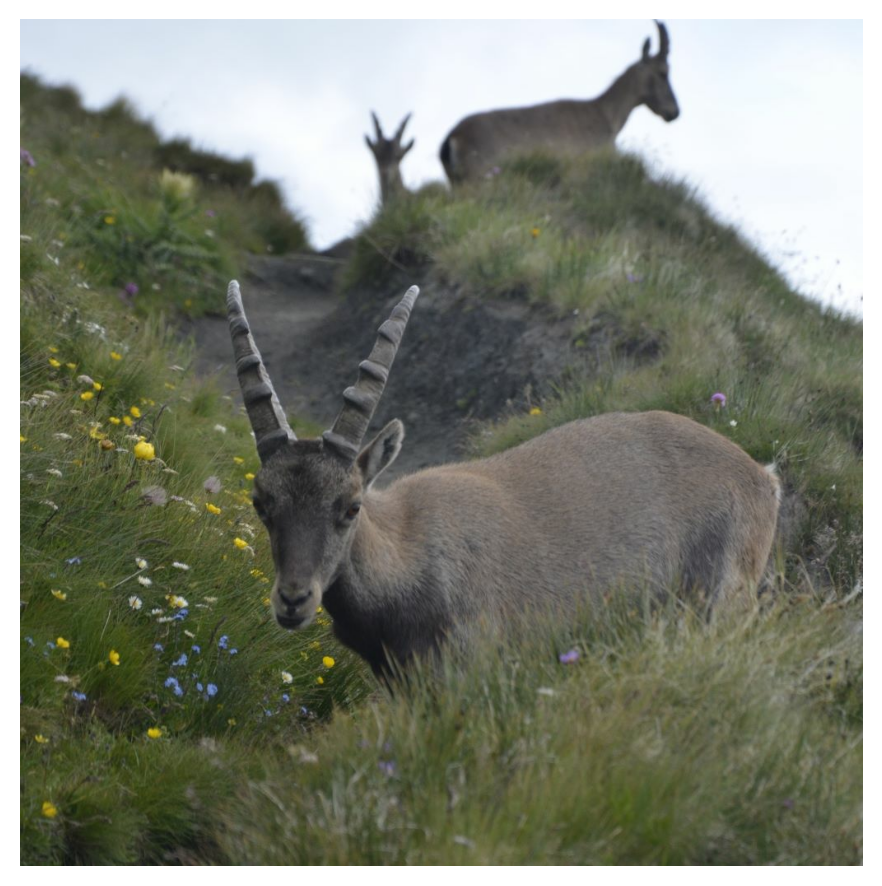

In [14]:
# Go fetch the image of the bouquetin
img = load_image("./_TIB2206_copy.JPG")
show(tf.image.convert_image_dtype(img, dtype=tf.float32))
img_vit = tf.image.resize(img, (240, 240))
img_r50 = preprocess_r50(tf.image.resize(img, (224, 224)))

In [15]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions

In [16]:
classifications_vit = {}
for baseline_name, baseline_fn in zip(baselines.keys(), baselines.values()):
  baseline_image = baseline_fn(tf.expand_dims(img_vit, axis=0))
  logits = model_vit(baseline_image)
  top_k_classes = tf.argsort(logits, axis=-1, direction="DESCENDING")[0,:5]
  top_k_softmax_values = tf.gather(tf.nn.softmax(logits[0]), top_k_classes)
  decoded_logits = decode_predictions(logits.numpy(), top=5)
  classifications_vit[(baseline_name, "classes")] = list(map(lambda z: z[1], decoded_logits[0]))
  classifications_vit[(baseline_name, "softmax")] = top_k_softmax_values

35363/35363 [==============================] - 0s 0us/step


In [17]:
classifications_r50 = {}
for baseline_name, baseline_fn in zip(baselines.keys(), baselines.values()):
  baseline_image = baseline_fn(tf.expand_dims(img_r50, axis=0))
  logits = model_r50(baseline_image)
  top_k_classes = tf.argsort(logits, axis=-1, direction="DESCENDING")[0,:5]
  top_k_softmax_values = tf.gather(tf.nn.softmax(logits[0]), top_k_classes)
  decoded_logits = decode_predictions(logits.numpy(), top=5)
  classifications_r50[(baseline_name, "classes")] = list(map(lambda z: z[1], decoded_logits[0]))
  classifications_r50[(baseline_name, "softmax")] = top_k_softmax_values

In [ ]:
def plot_softmax_classes(data: dict):
    """
    Generates bar plots for softmax probabilities with corresponding class labels from a dictionary.

    Args:
    data (dict): A dictionary with keys as tuples (name, type) where type is either 'classes' or 'softmax',
                 and values are lists representing class labels or softmax probabilities respectively.

    Raises:
    ValueError: If the data does not contain corresponding 'classes' and 'softmax' for each name.
    """

    # Iterate through the names and gather data for plotting
    for key in data.keys():
        if key[1] == 'classes':
            name, _ = key
            classes_key = (name, 'classes')
            softmax_key = (name, 'softmax')

            # Ensure both classes and softmax data are present
            if softmax_key not in data:
                raise ValueError(f"Missing 'softmax' data for {name}")

            classes = data[classes_key]
            softmax = data[softmax_key]

            # Plotting
            plt.figure(figsize=(10, 6))
            plt.bar(classes, softmax, color='skyblue')
            plt.xlabel('Classes')
            plt.ylabel('Softmax Probability')
            plt.title(f'Softmax Probabilities for {name}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

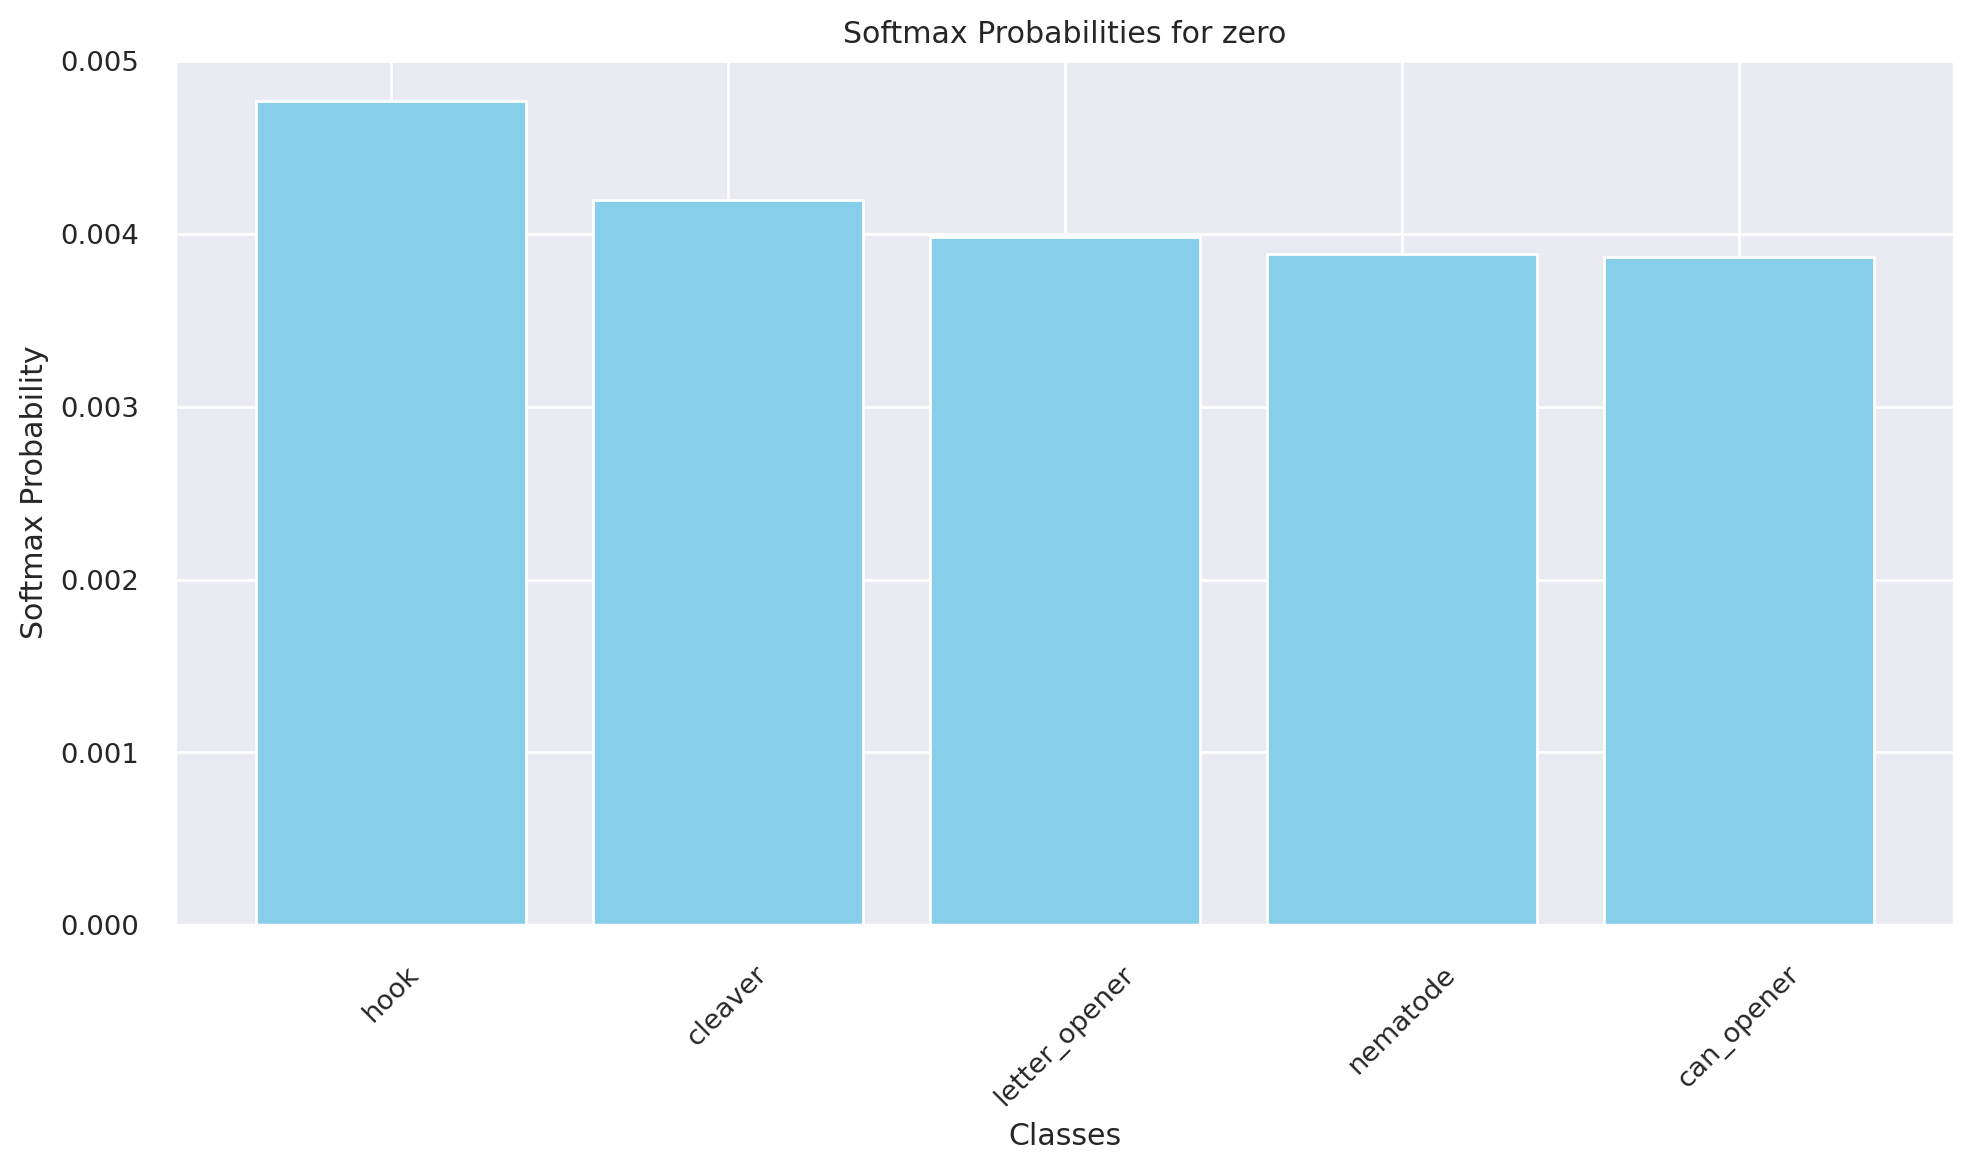

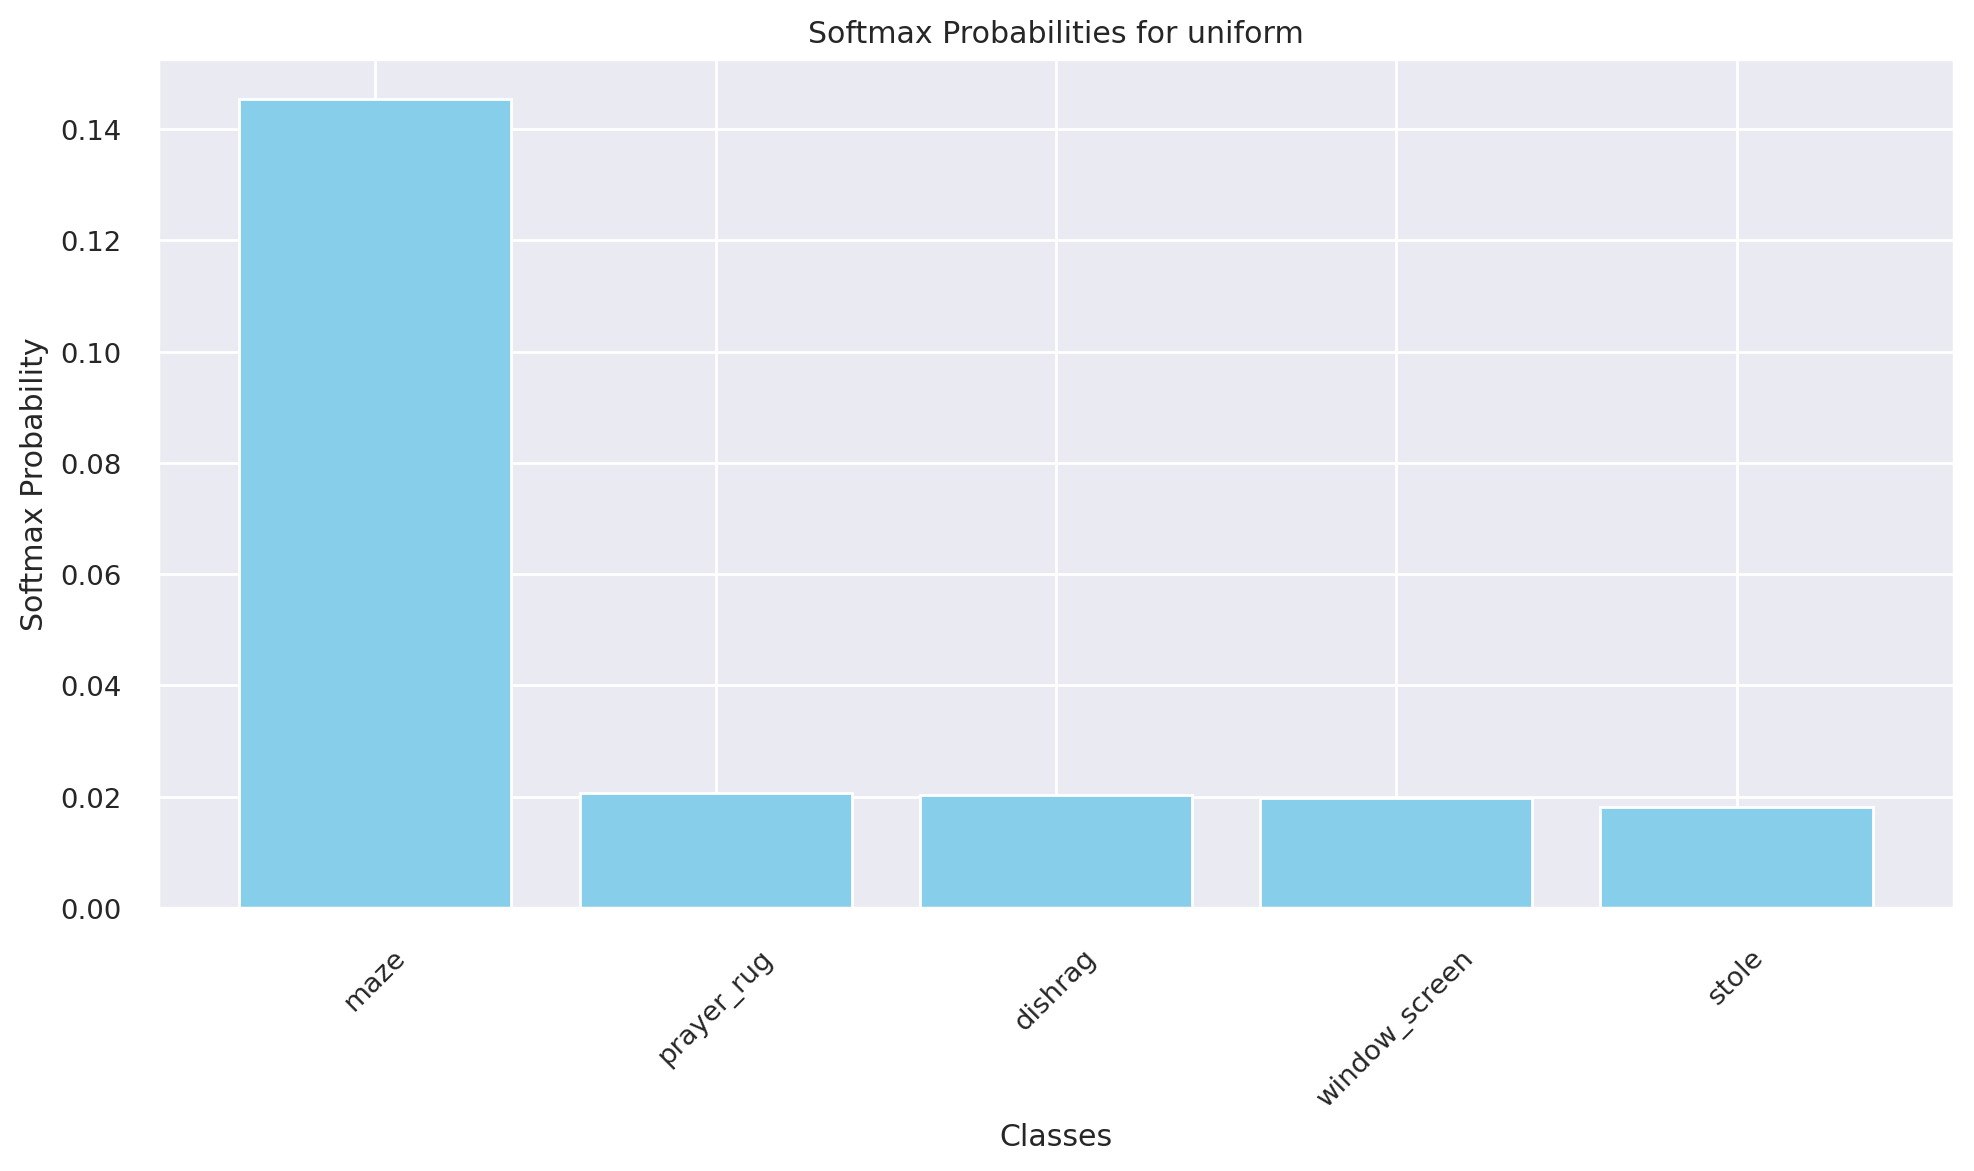

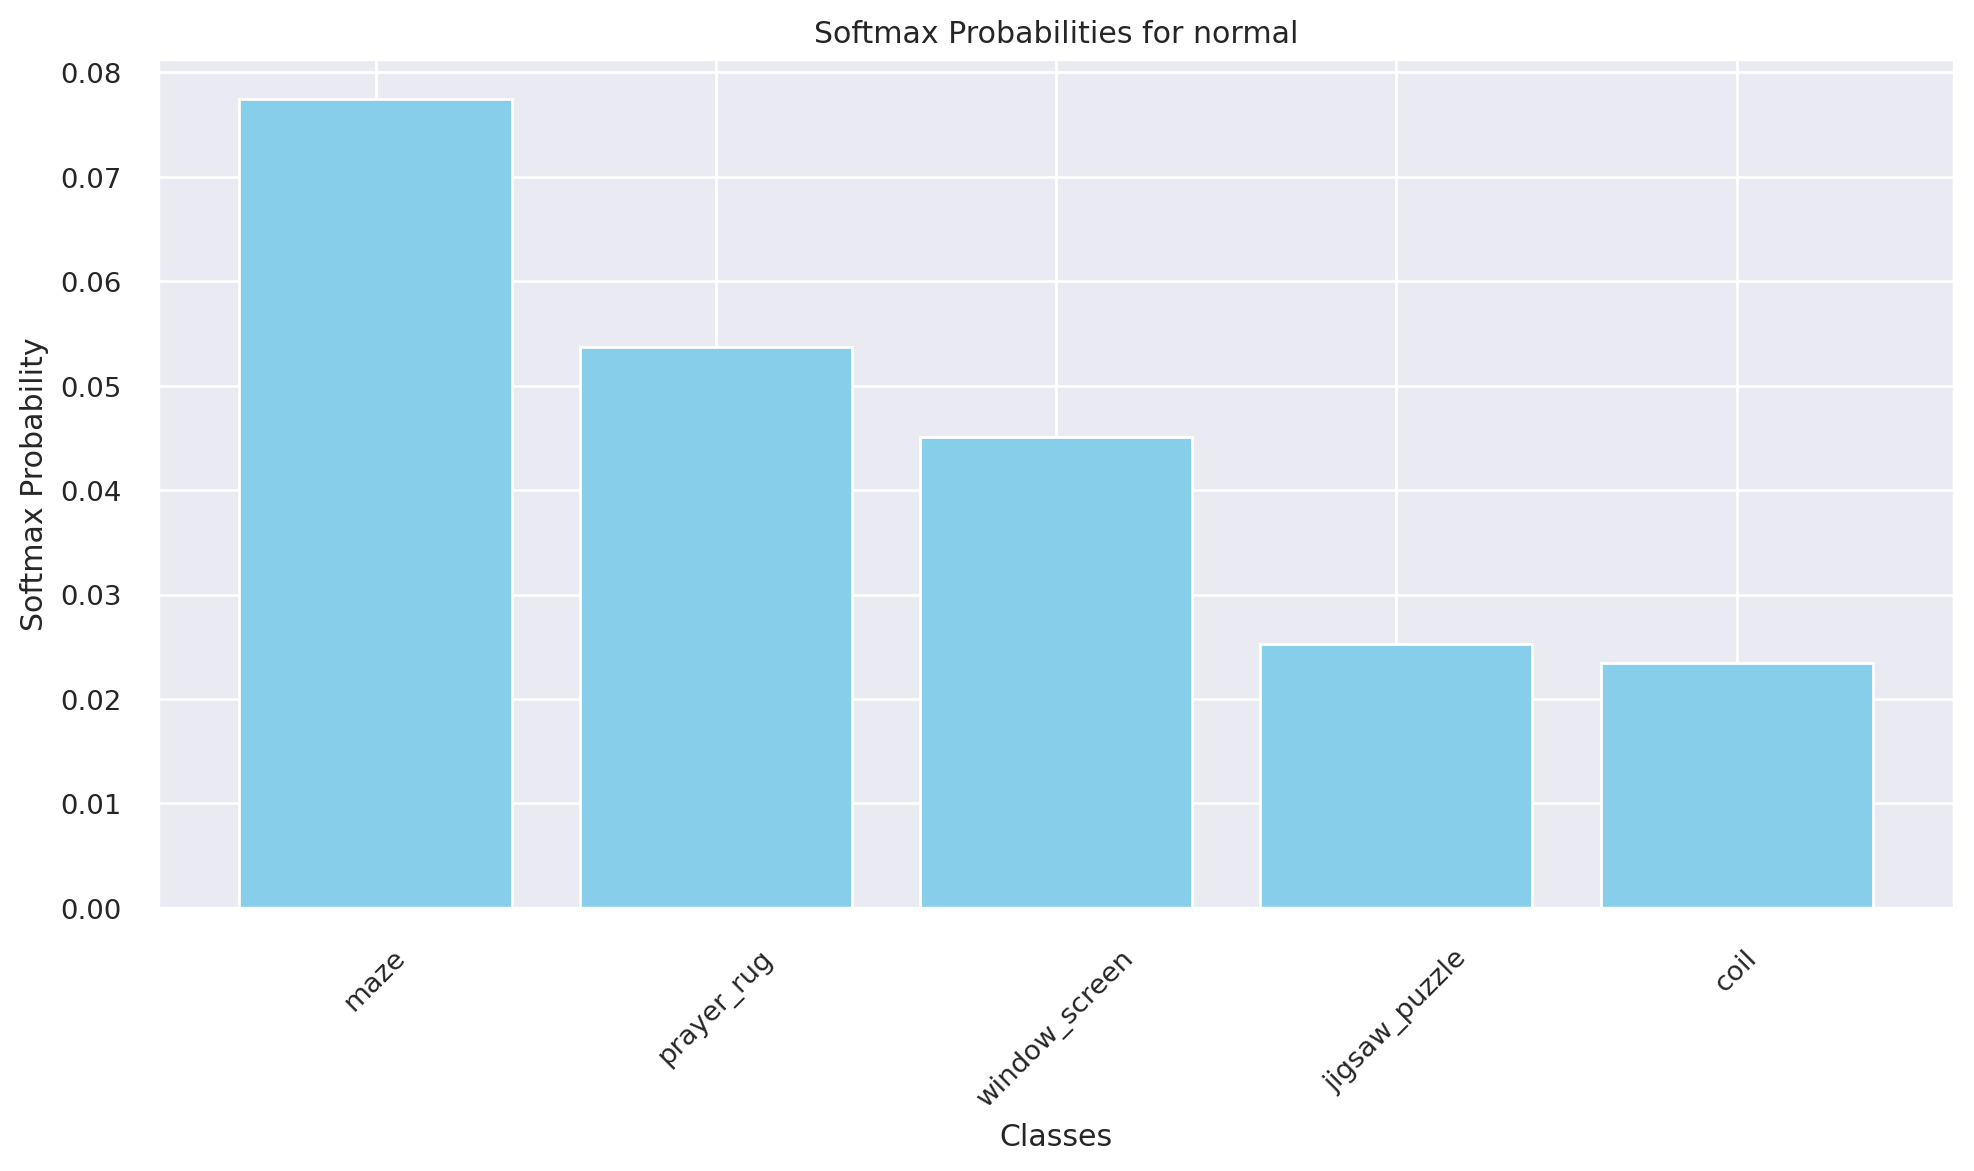

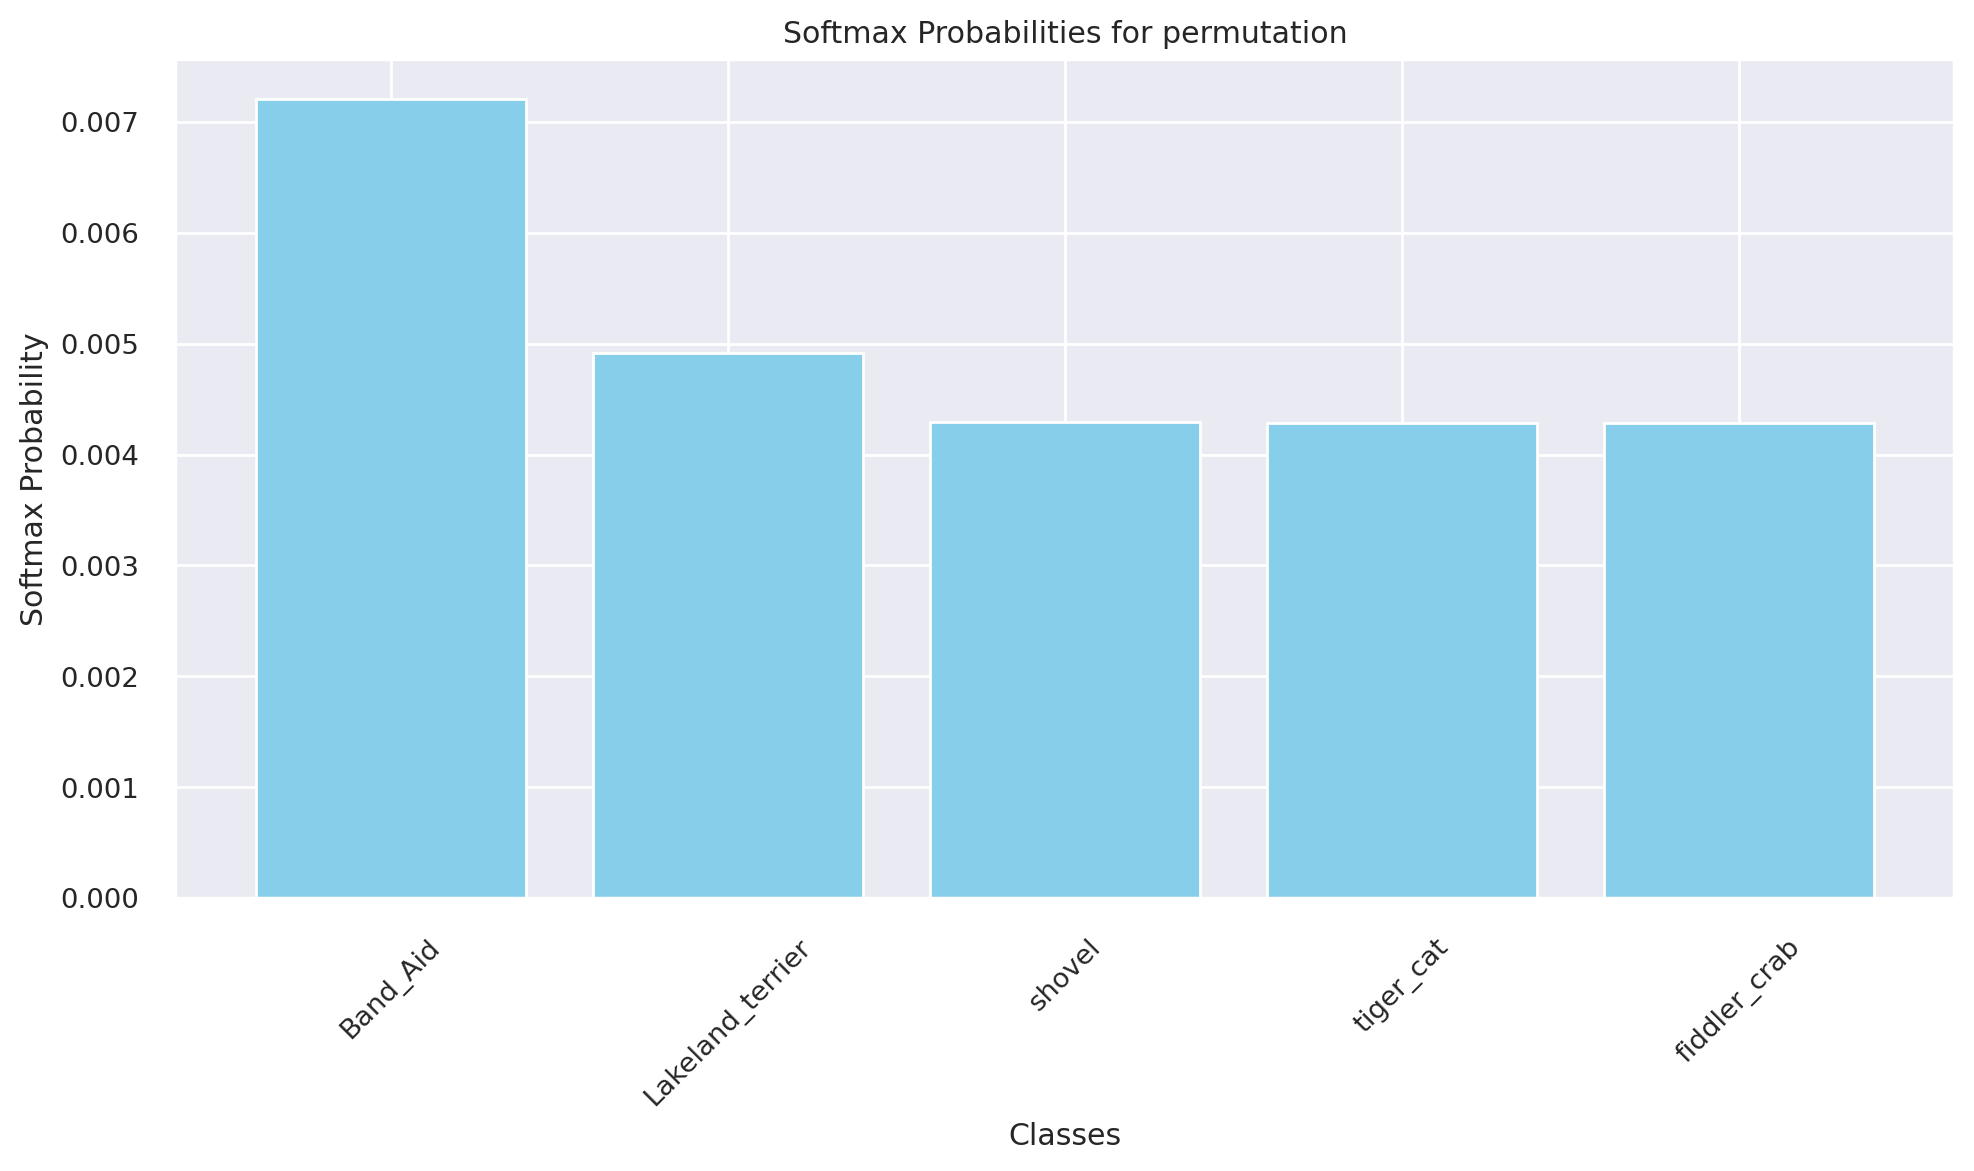

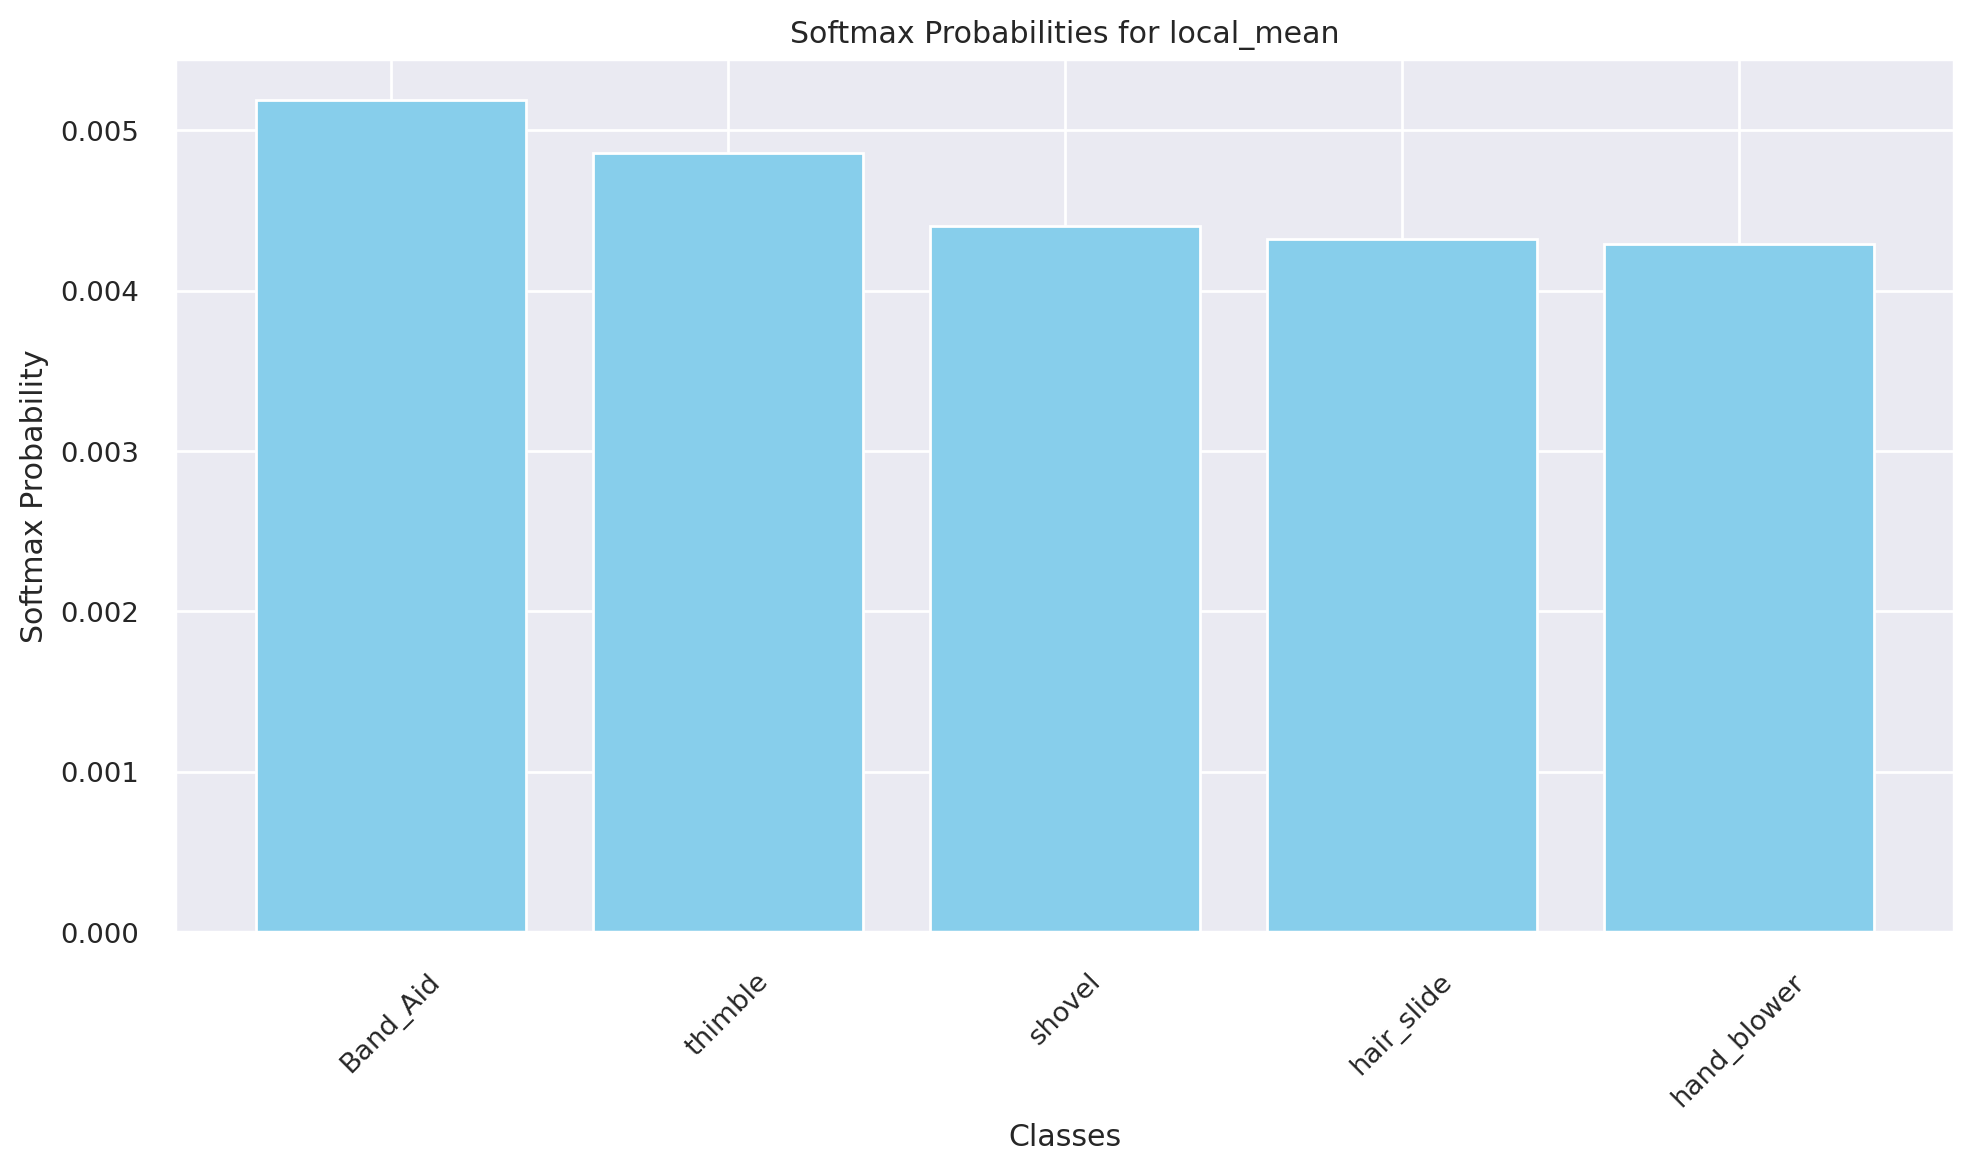

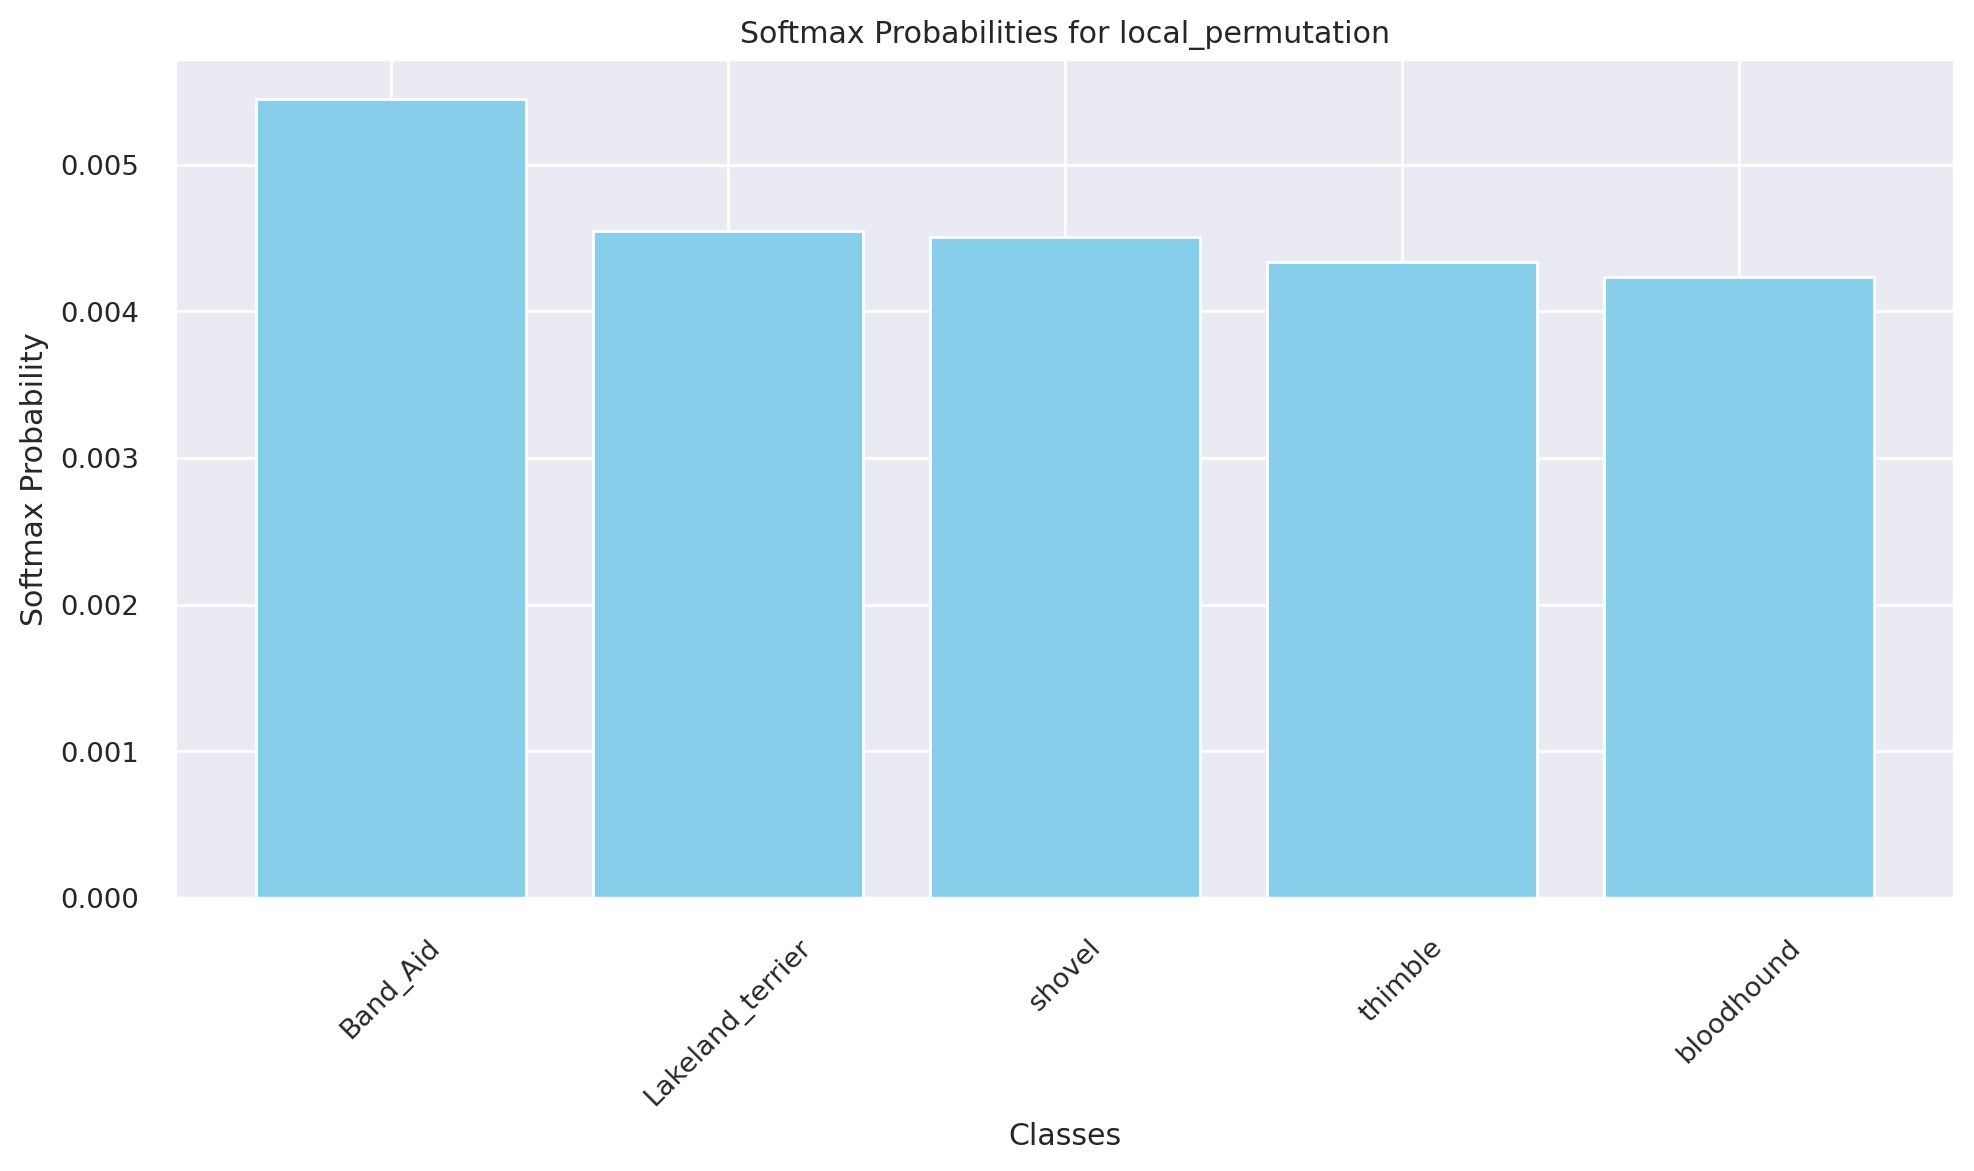

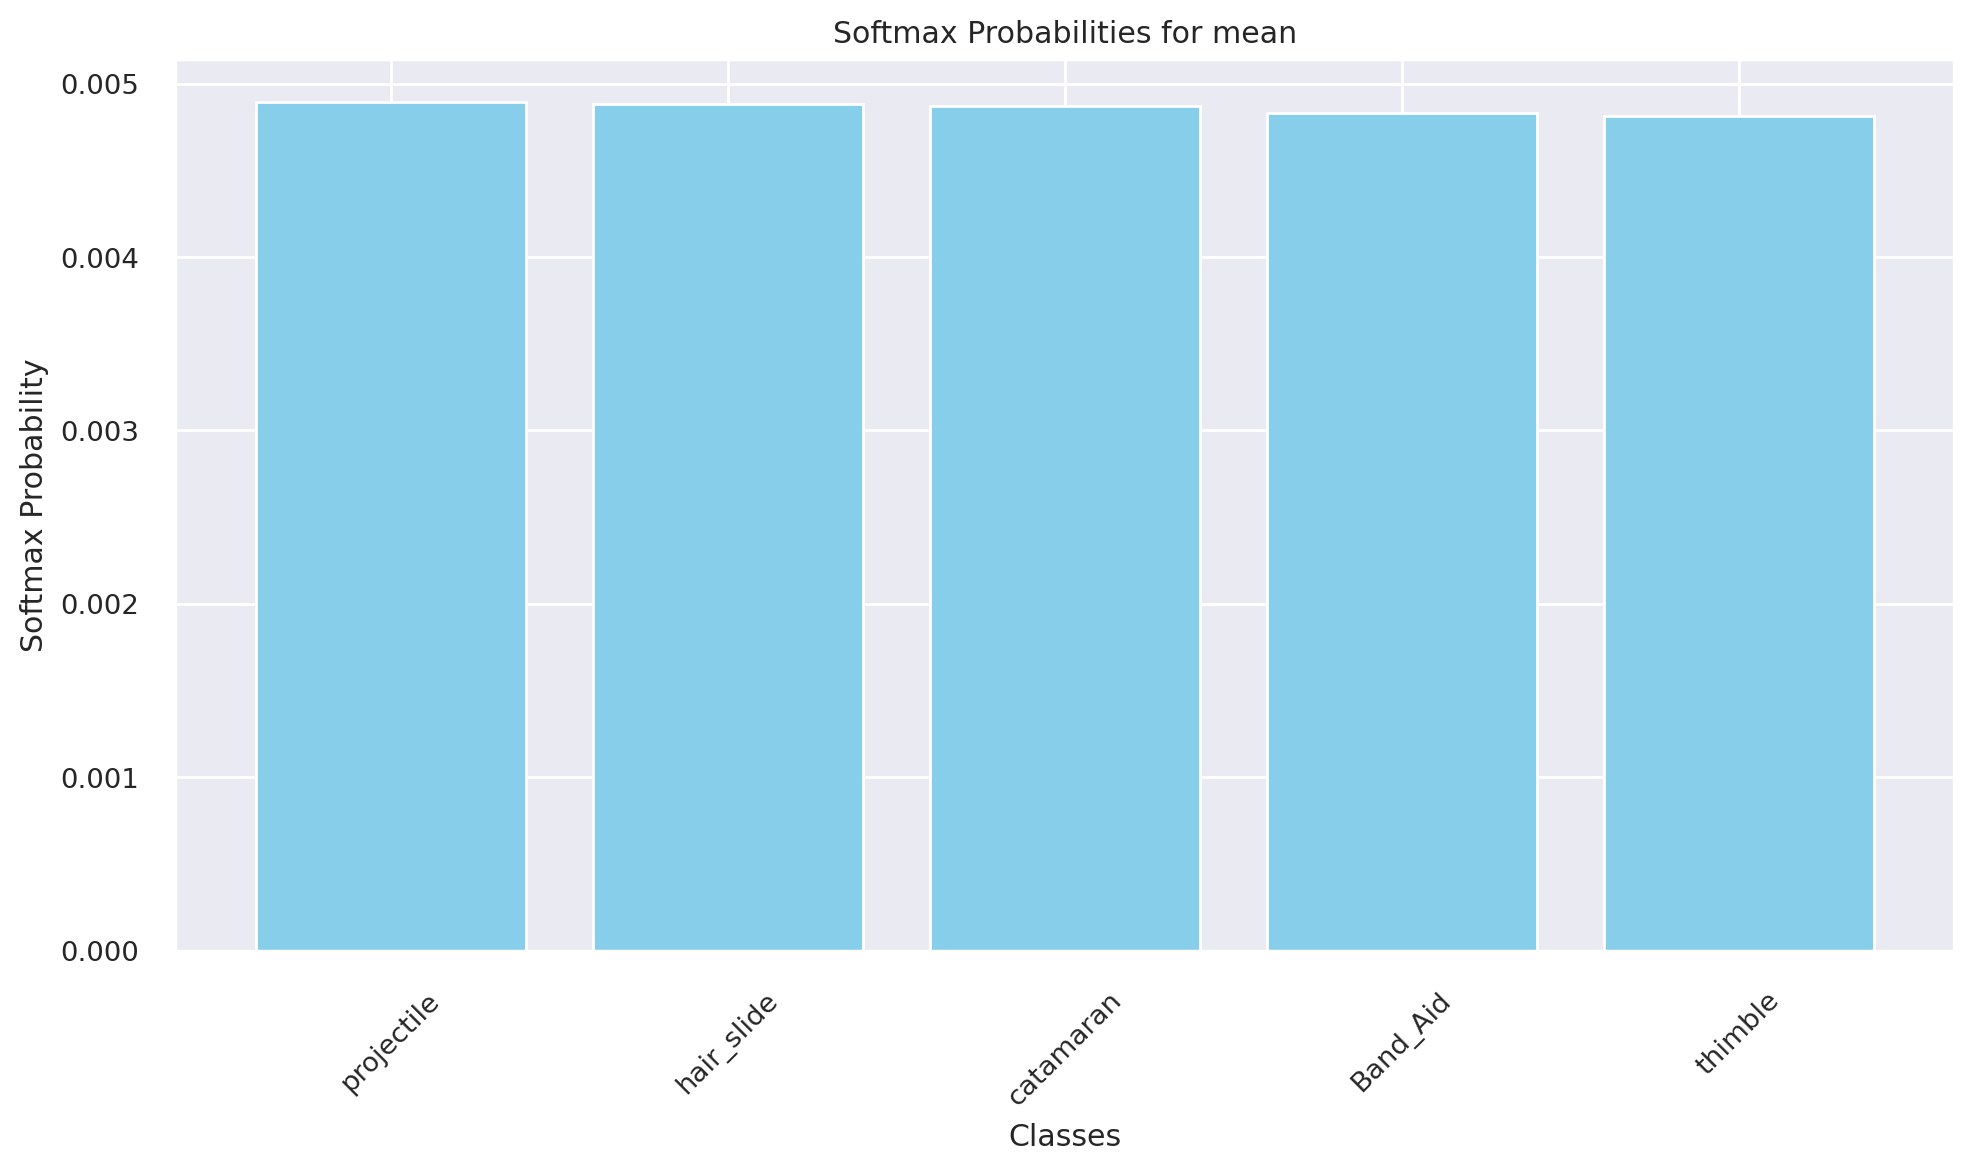

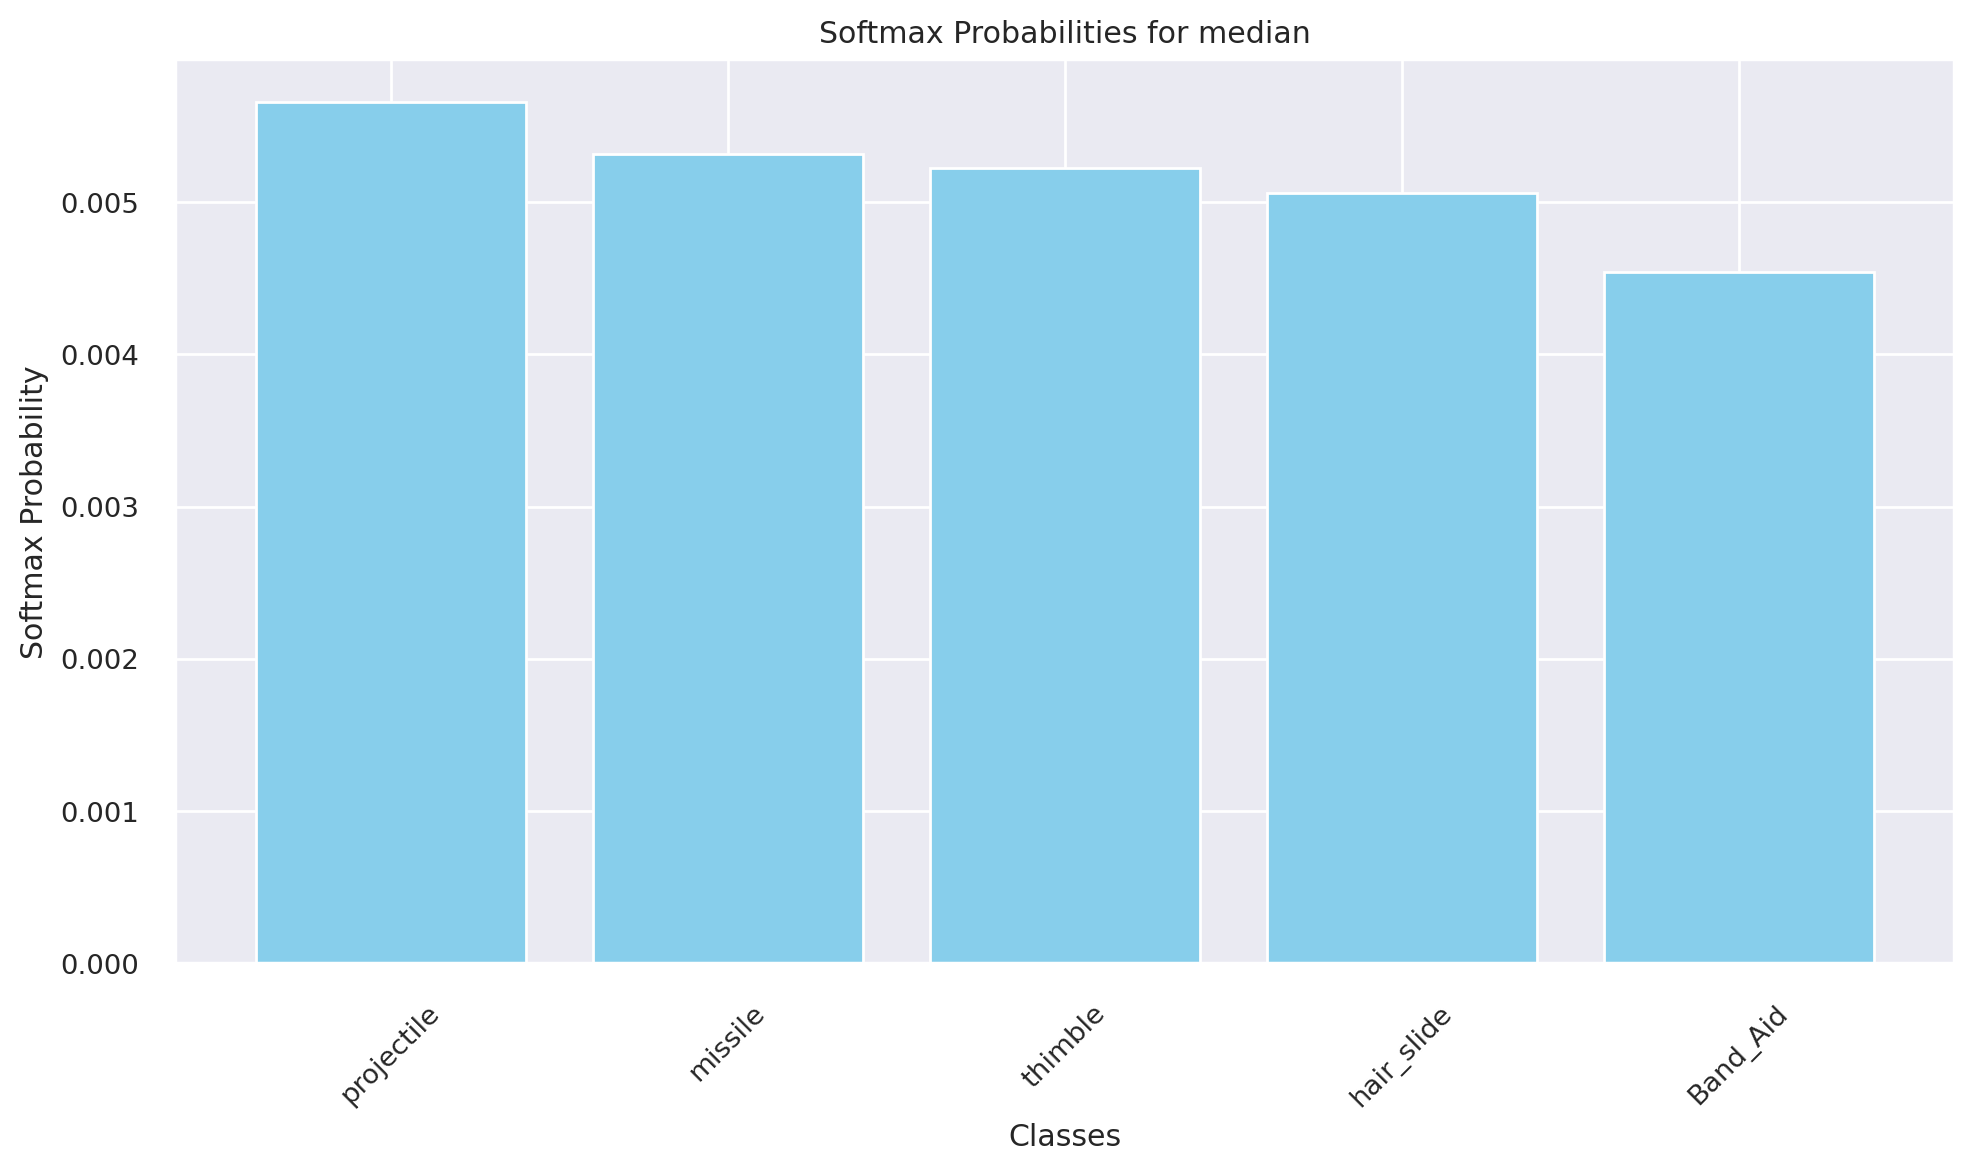

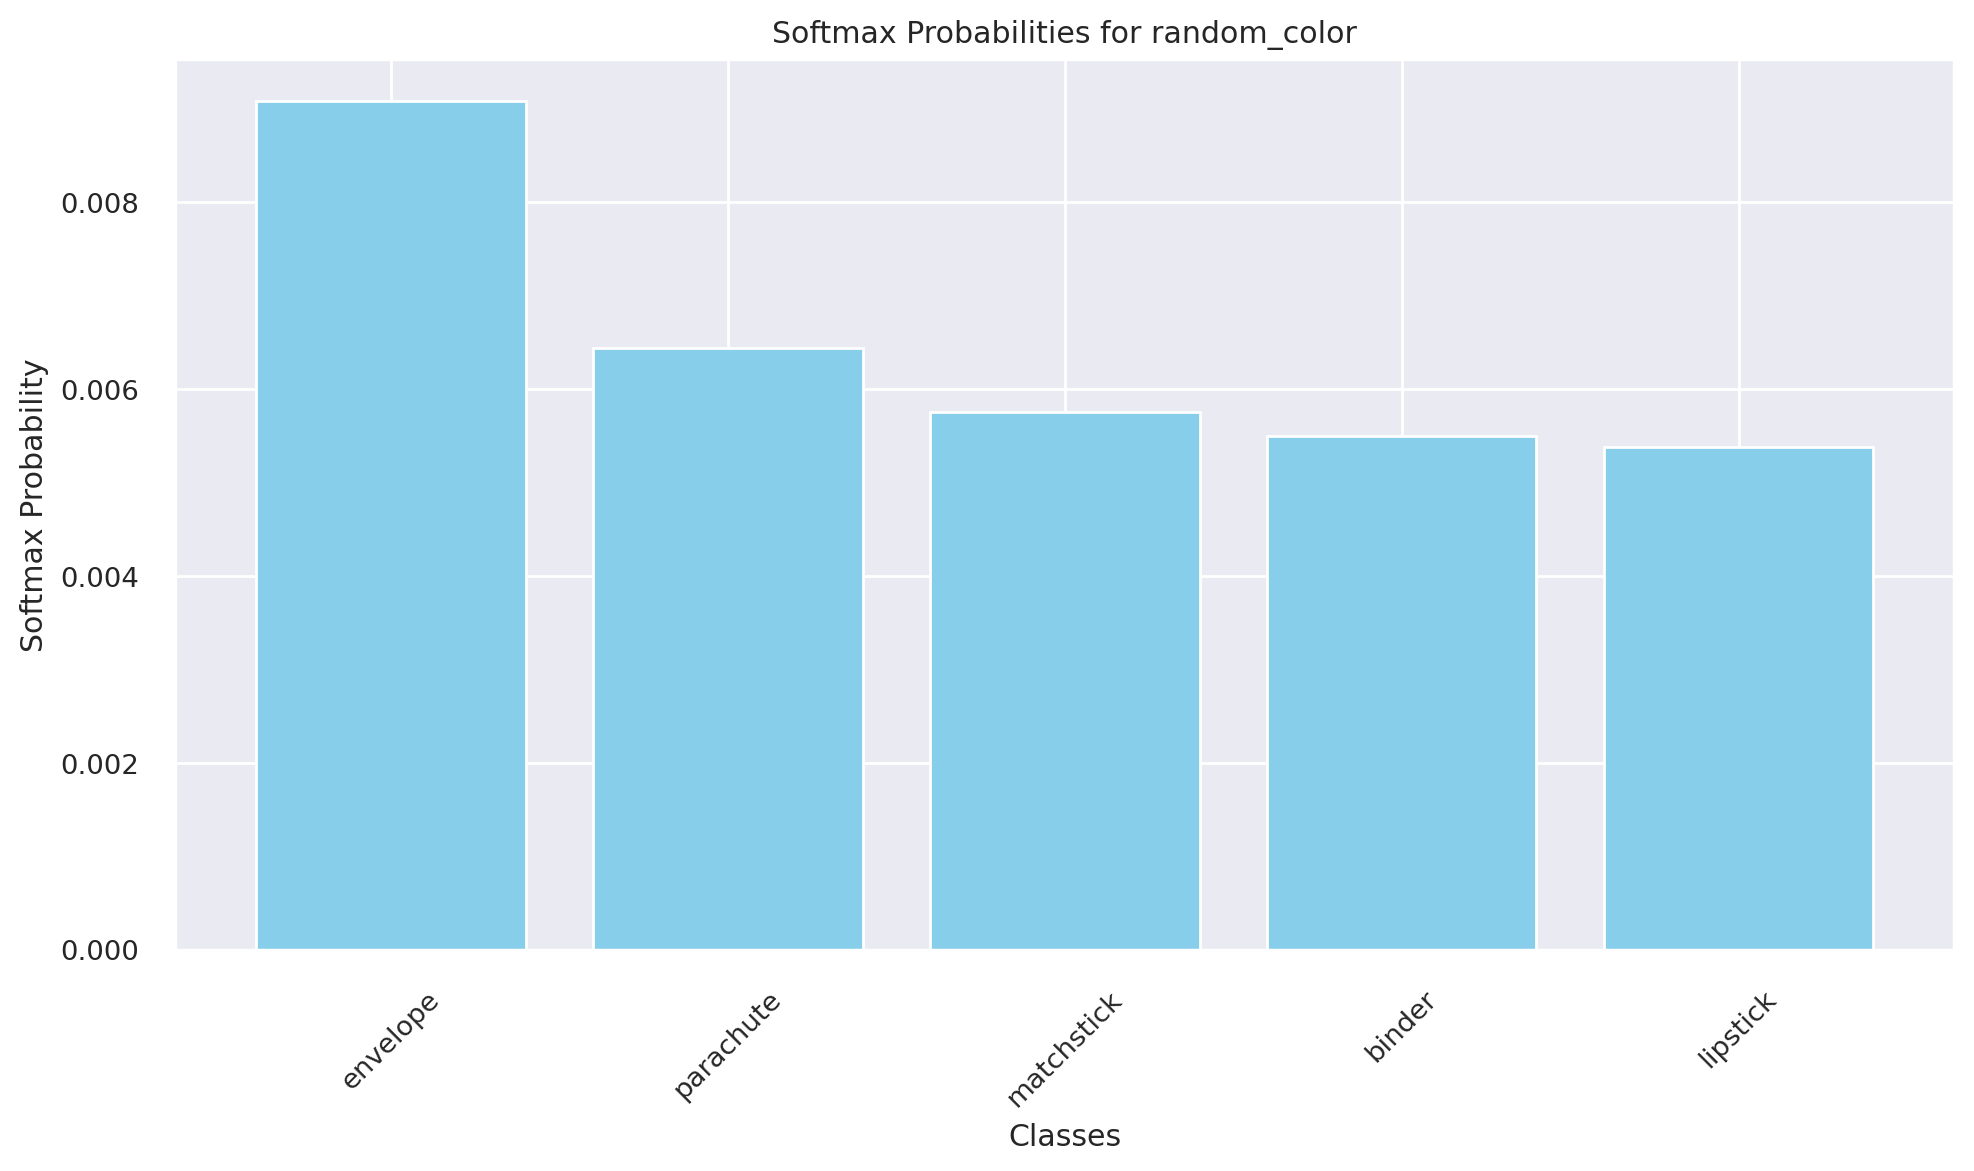

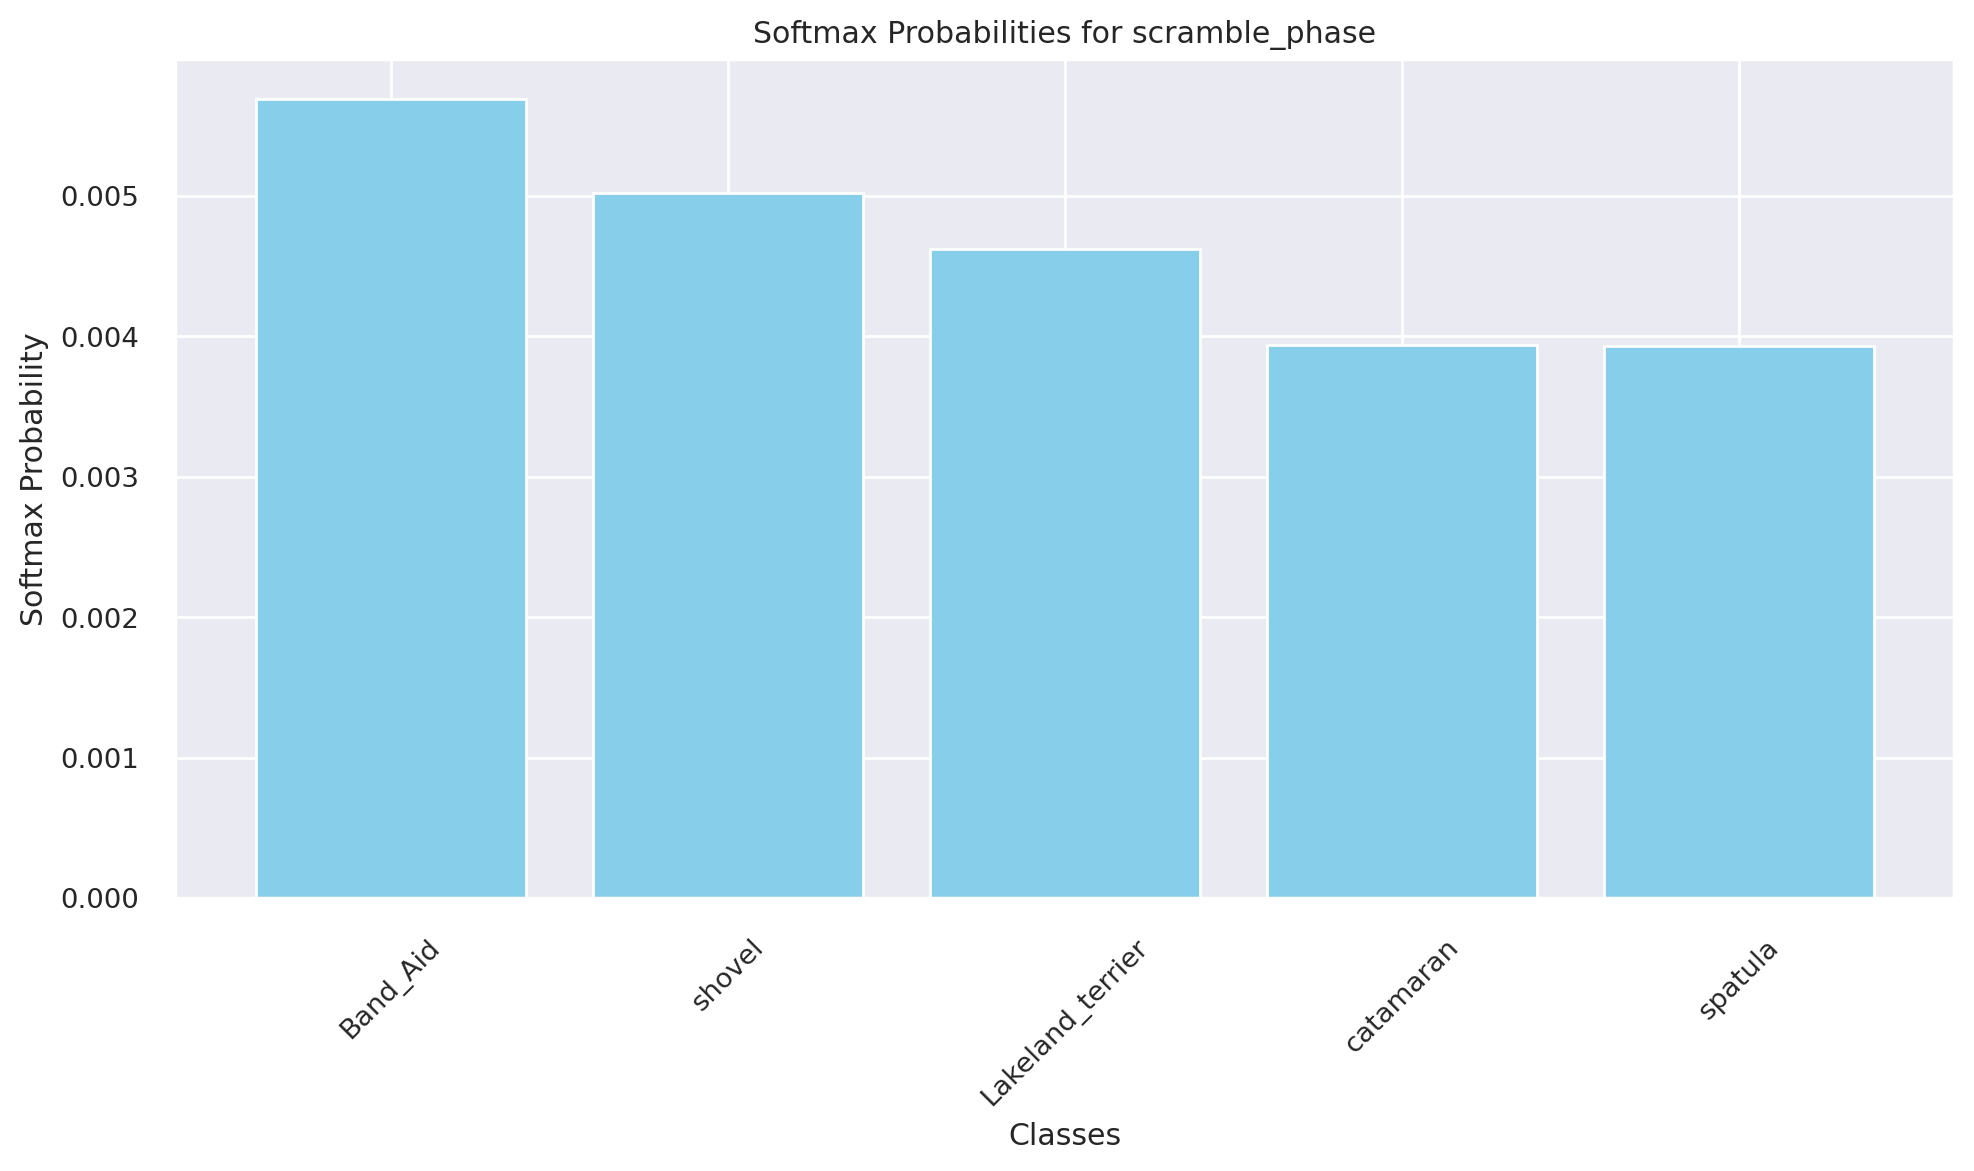

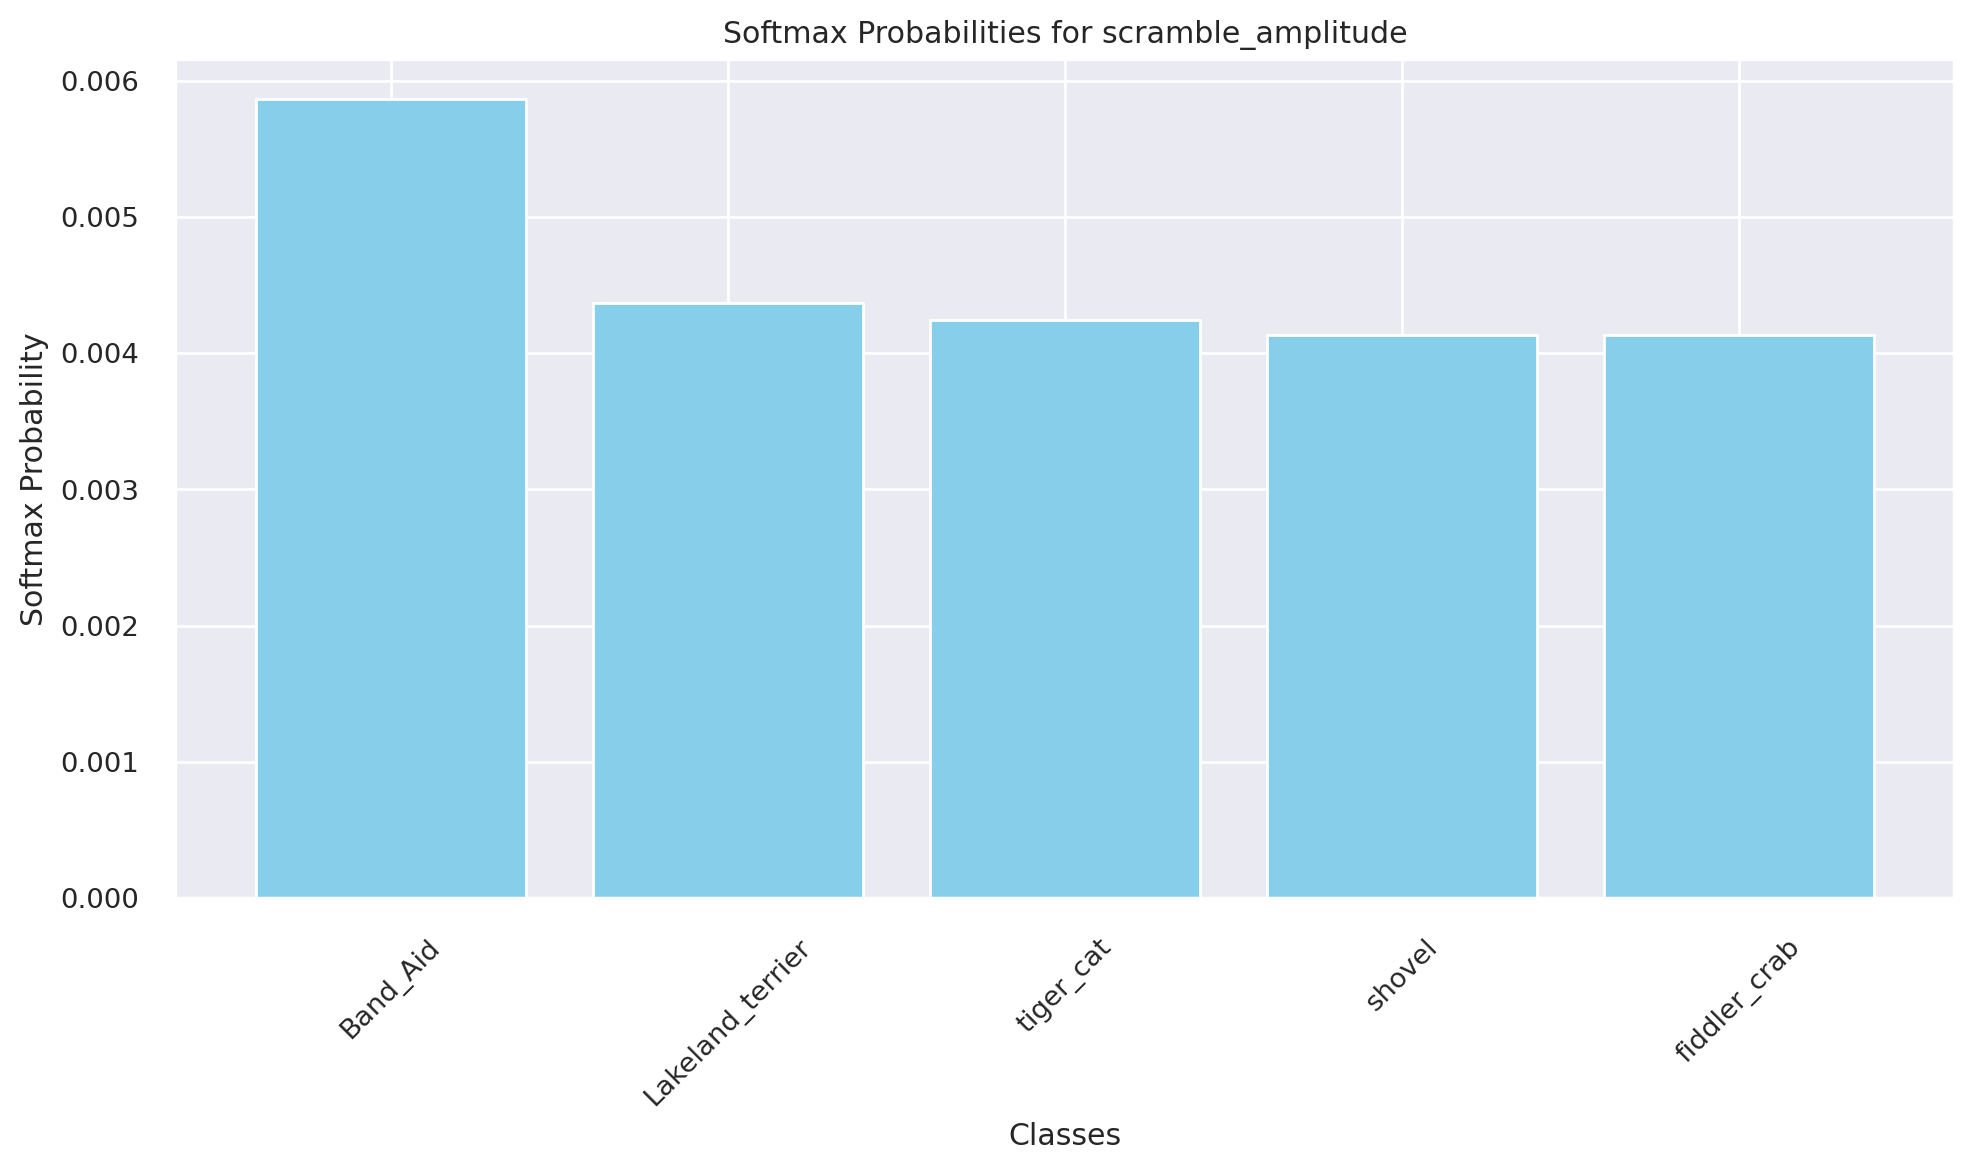

In [ ]:
plot_softmax_classes(classifications_vit)

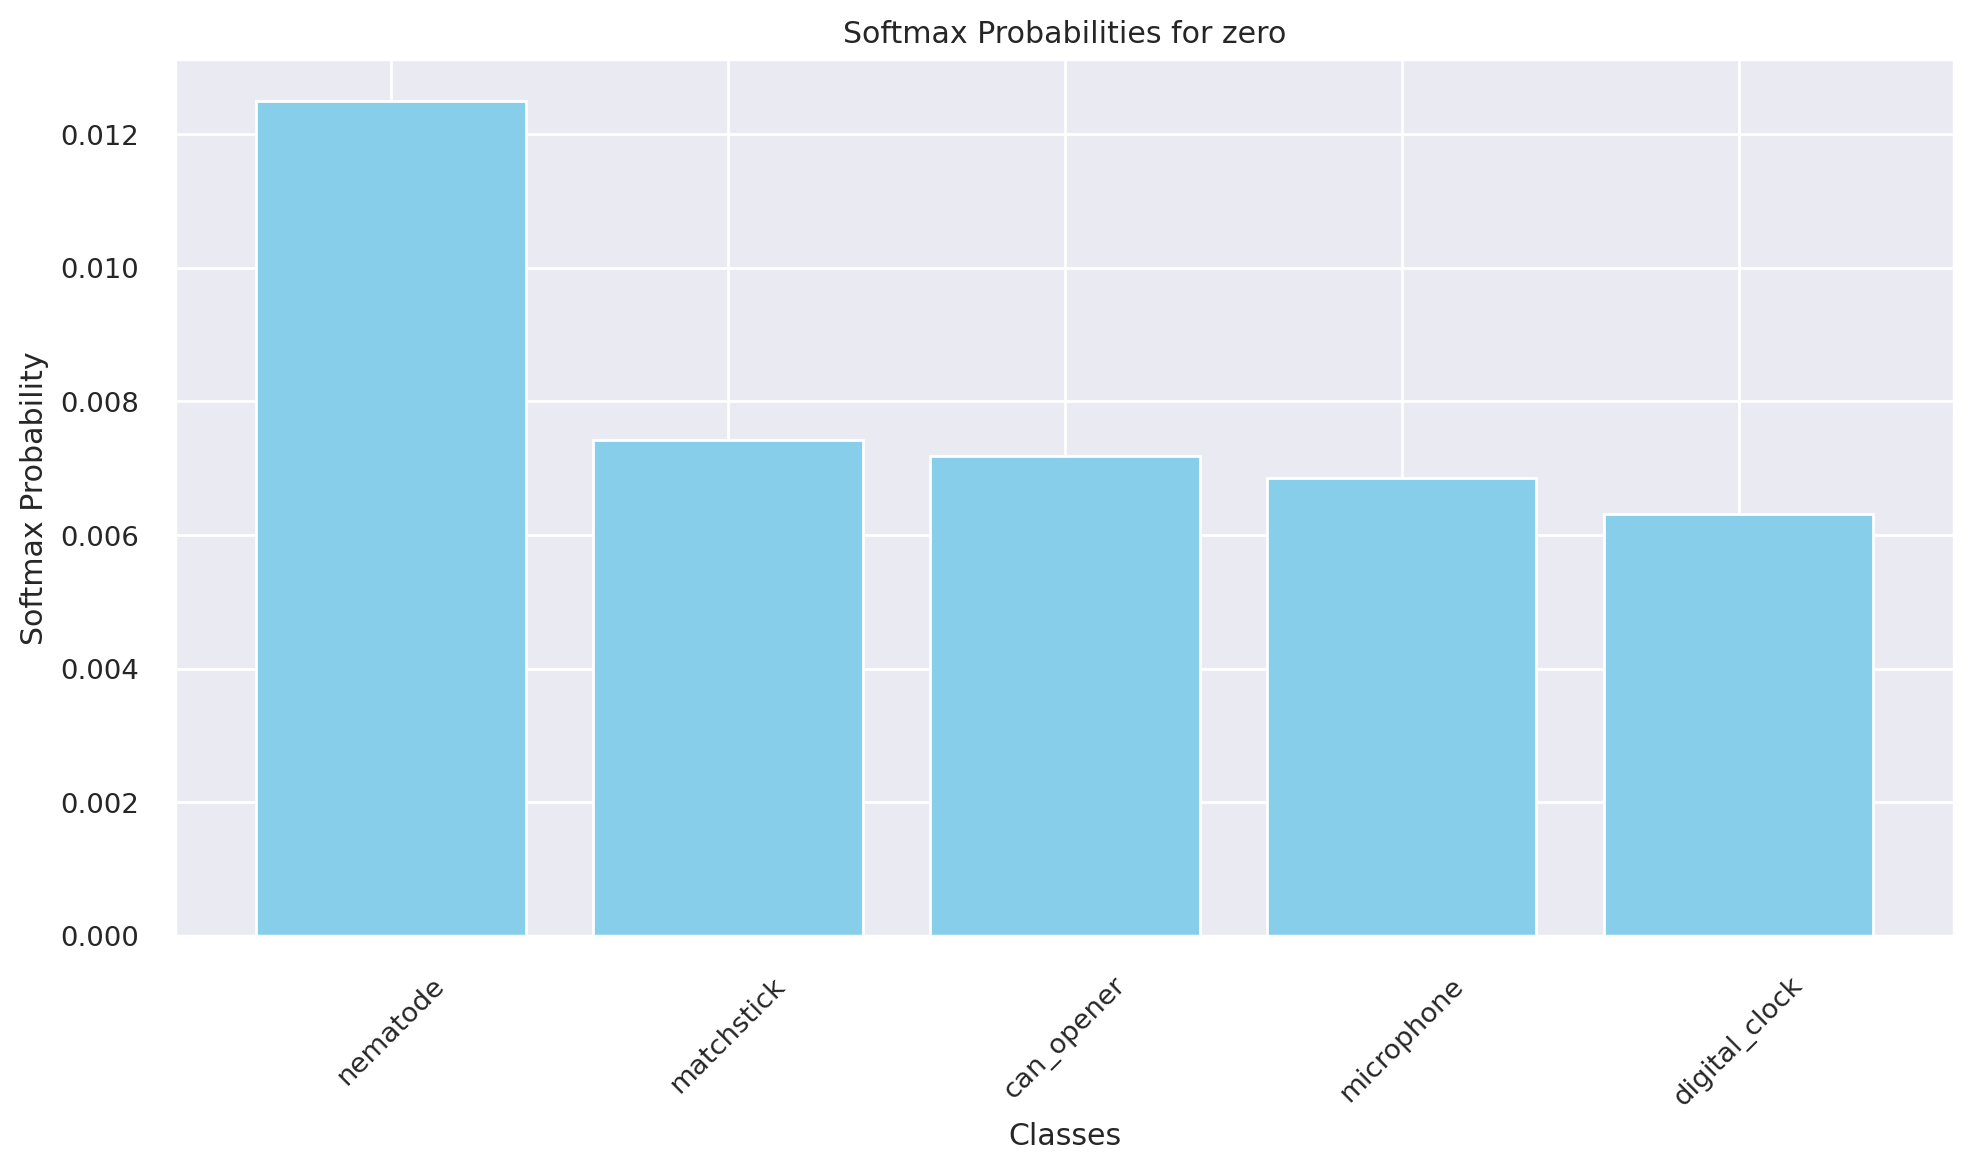

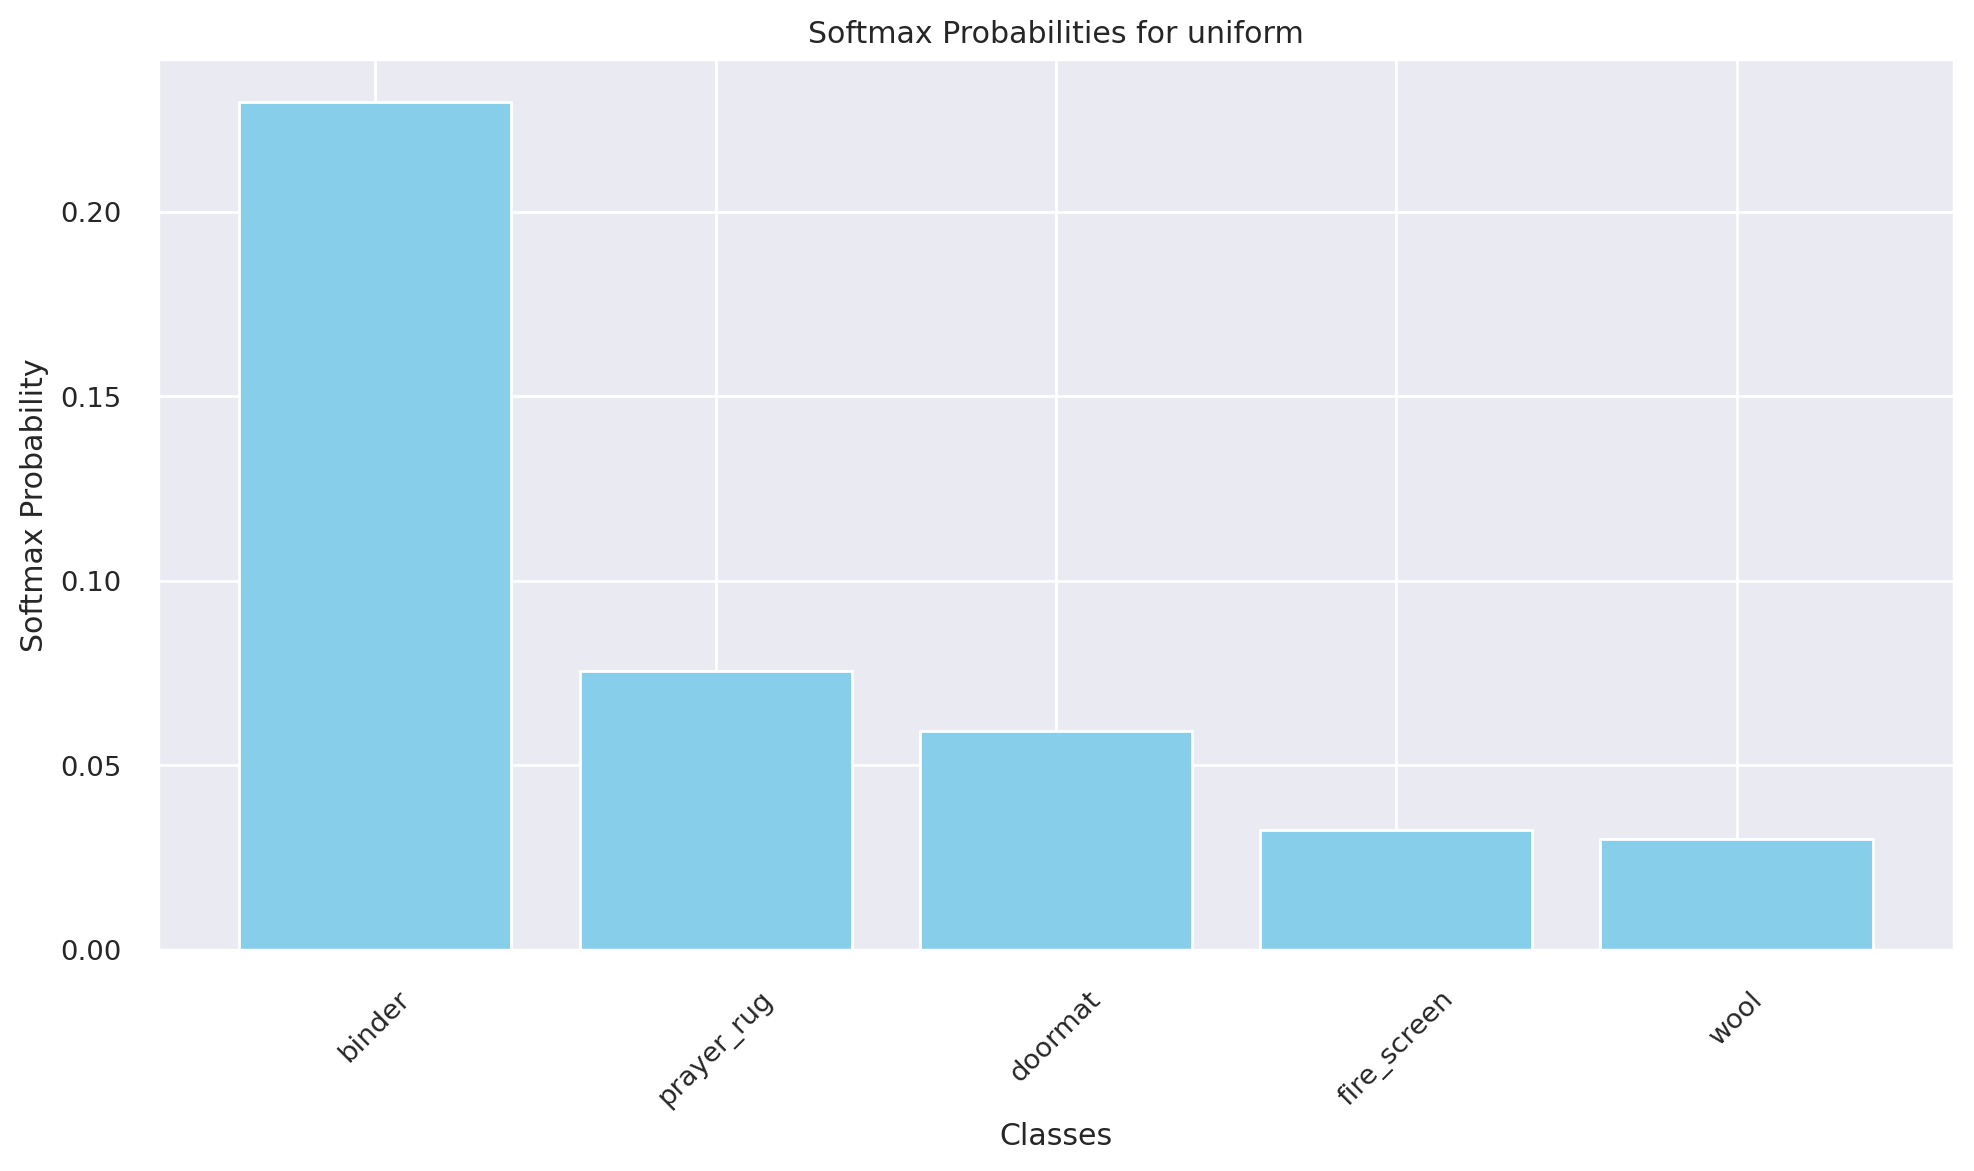

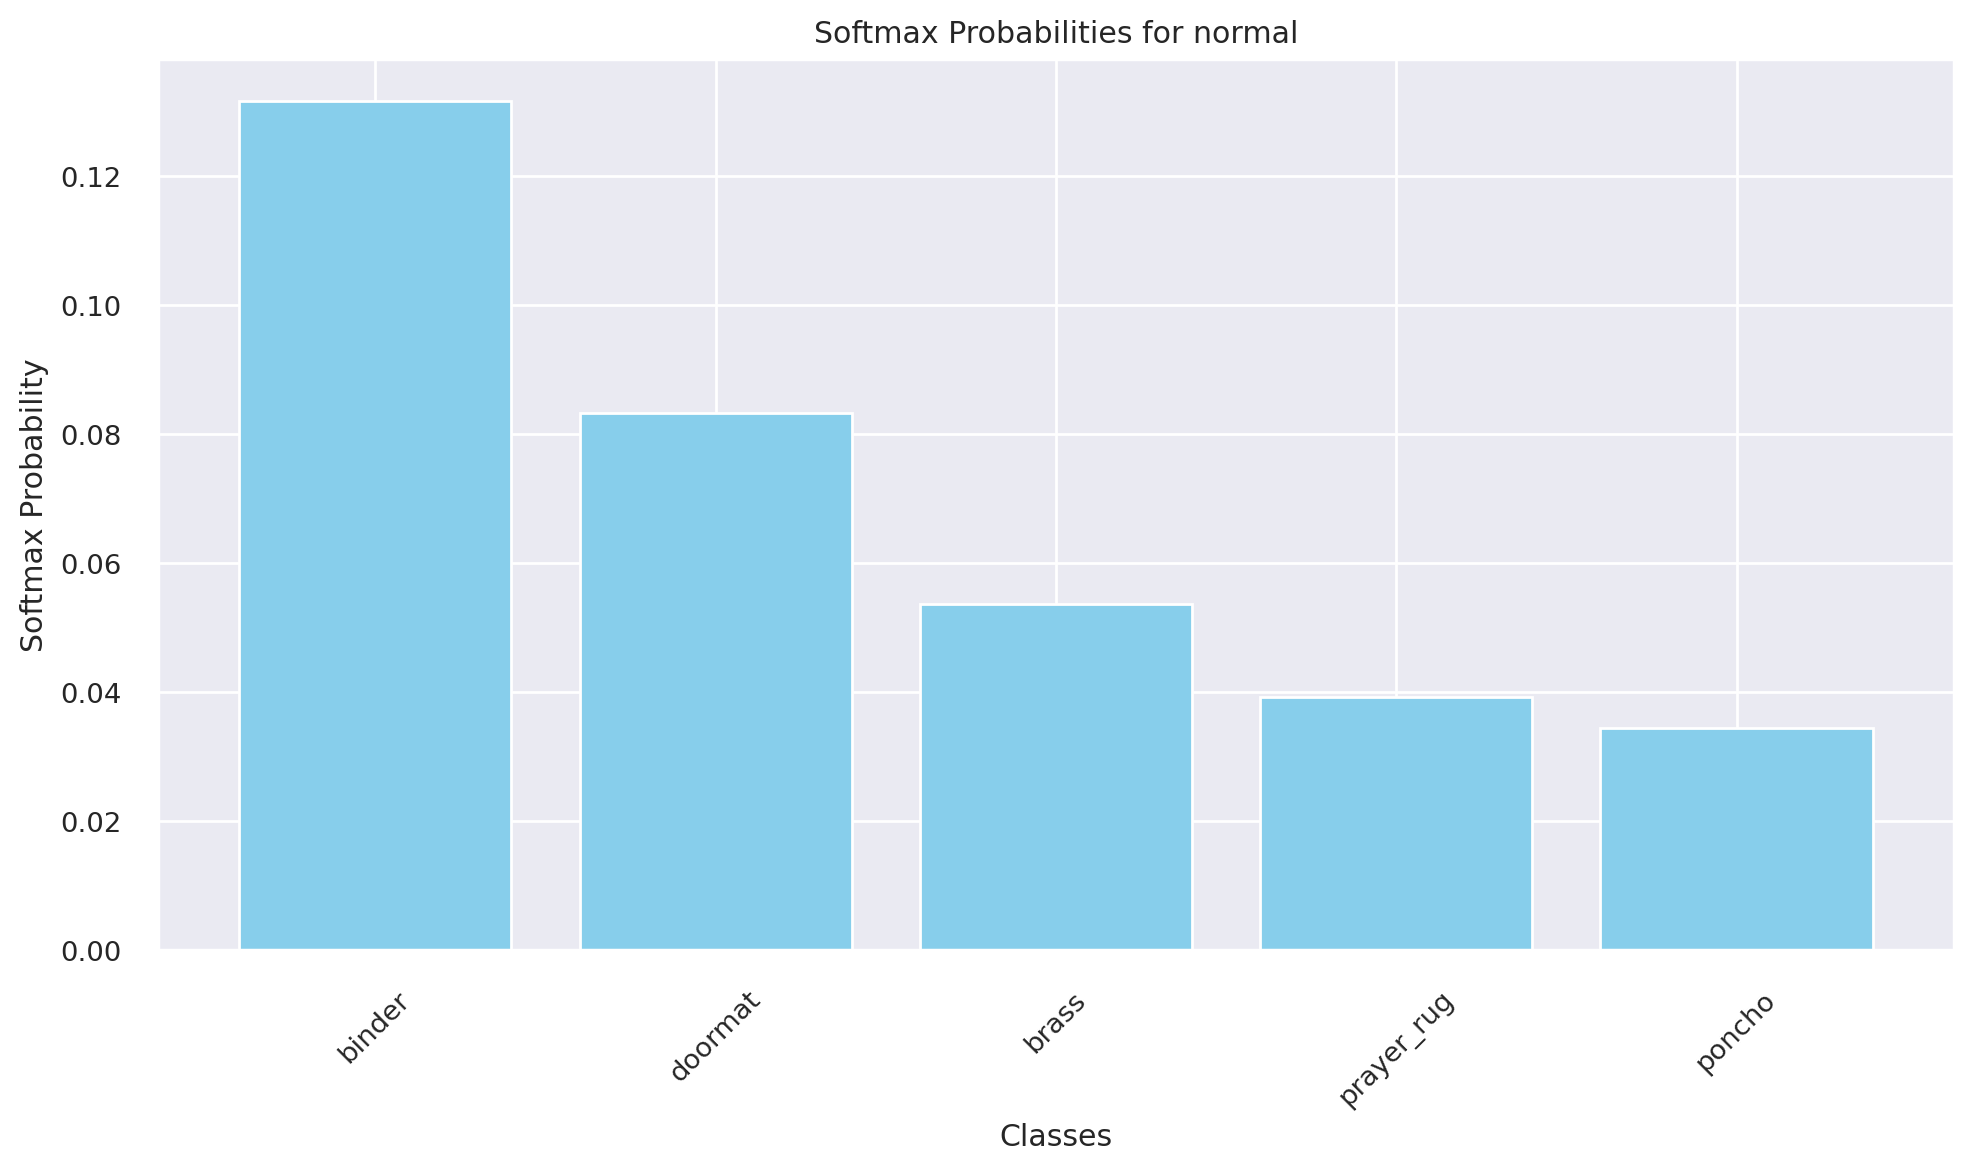

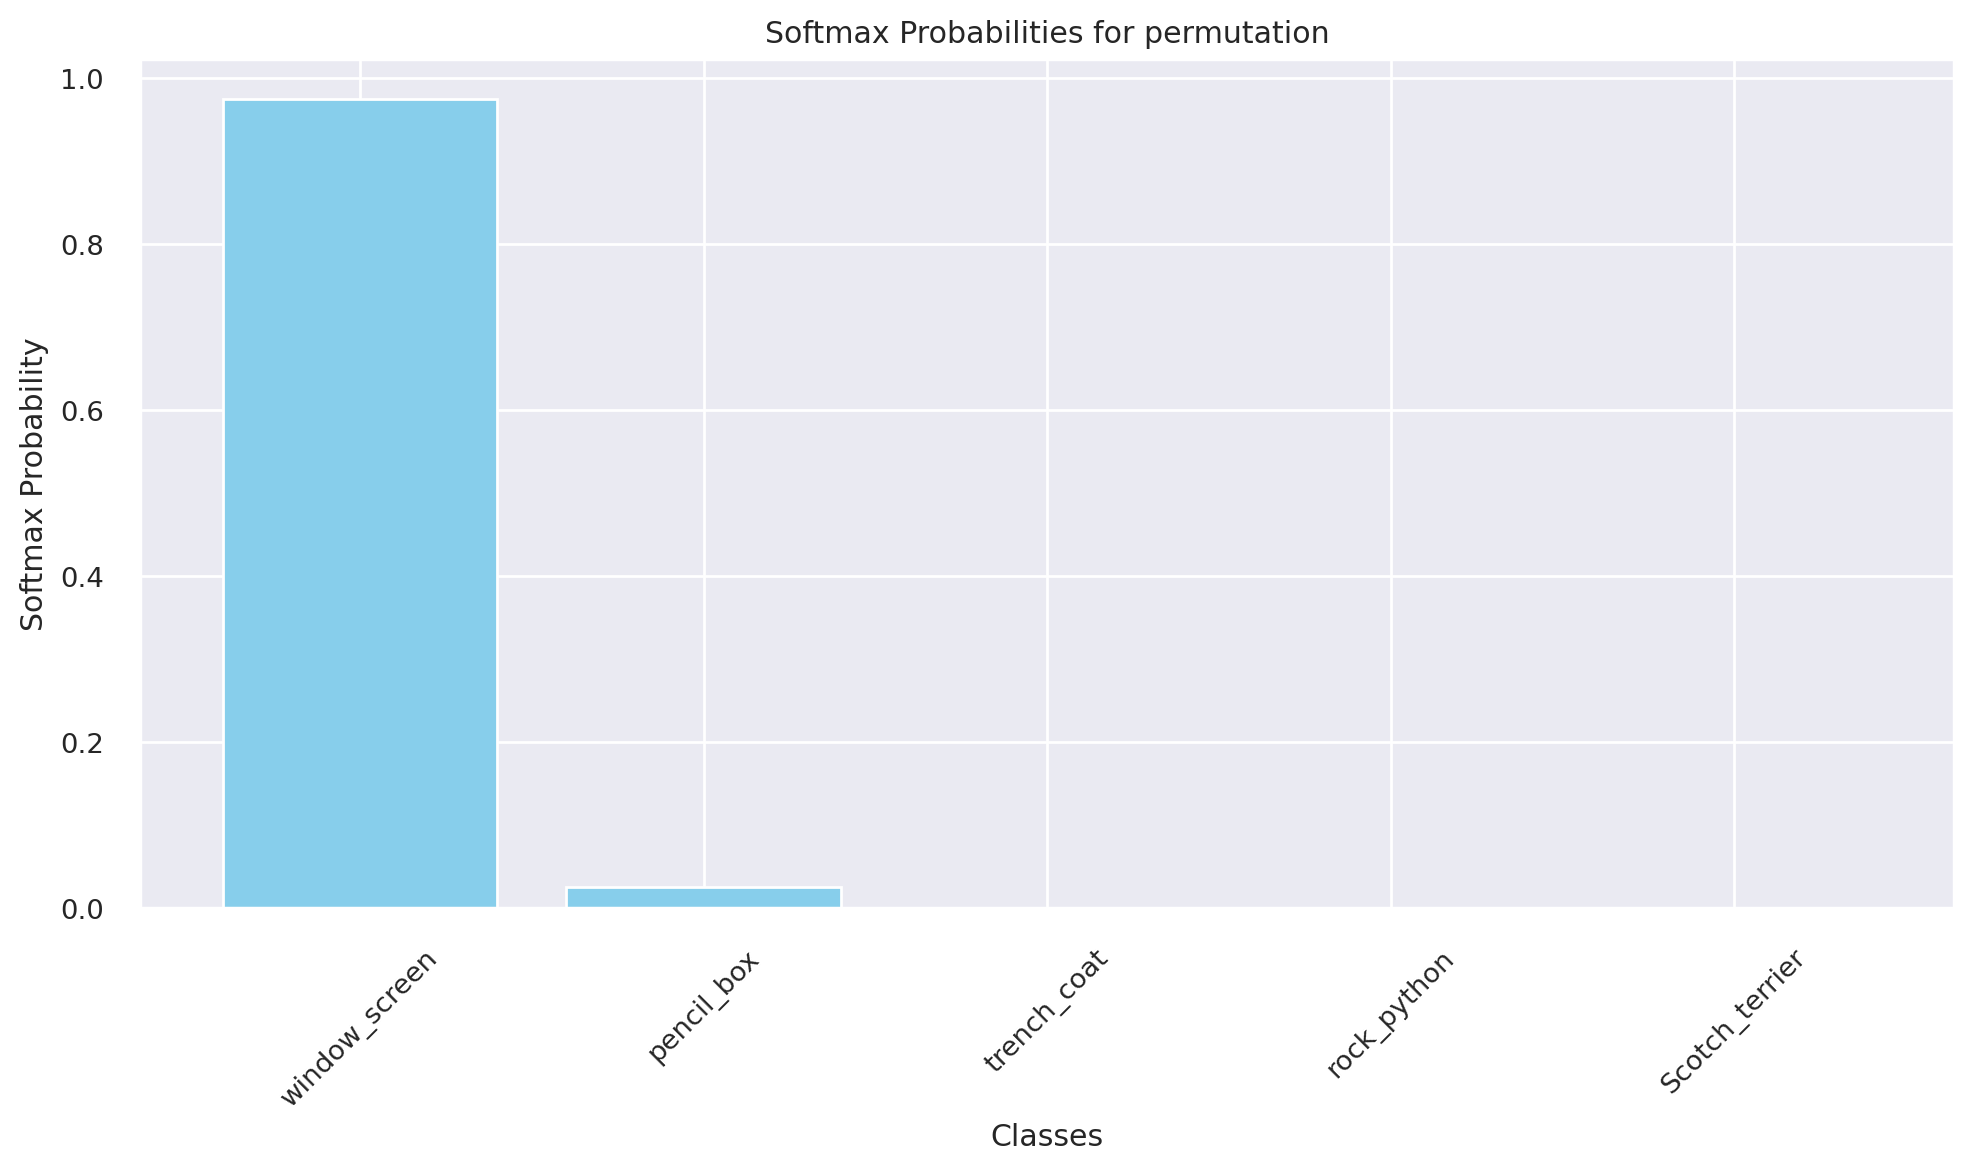

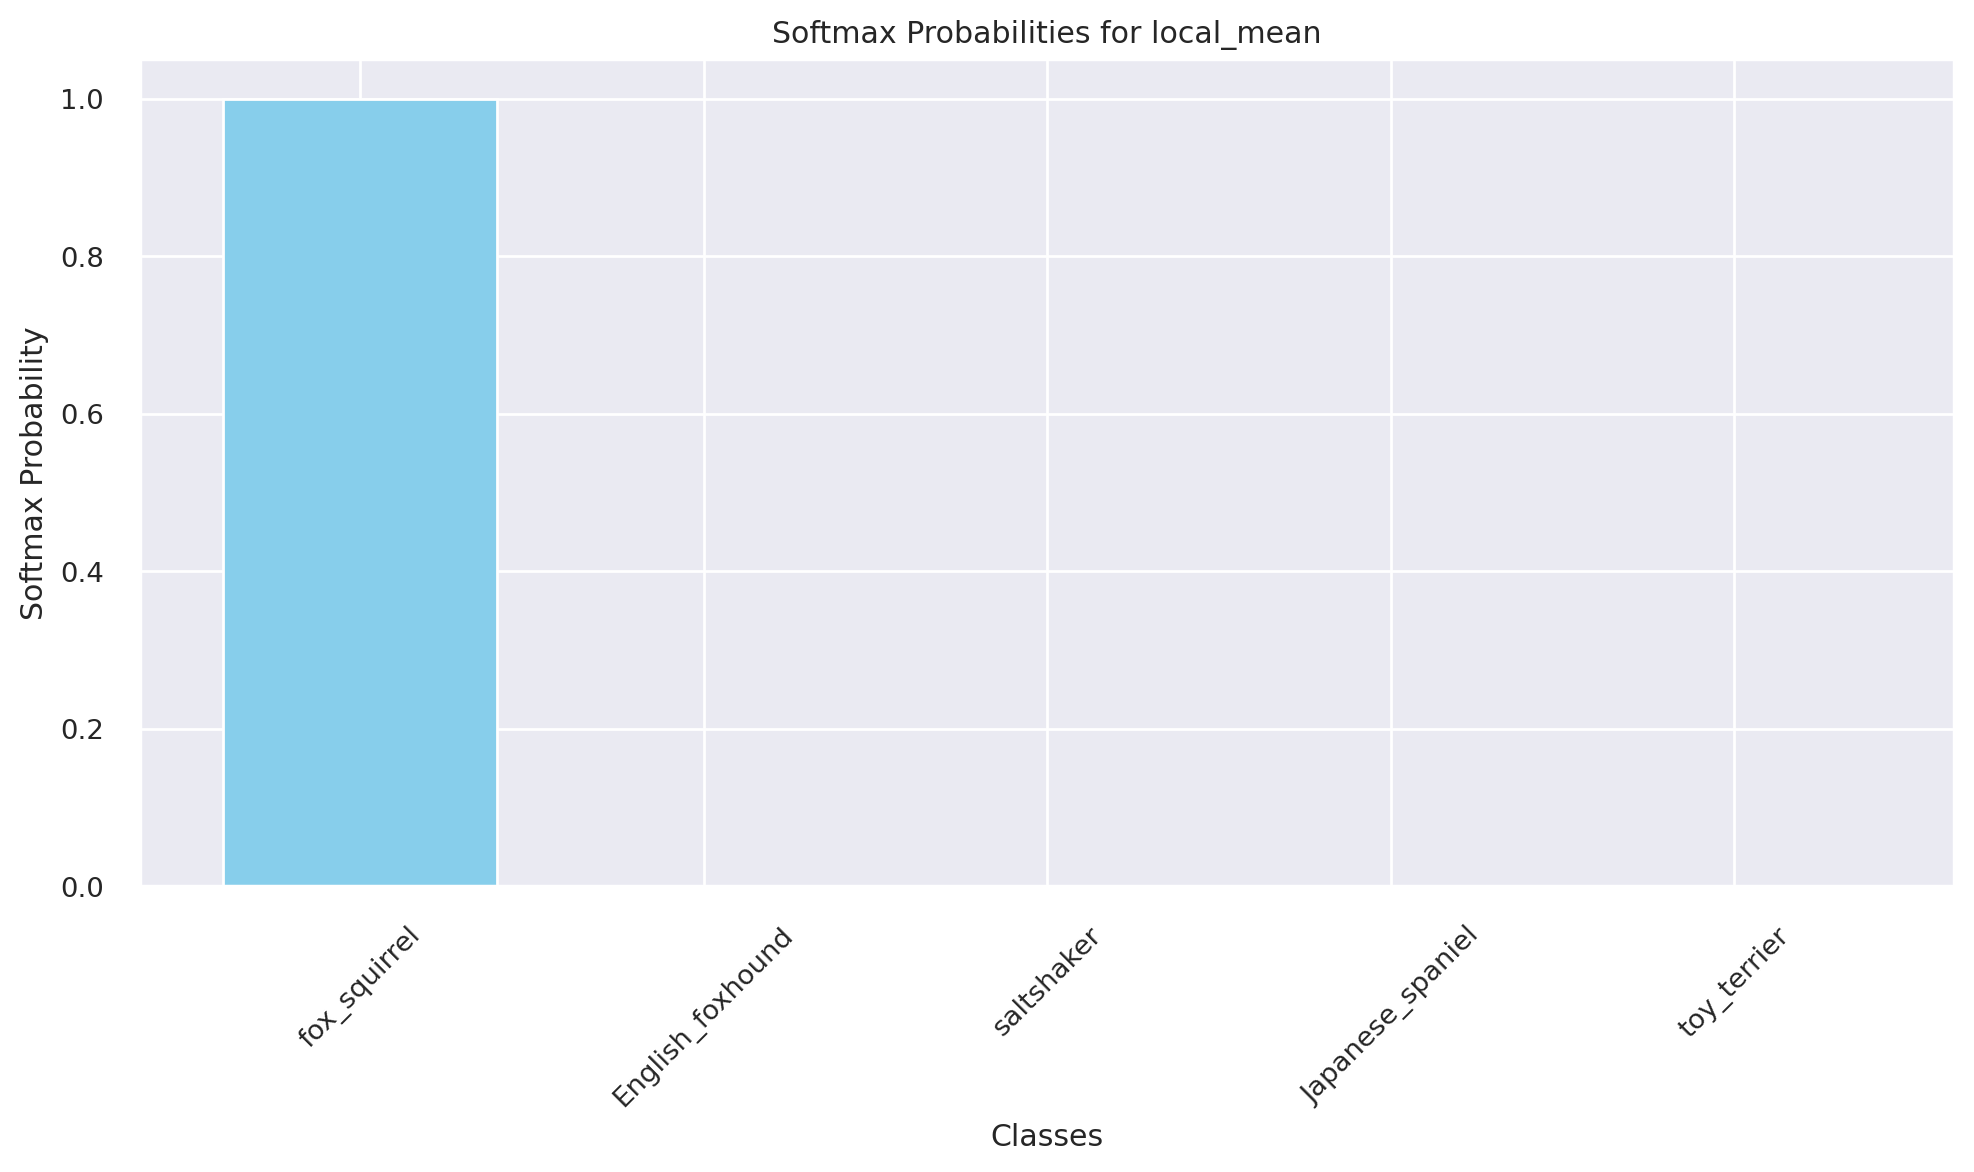

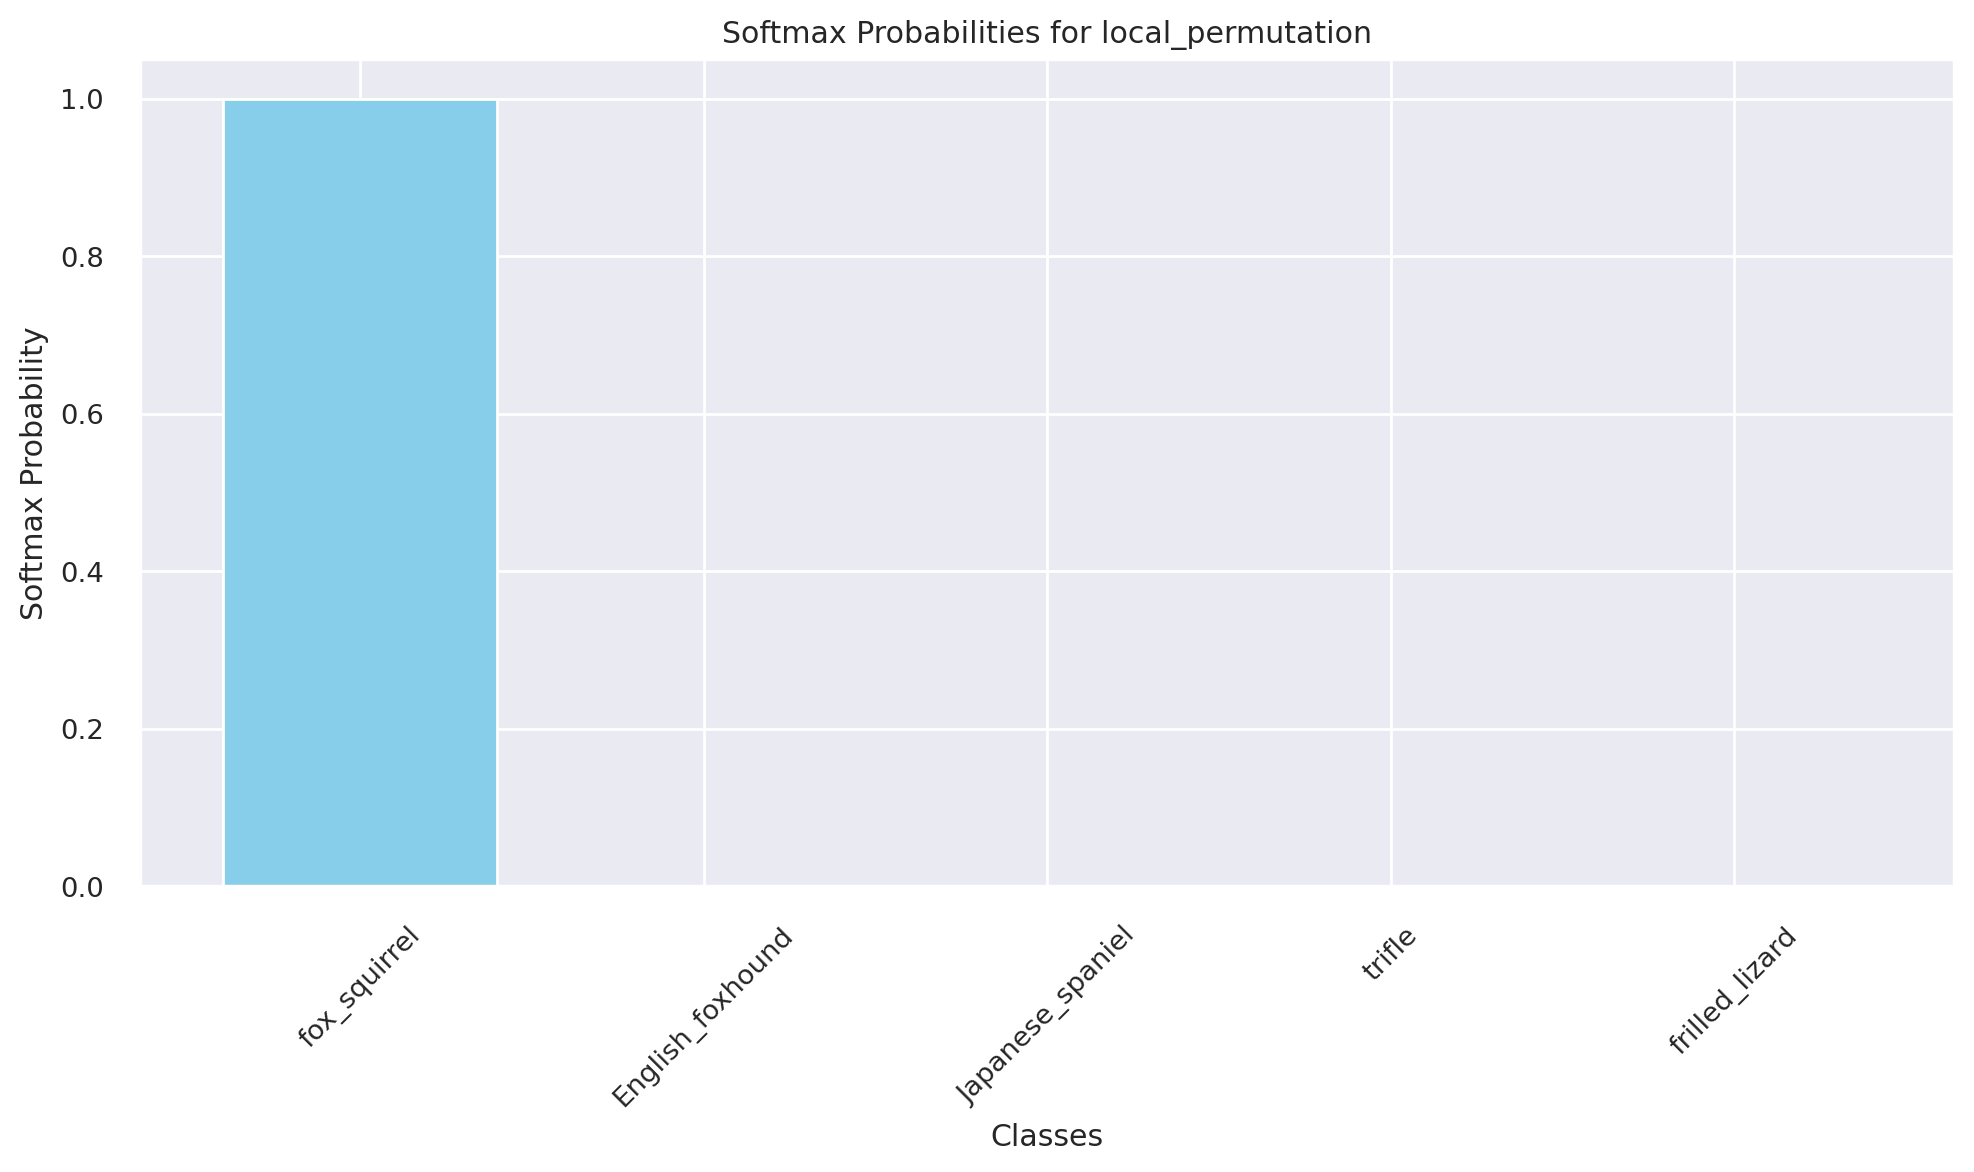

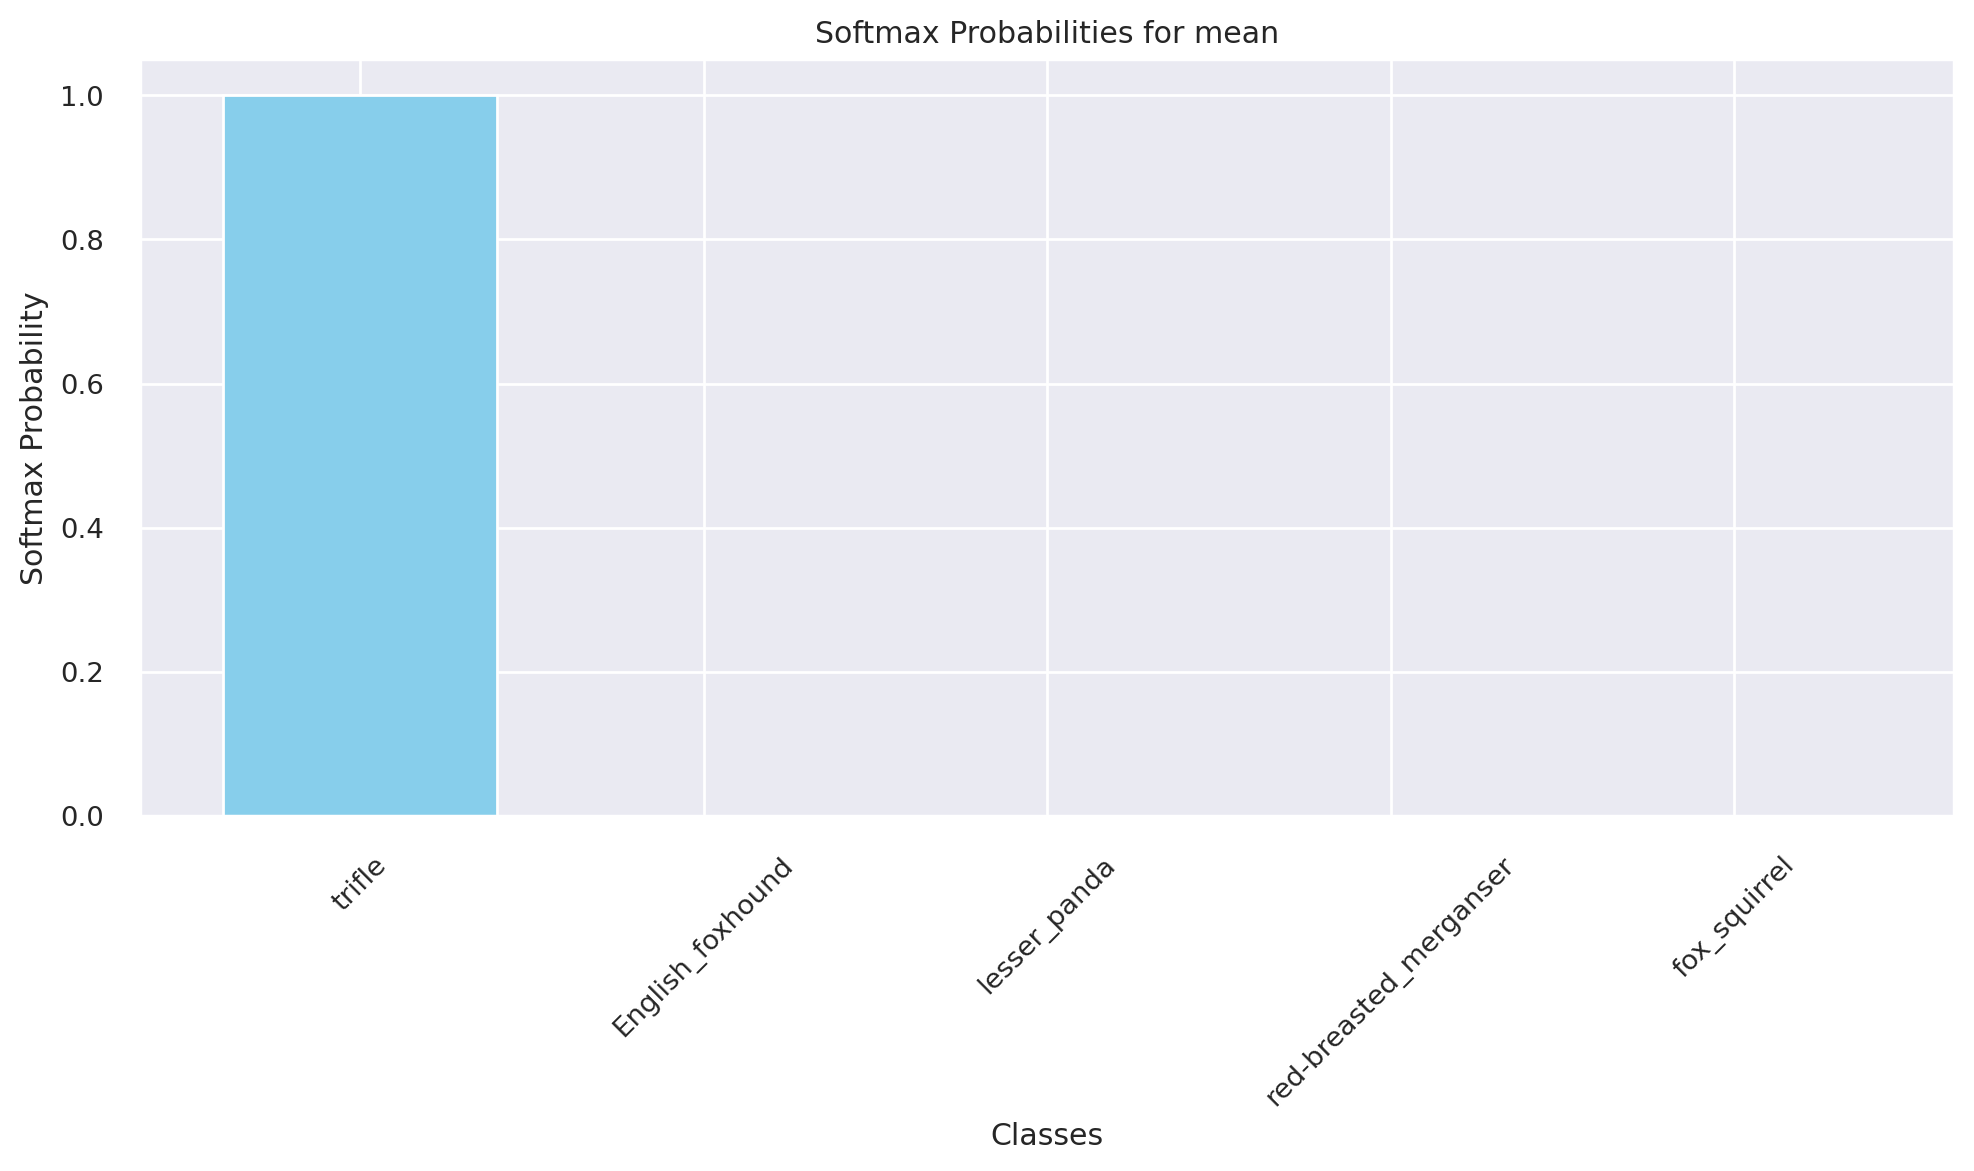

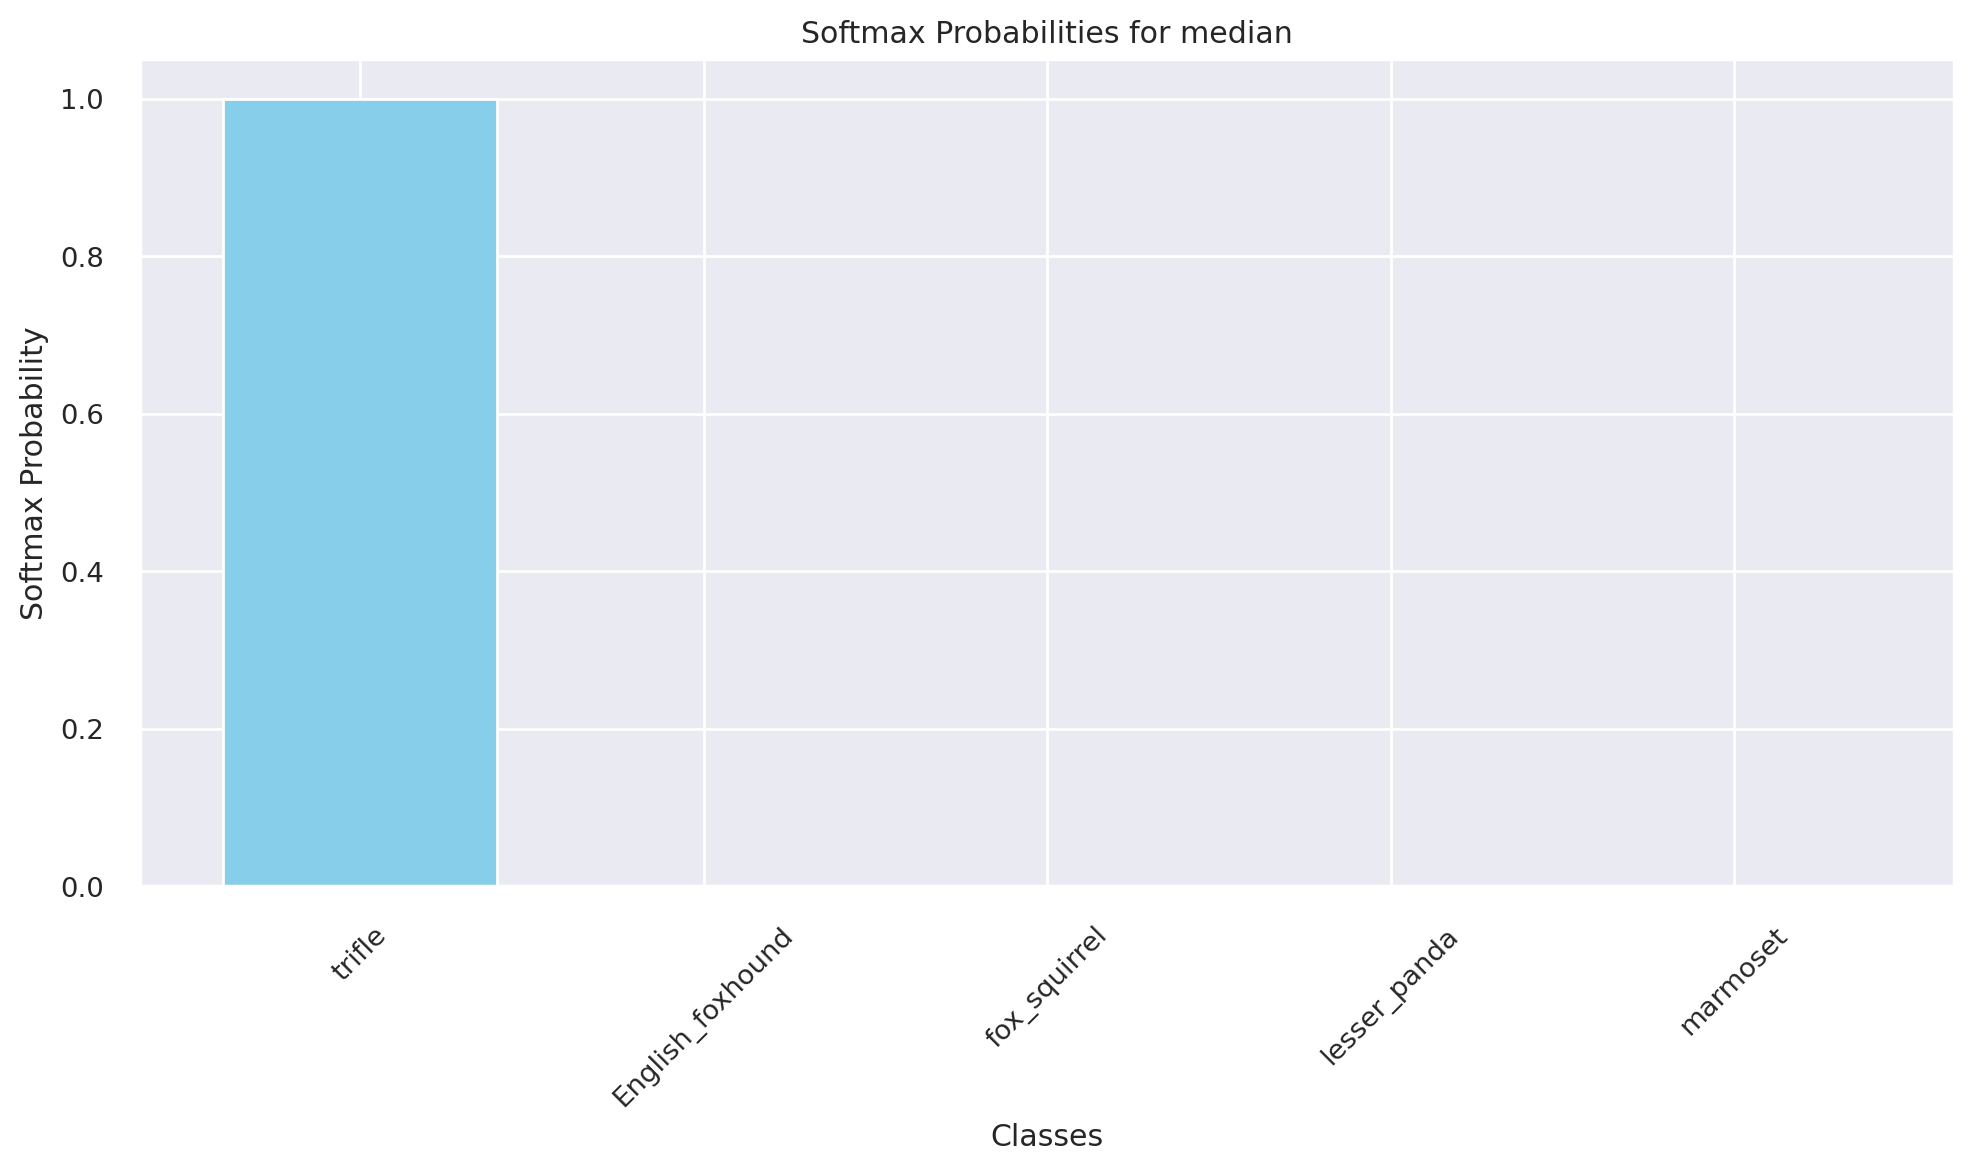

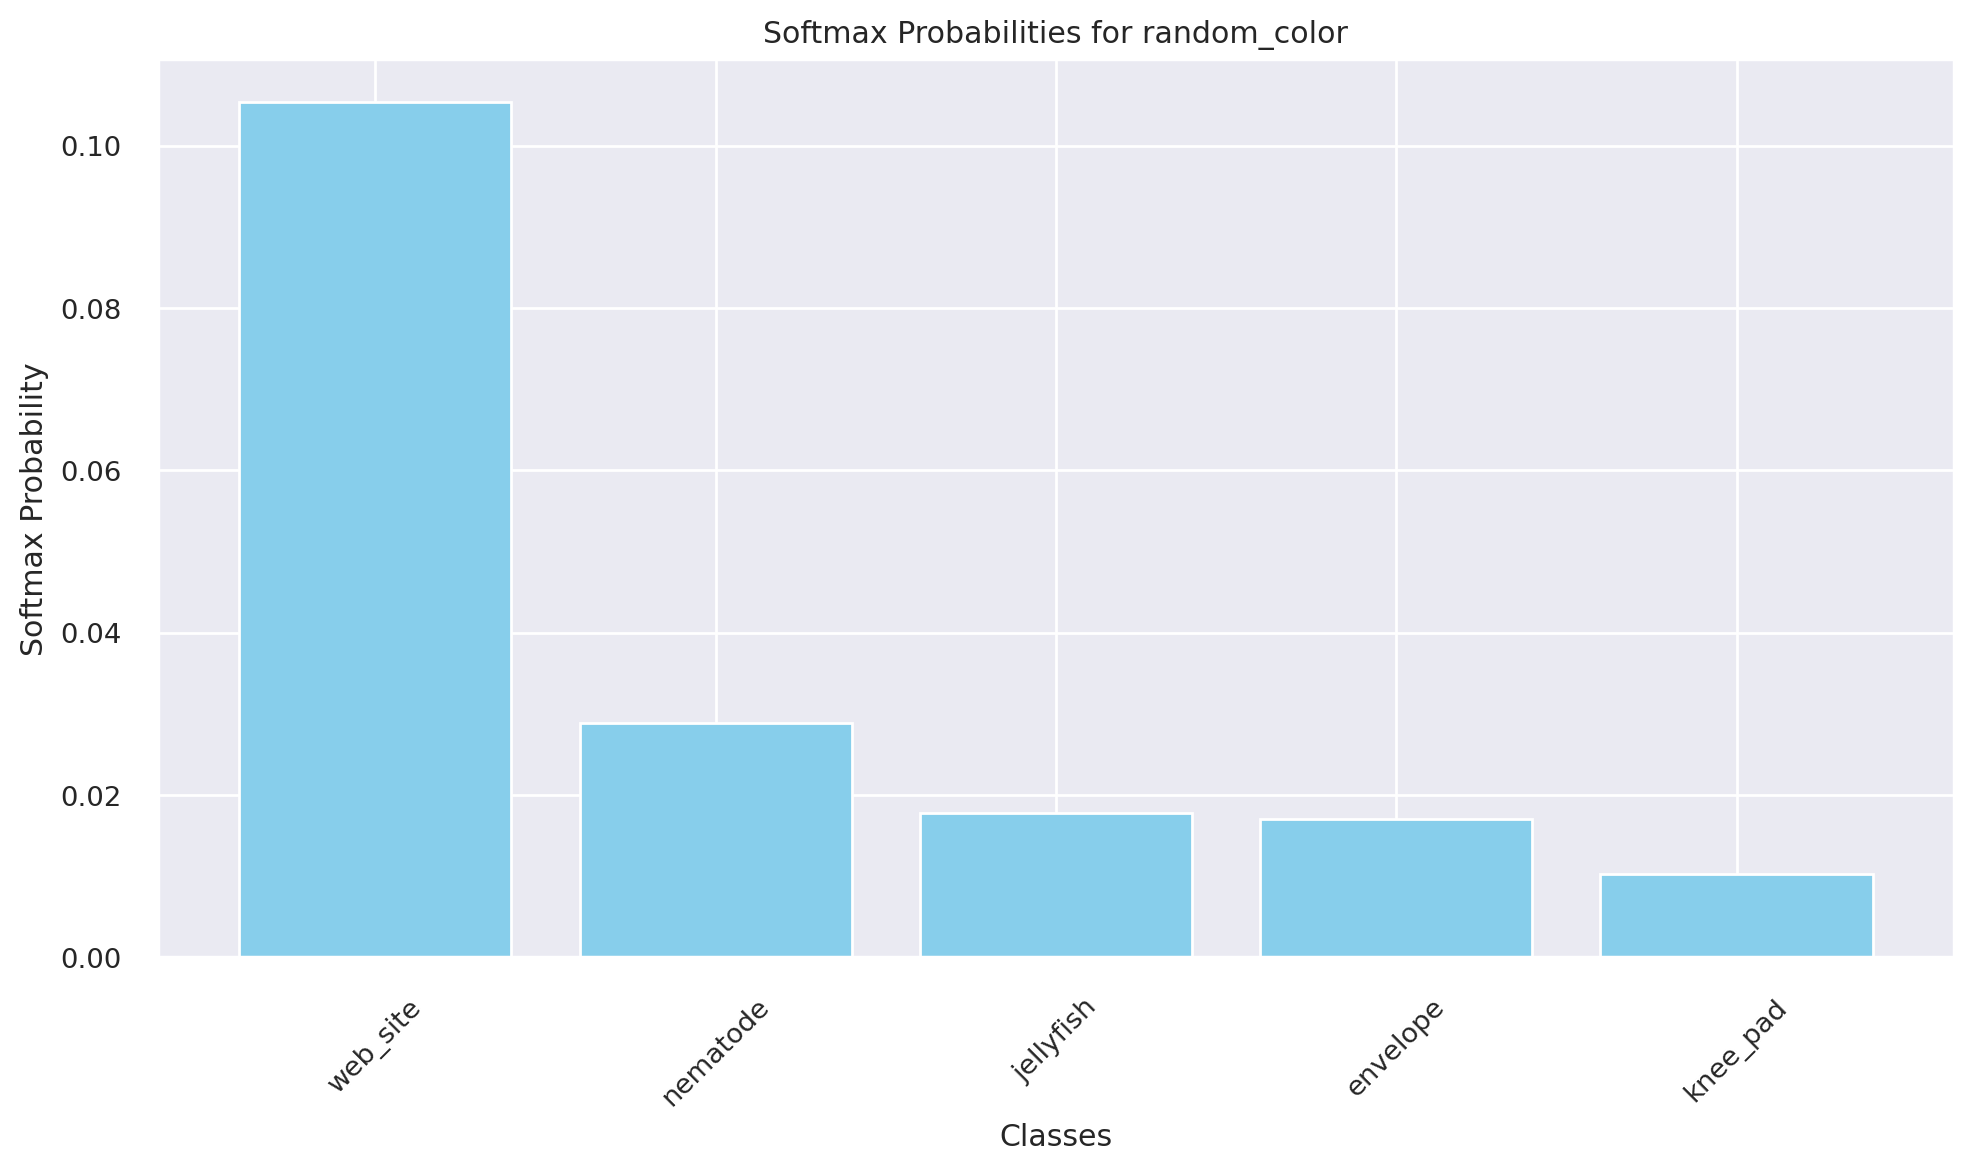

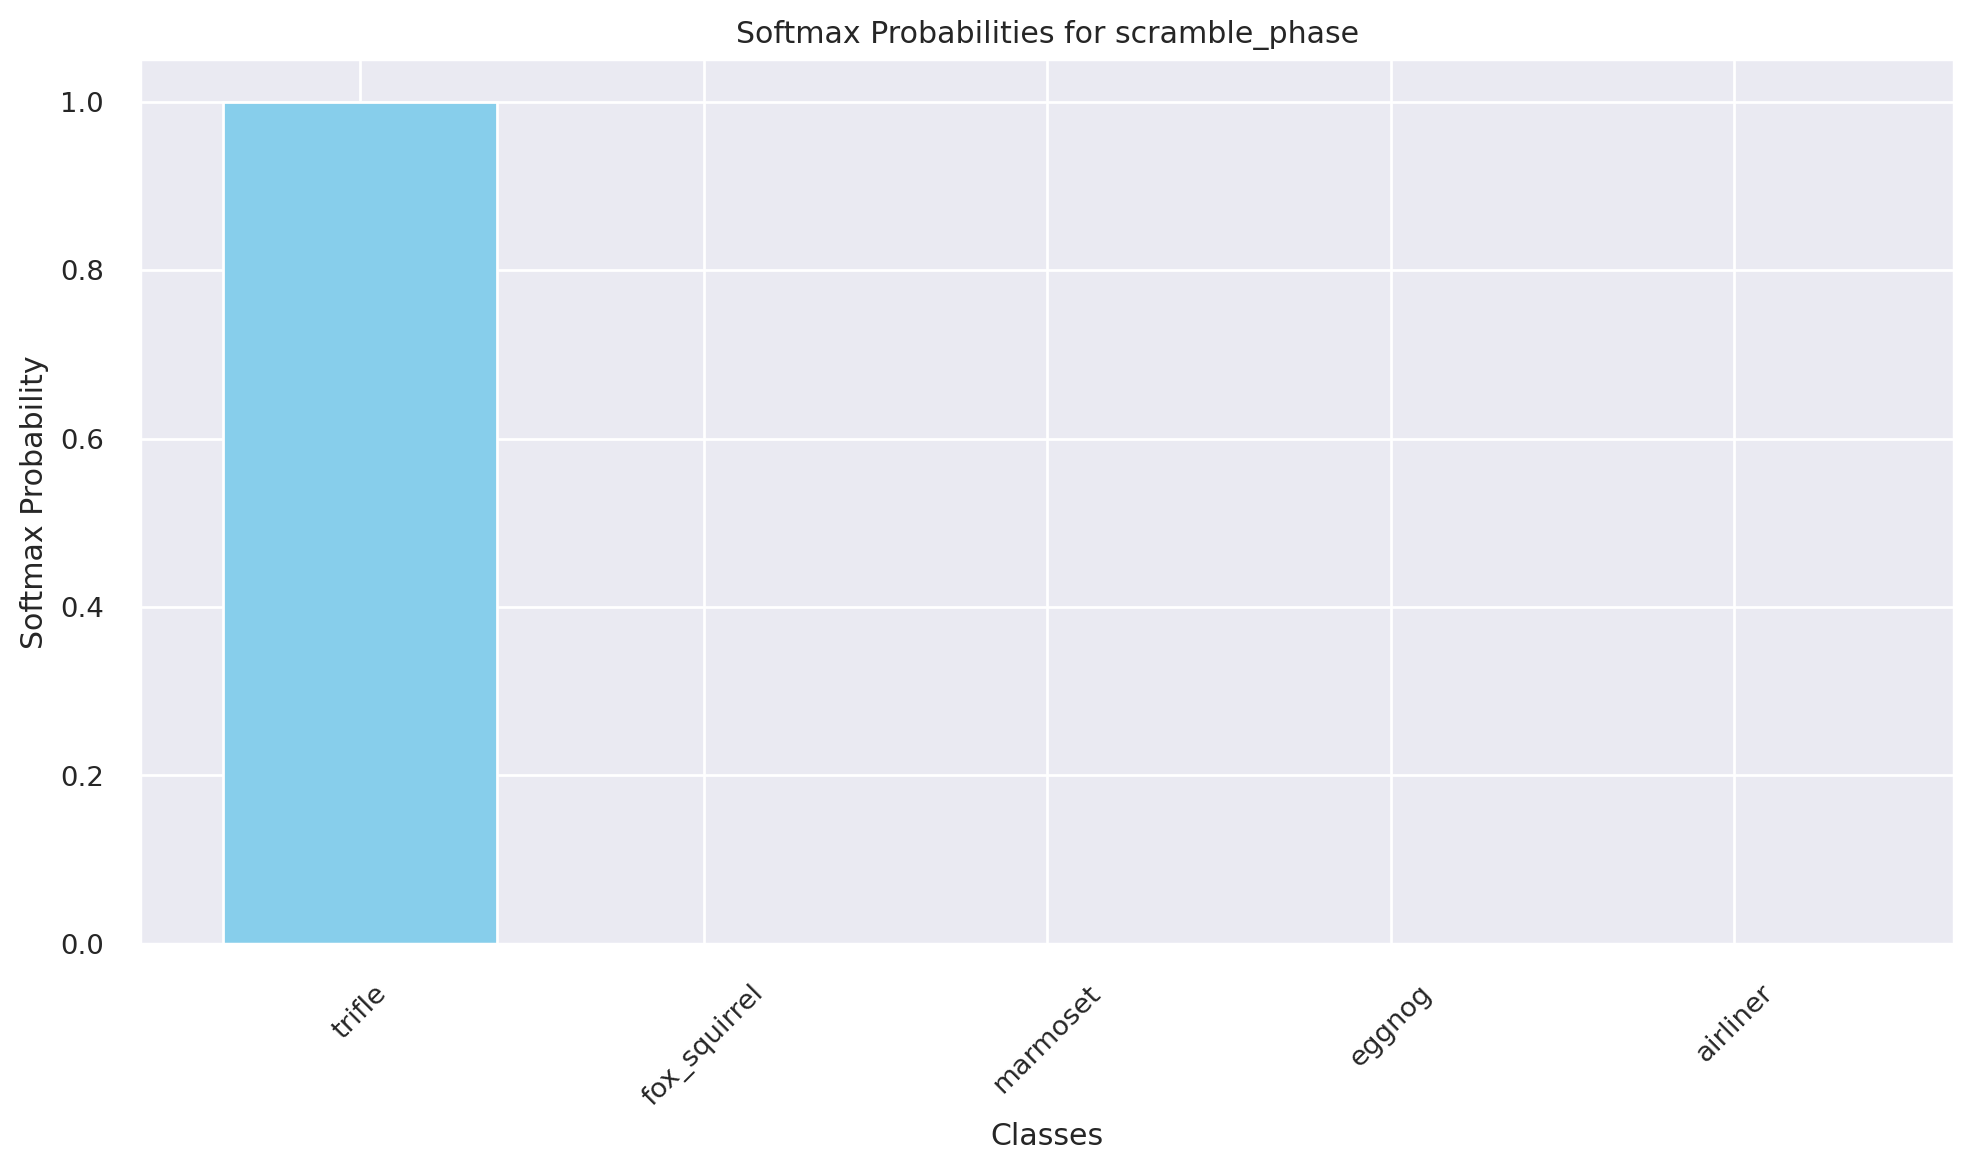

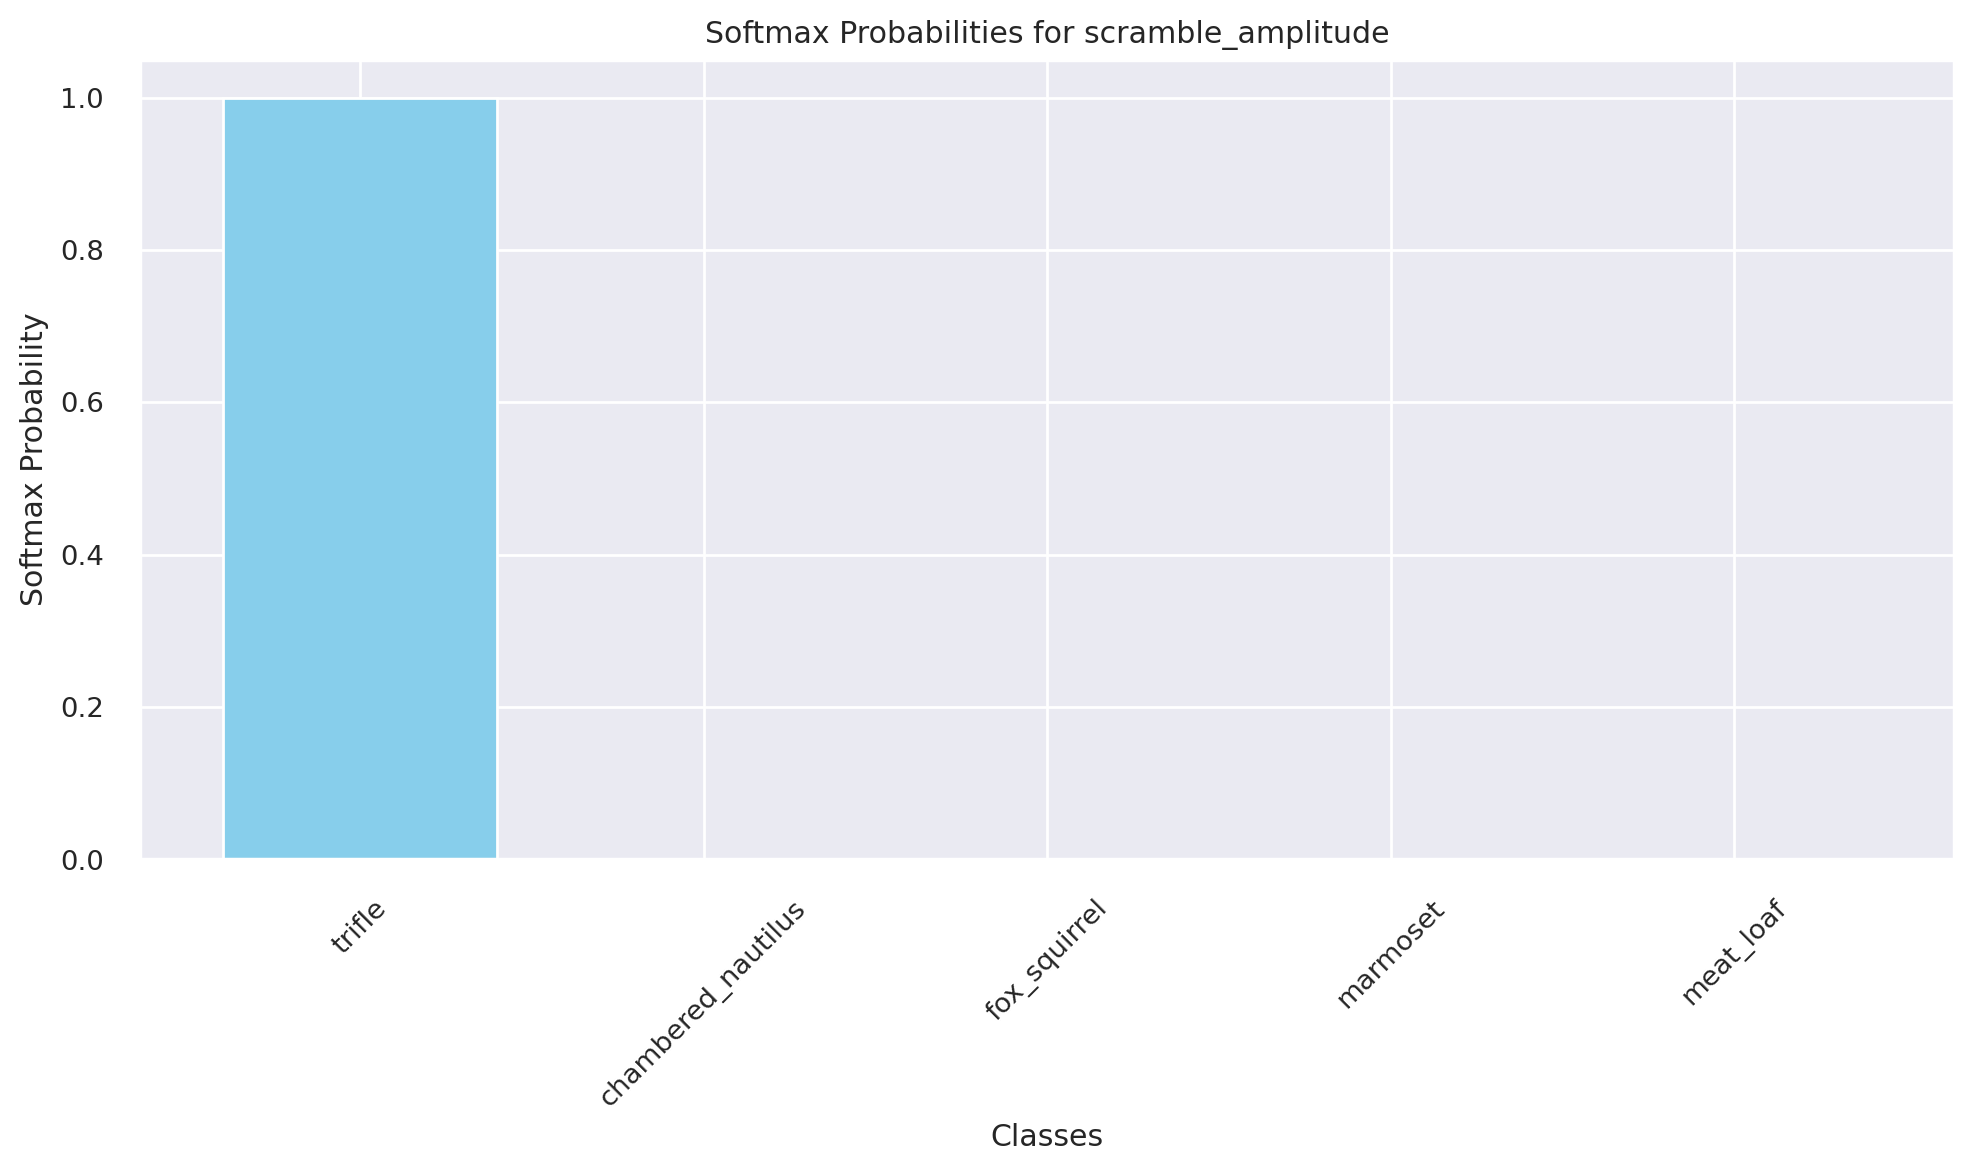

In [ ]:
plot_softmax_classes(classifications_r50)

## Improve the plots to look good for the paper

In [18]:
# Now show it for the baseline fv
logits_fv = model_r50(tf.expand_dims(baseline_fv_r50, axis=0))
top_k_classes = tf.argsort(logits_fv, axis=-1, direction="DESCENDING")[0,:5]
top_k_softmax_values = tf.gather(tf.nn.softmax(logits_fv[0]), top_k_classes)
decoded_logits = decode_predictions(logits_fv.numpy(), top=5)
classifications_r50[("Ours", "classes")] = list(map(lambda z: z[1], decoded_logits[0]))
classifications_r50[("Ours", "softmax")] = top_k_softmax_values

NameError: name 'baseline_fv_r50' is not defined

In [19]:
import pandas as pd
import random

In [ ]:
colors = [
    [78, 20, 105],  # purple
    [220, 81, 104],  # pink
    [55, 125, 163],  # blue petroleum
    [75, 165, 227],  # light blue
    [79, 170, 111],  # light green
    [107, 203, 175]  # turquoise
]

In [27]:
def plot_top5_predictions(data: dict):
    """
    Generates bar plots for the top 5 class predictions for each baseline with corresponding softmax probabilities.
    Adjusts annotations dynamically based on value ranges to ensure readability.

    Args:
    data (dict): A dictionary with keys as tuples (baseline_name, type) where type is either 'classes' or 'softmax',
                 and values are lists representing class indices or softmax probabilities respectively.
    Raises:
    ValueError: If the data does not contain corresponding 'classes' and 'softmax' for each baseline.
    """
    sns.set(style="whitegrid")

    # Define custom colors and background color
    colors = [
        [78, 20, 105], [220, 81, 104], [55, 125, 163],
        [75, 165, 227], [79, 170, 111], [107, 203, 175]
    ]
    # Shuffle the colors to use for the bars
    random.shuffle(colors)
    # Convert RGB to normalized format for matplotlib
    colors = list(np.array(colors) / 255.0)
    background_color = list(np.array([234, 234, 242]) / 255.0)

    # Set the figure's background color to white
    plt.rcParams['figure.facecolor'] = 'white'

    # Iterate through the baselines and gather data for plotting
    for key in data.keys():
        if key[1] == 'classes':
            baseline_name = key[0]
            classes_key = (baseline_name, 'classes')
            softmax_key = (baseline_name, 'softmax')

            # Ensure both classes and softmax data are present
            if softmax_key not in data:
                raise ValueError(f"Missing 'softmax' data for {baseline_name}")

            class_labels = data[classes_key]
            softmax_probs = data[softmax_key]

            # Prepare the DataFrame for plotting
            df = pd.DataFrame({
                'Class': class_labels,
                'Probability': softmax_probs
            })

            # Plotting
            plt.figure(figsize=(10, 6))
            bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])
            # bar_plot.set_title(f'Top 5 Predictions for {baseline_name}', fontsize=18)
            bar_plot.set_xlabel('Softmax Probability', fontsize=20)
            bar_plot.set_ylabel('Class', fontsize=20)
            bar_plot.set_xlim(0.0, 1.0)

            # Improve plot aesthetics with dynamic text annotations
            for p in bar_plot.patches:
                width = p.get_width()
                # Adjust number of decimal places based on the range of values
                if width > 0.1:
                    annotation = f'{width:.2f}'
                elif width > 0.01:
                    annotation = f'{width:.3f}'
                else:
                    annotation = f'{width:.4f}'
                bar_plot.text(width + 0.01, p.get_y() + p.get_height() / 2,
                              annotation, ha='left', va='center', fontsize=20)

            # Remove minor ticks and grid
            bar_plot.xaxis.set_minor_locator(plt.NullLocator())
            bar_plot.yaxis.set_minor_locator(plt.NullLocator())
            bar_plot.grid(False)  # Remove grid

            plt.tight_layout()
            plt.show()

<ipython-input-27-16c8652d2dda>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


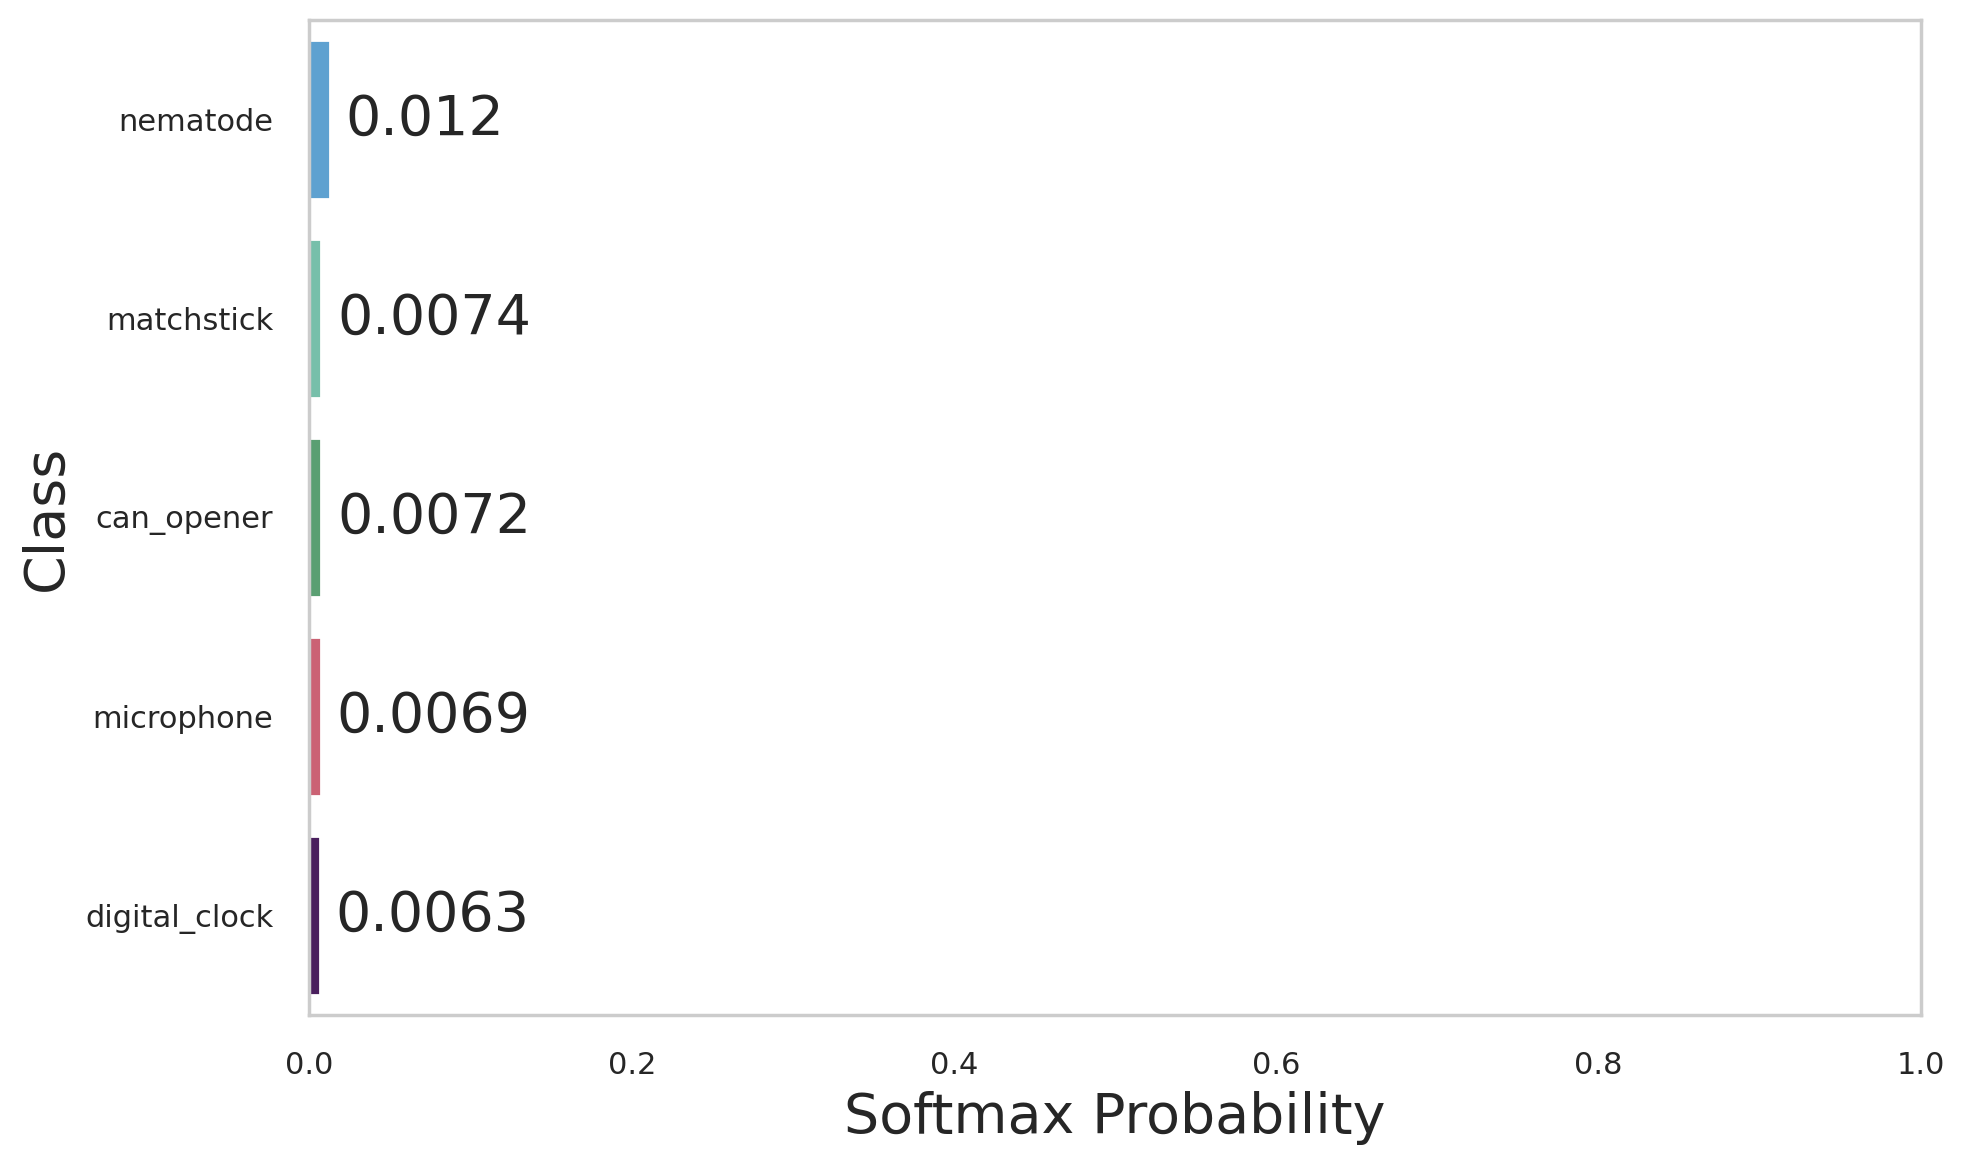

<ipython-input-27-16c8652d2dda>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


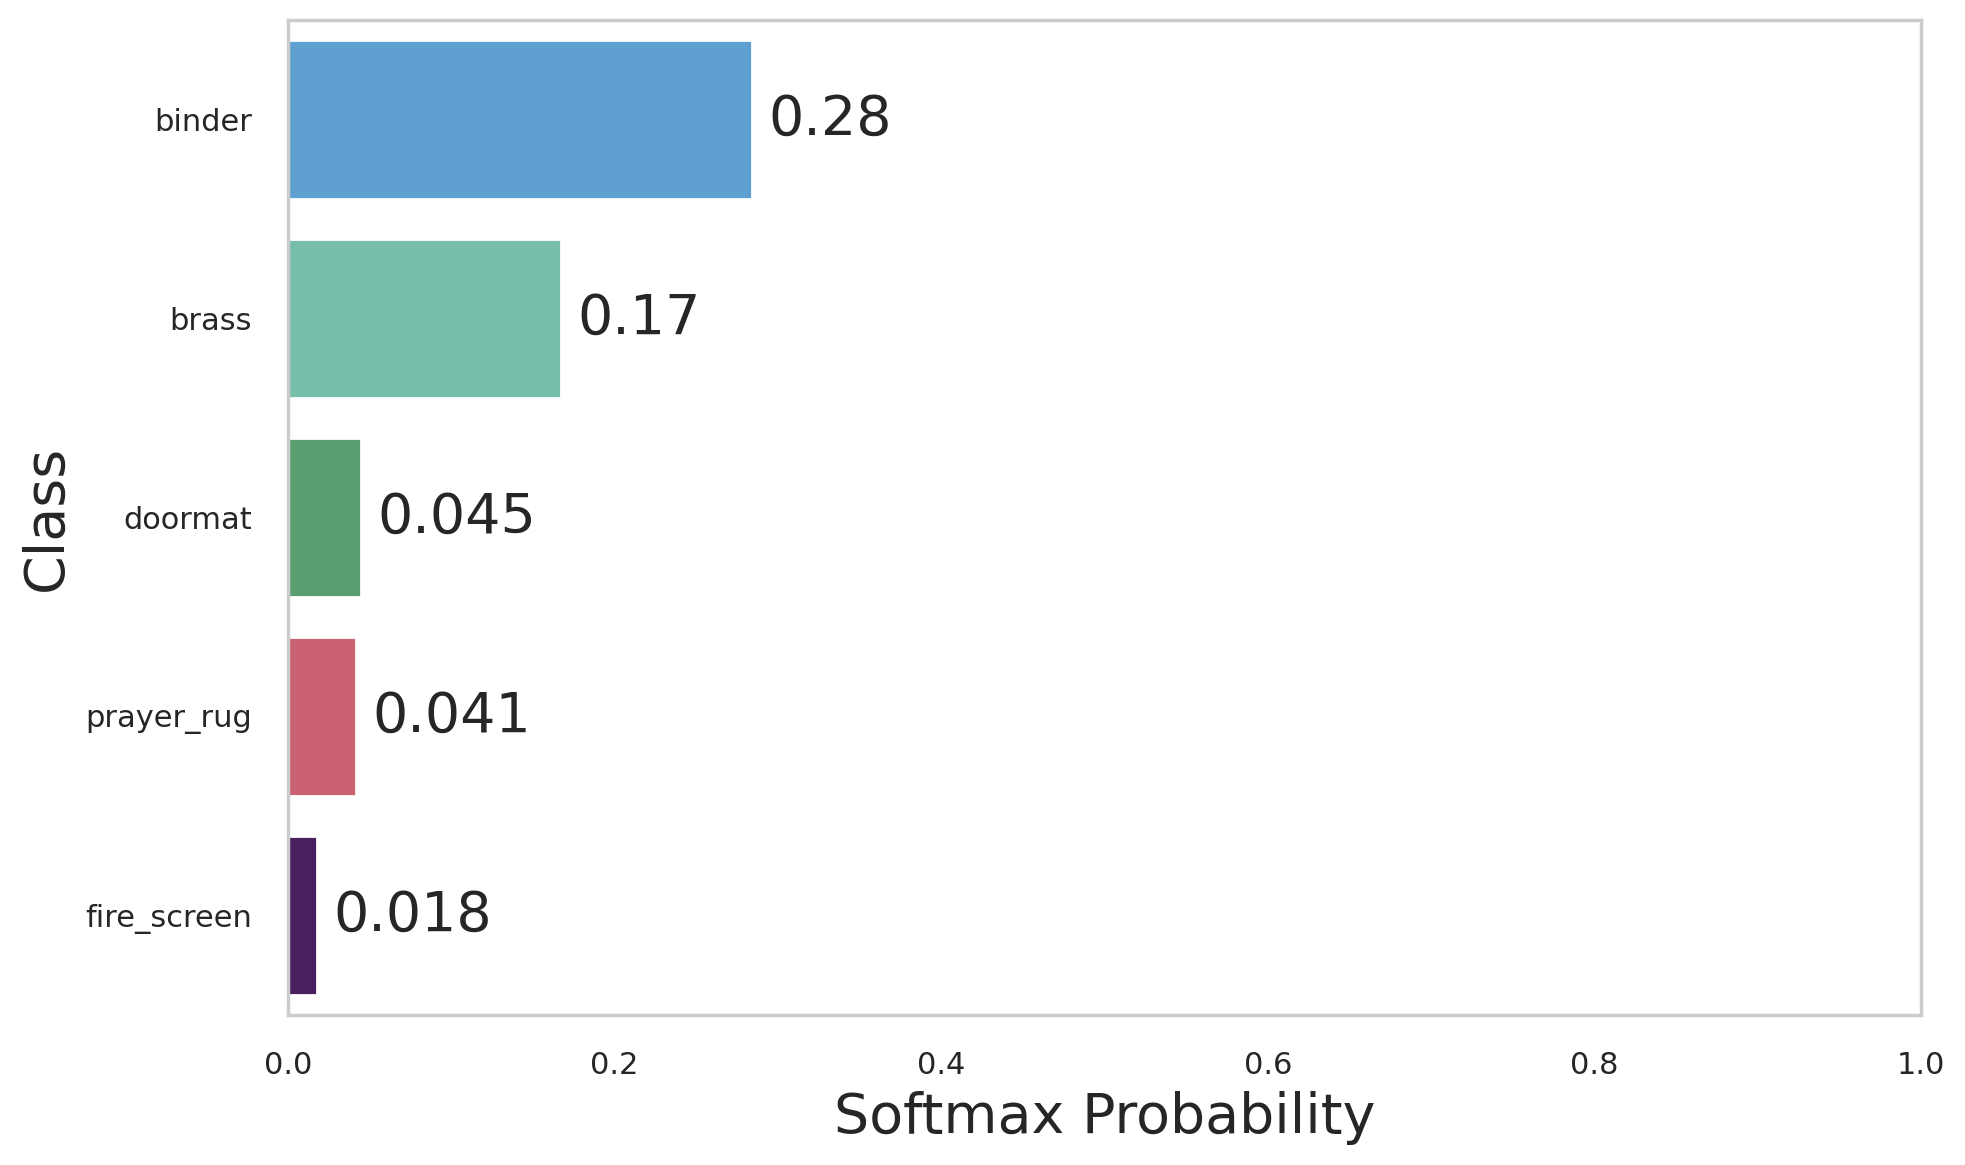

<ipython-input-27-16c8652d2dda>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


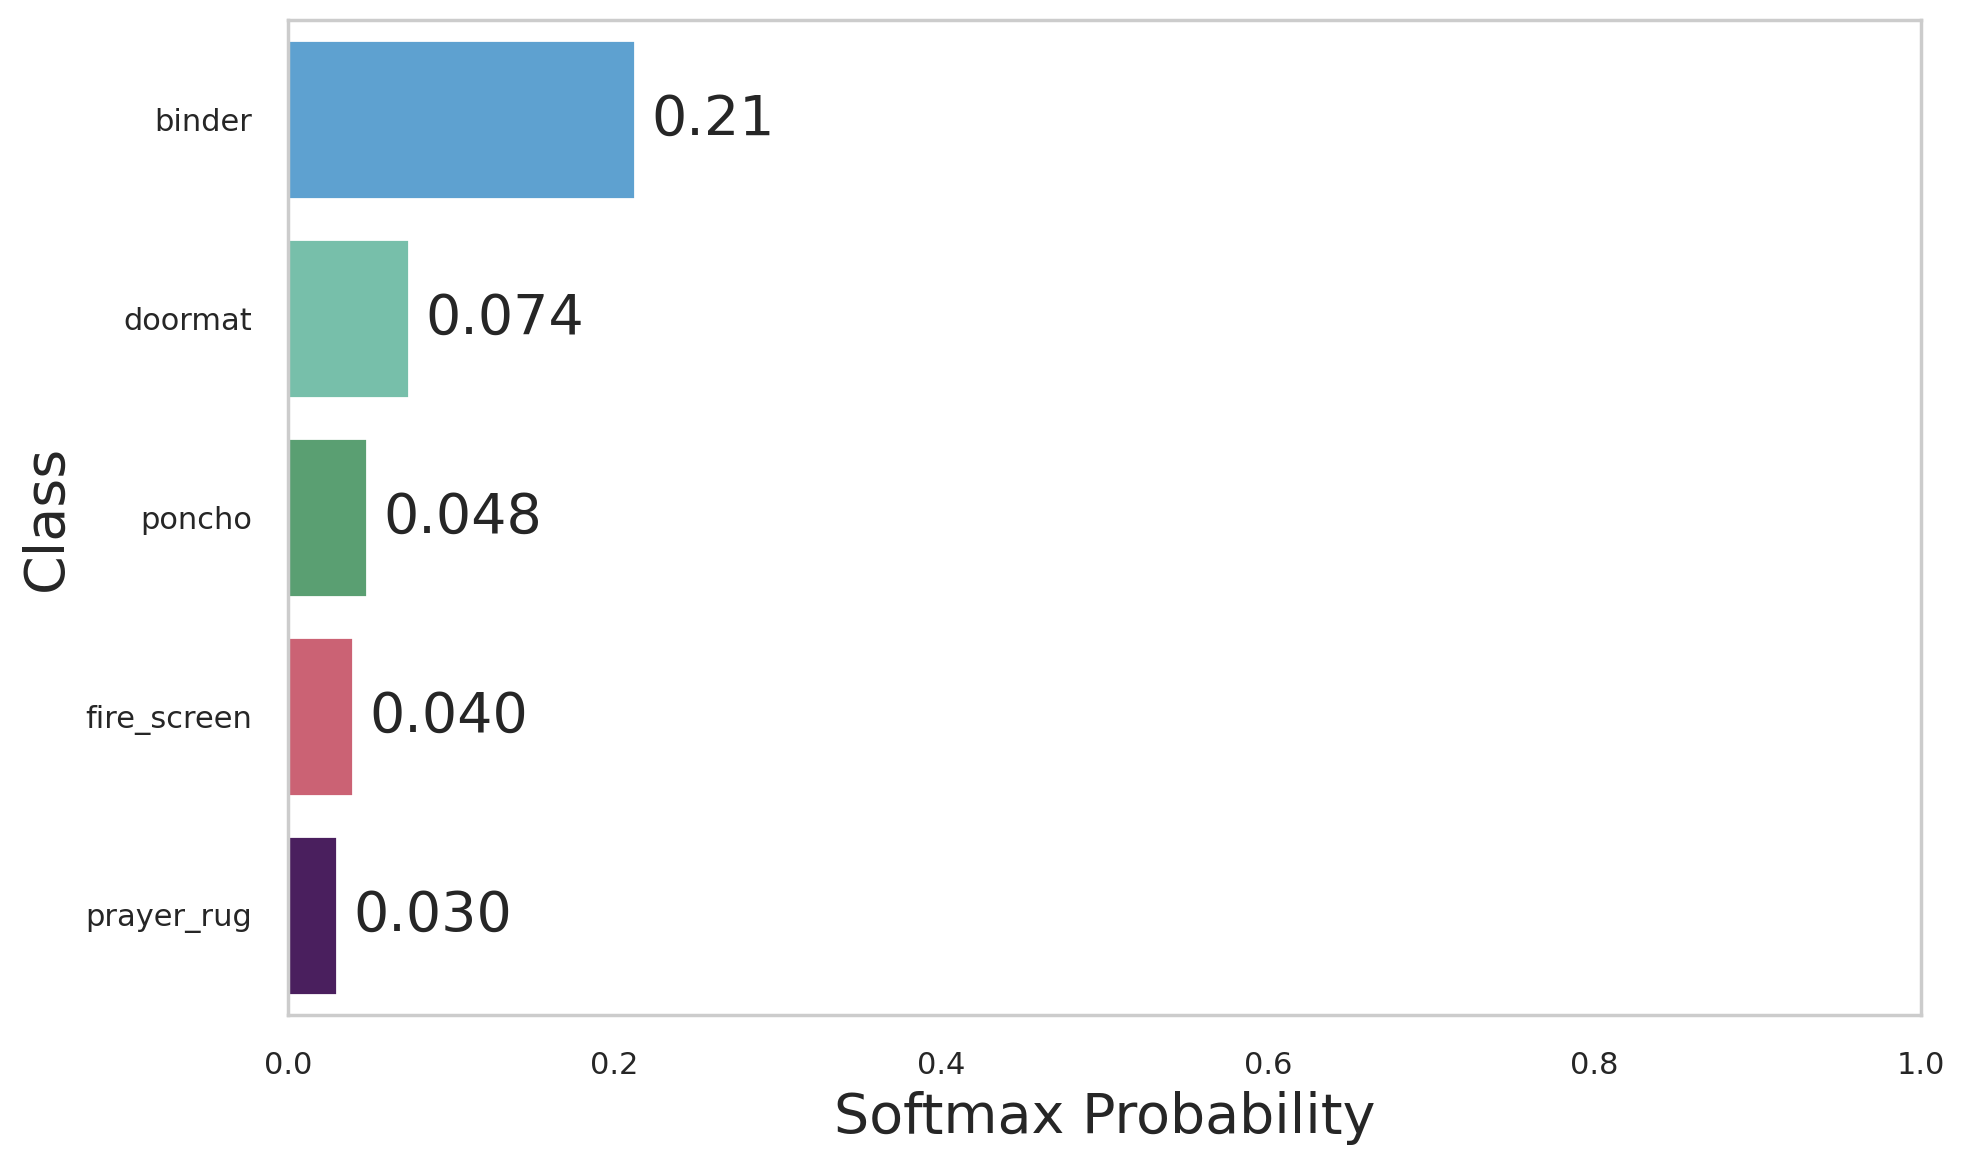

<ipython-input-27-16c8652d2dda>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


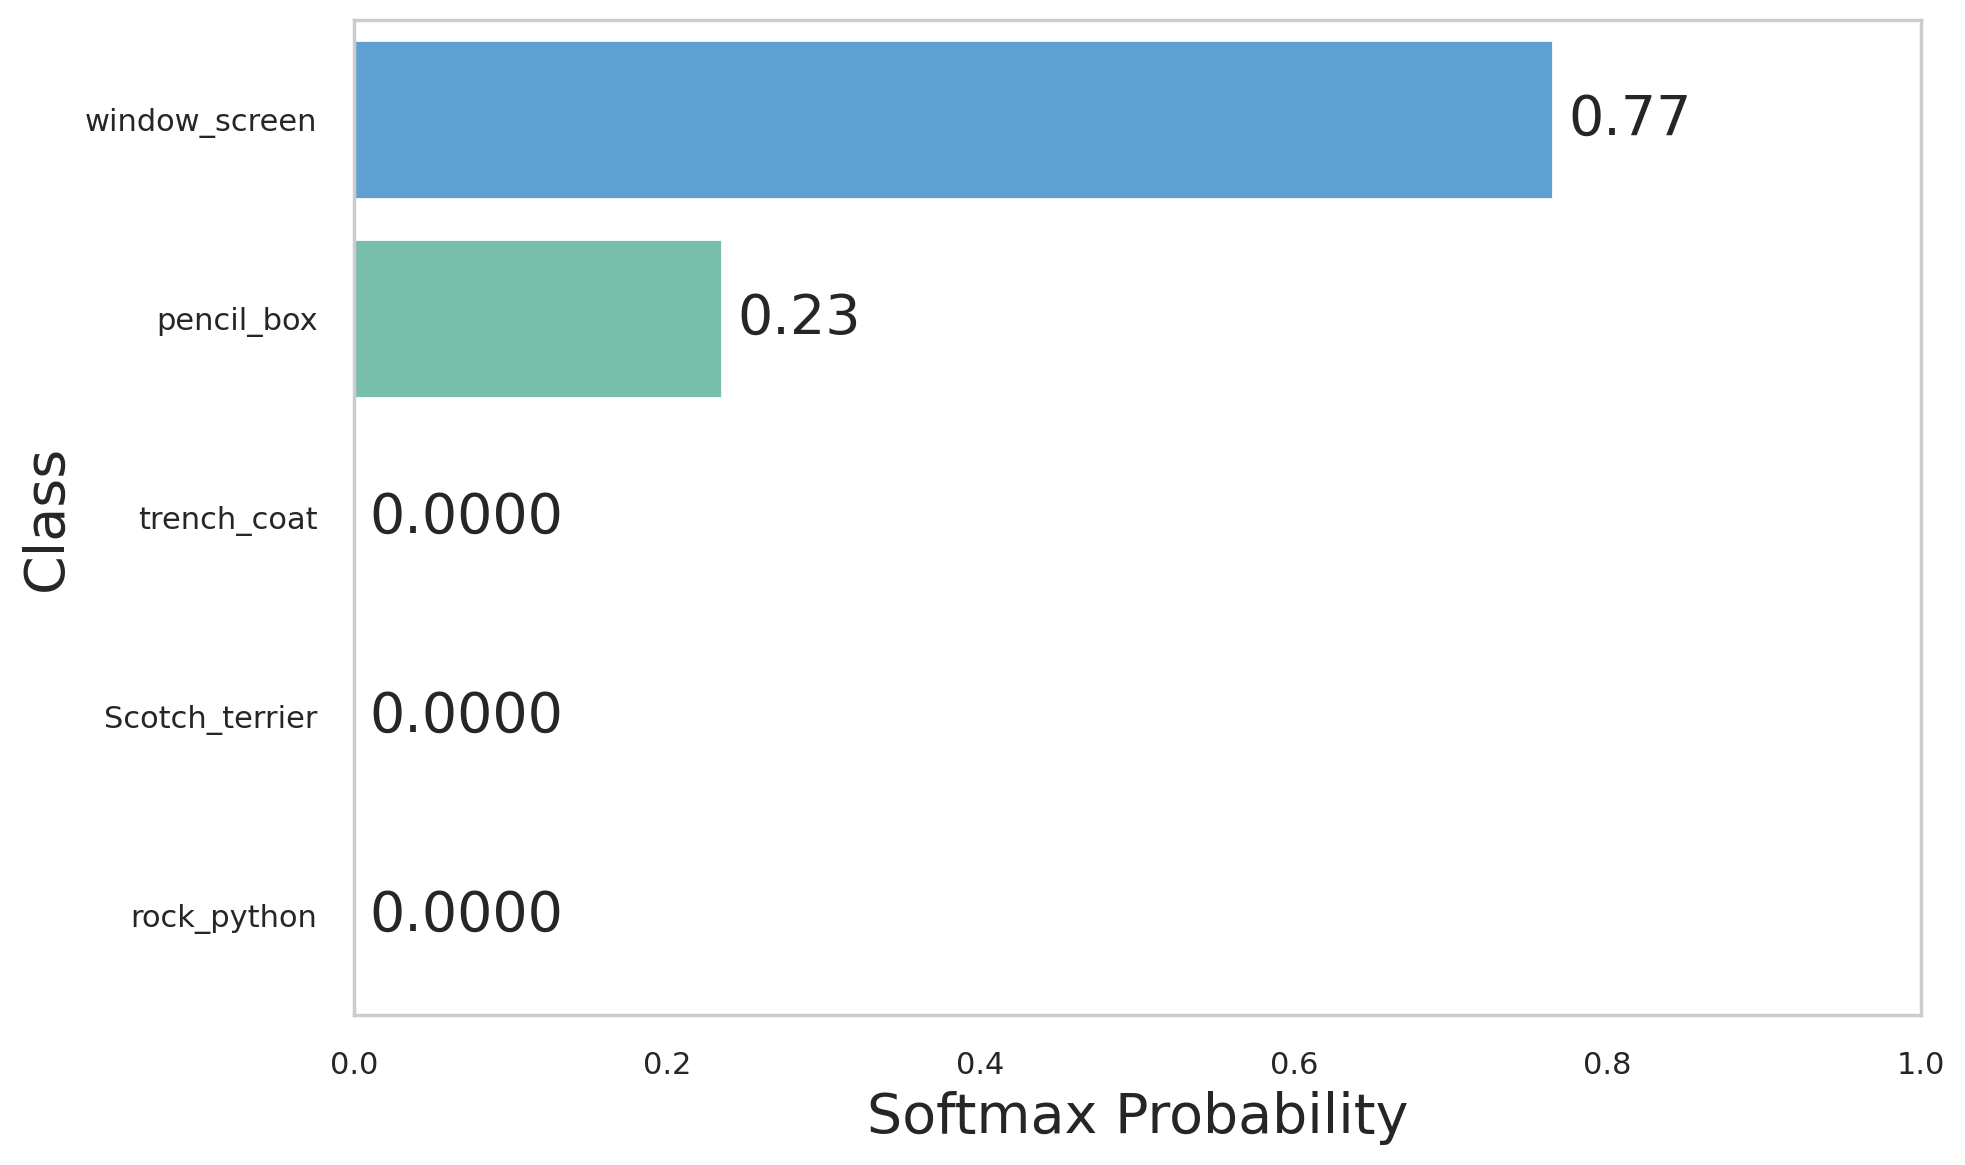

<ipython-input-27-16c8652d2dda>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


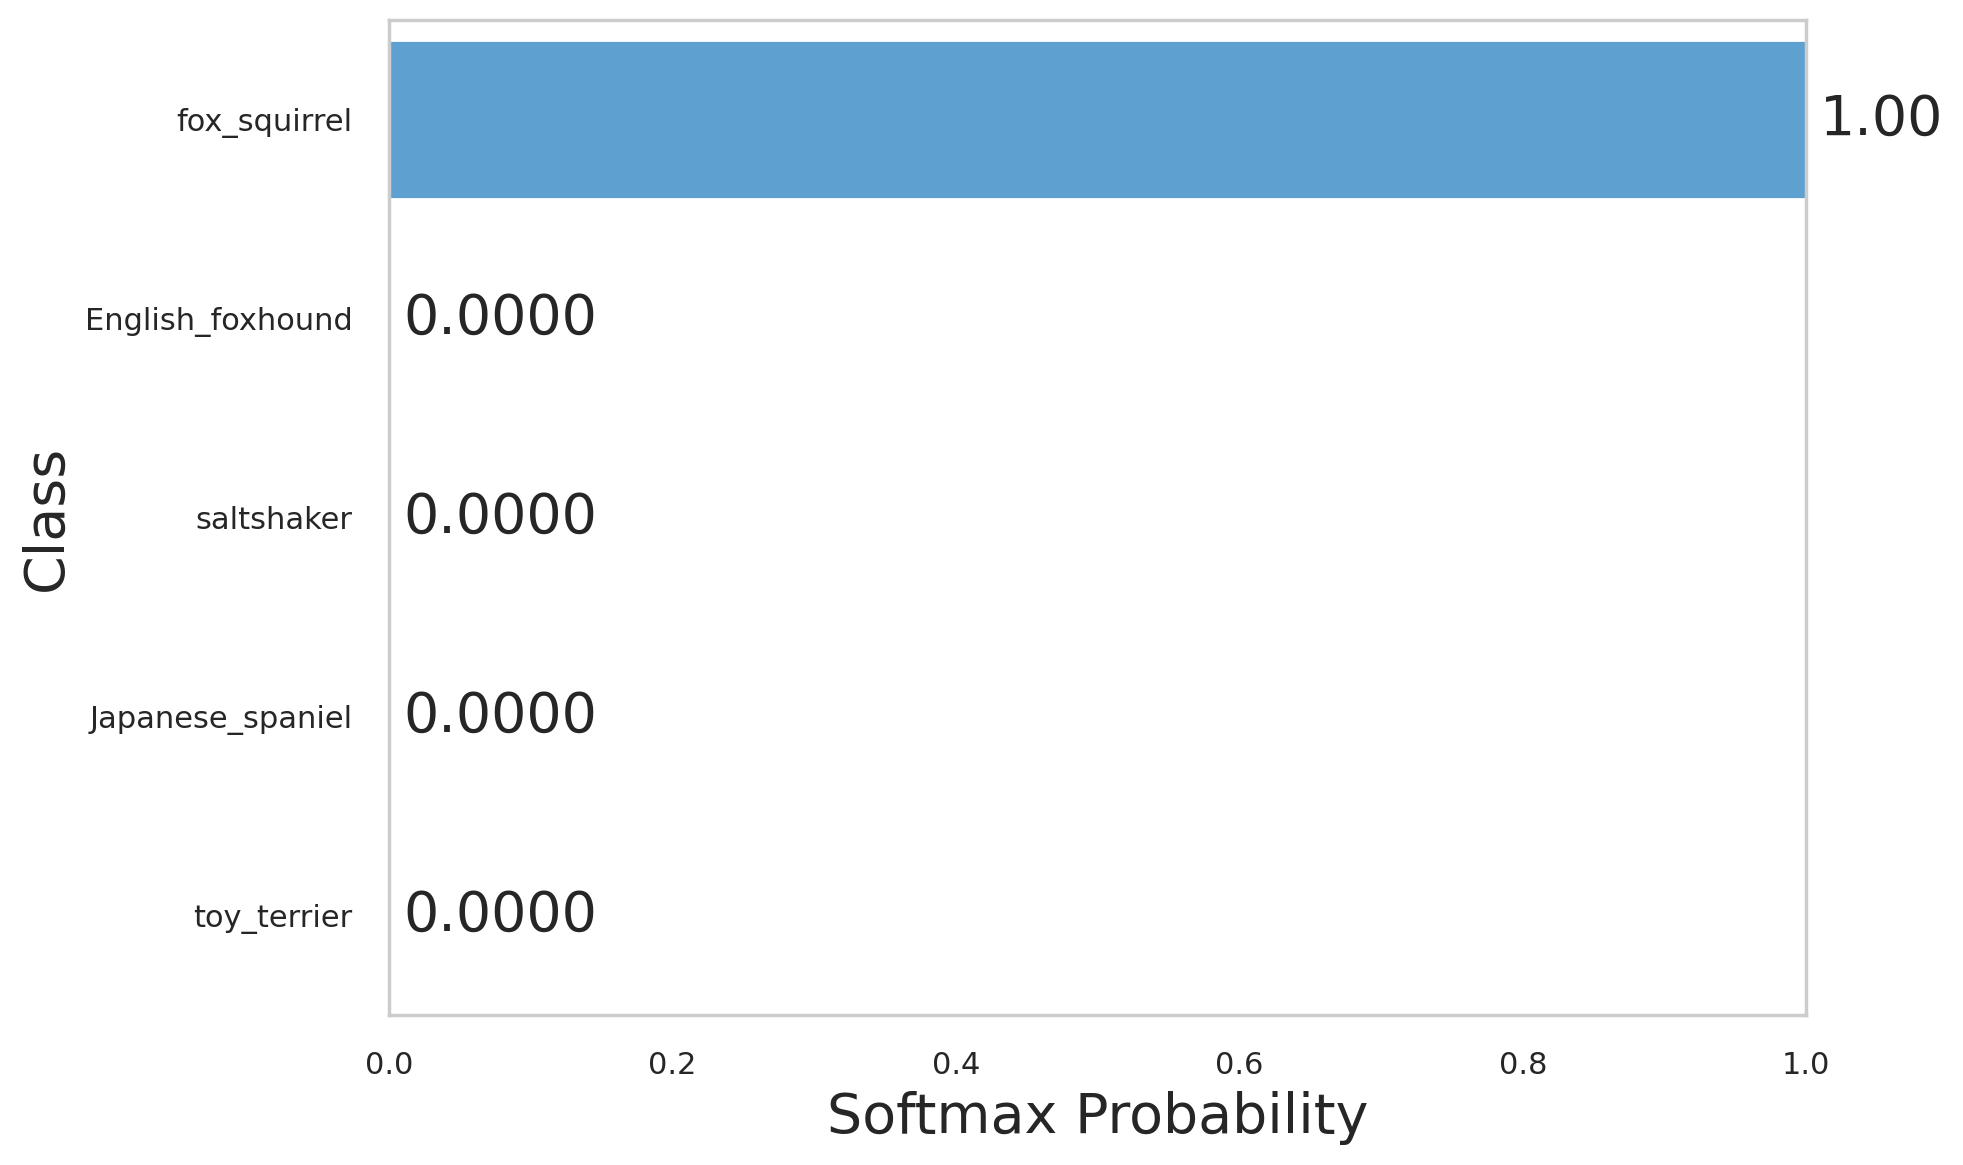

<ipython-input-27-16c8652d2dda>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


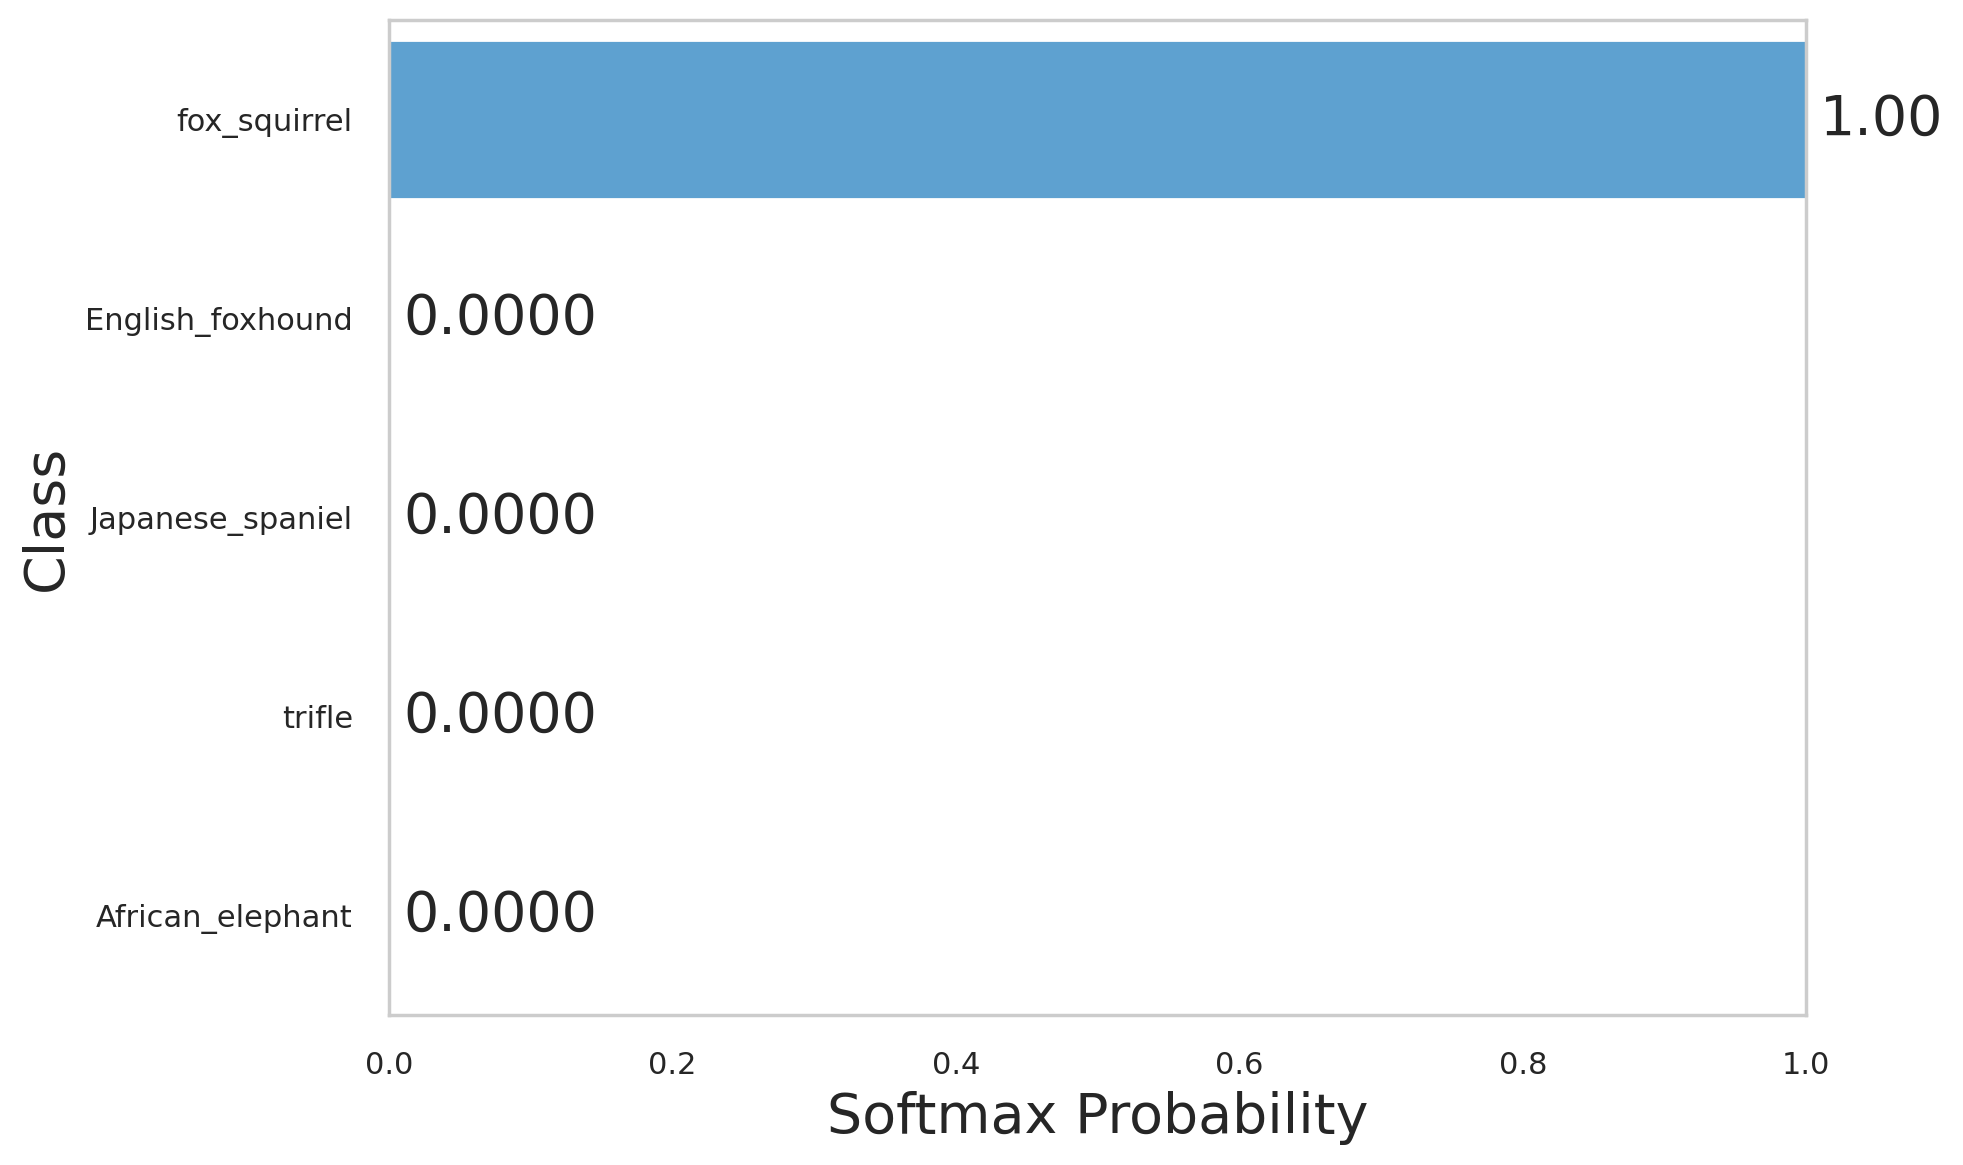

<ipython-input-27-16c8652d2dda>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


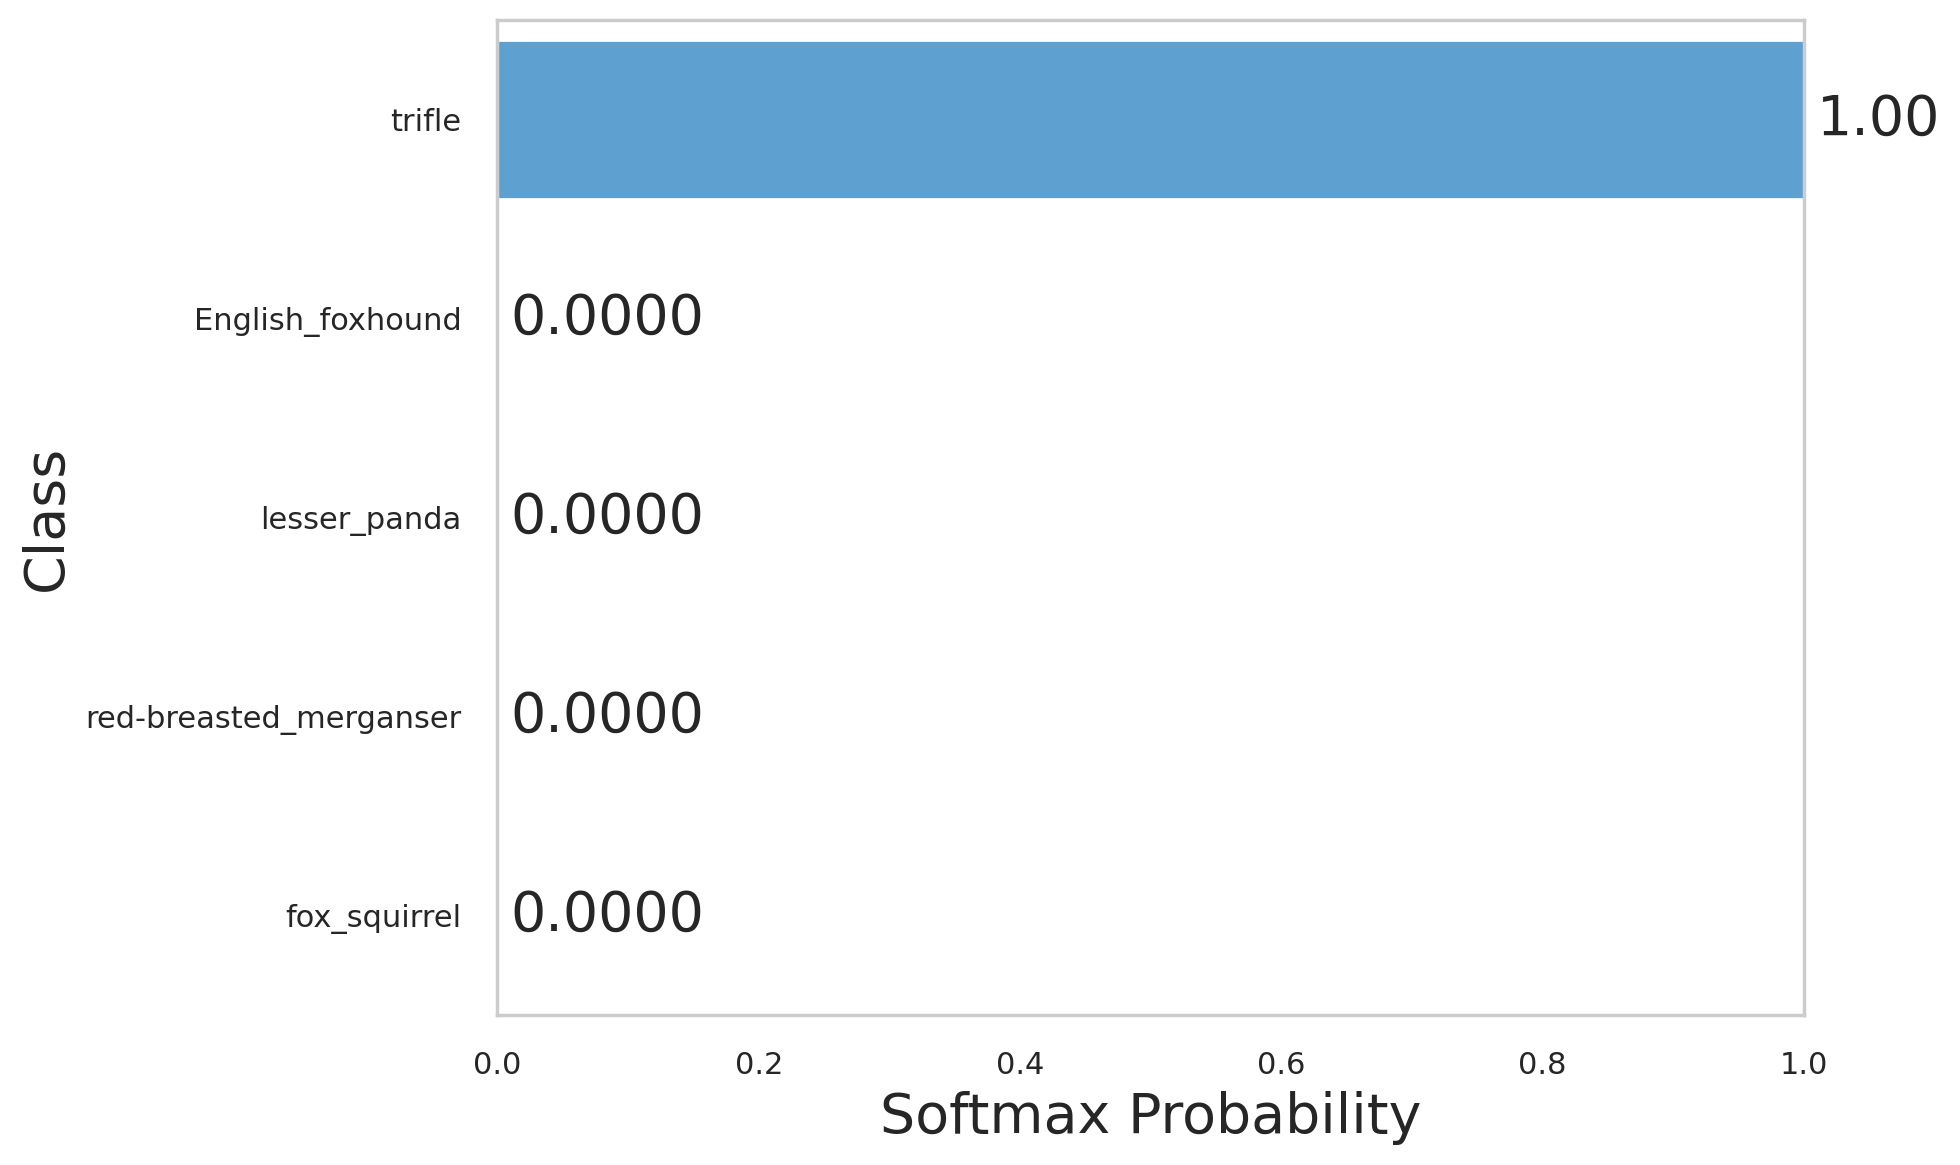

<ipython-input-27-16c8652d2dda>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


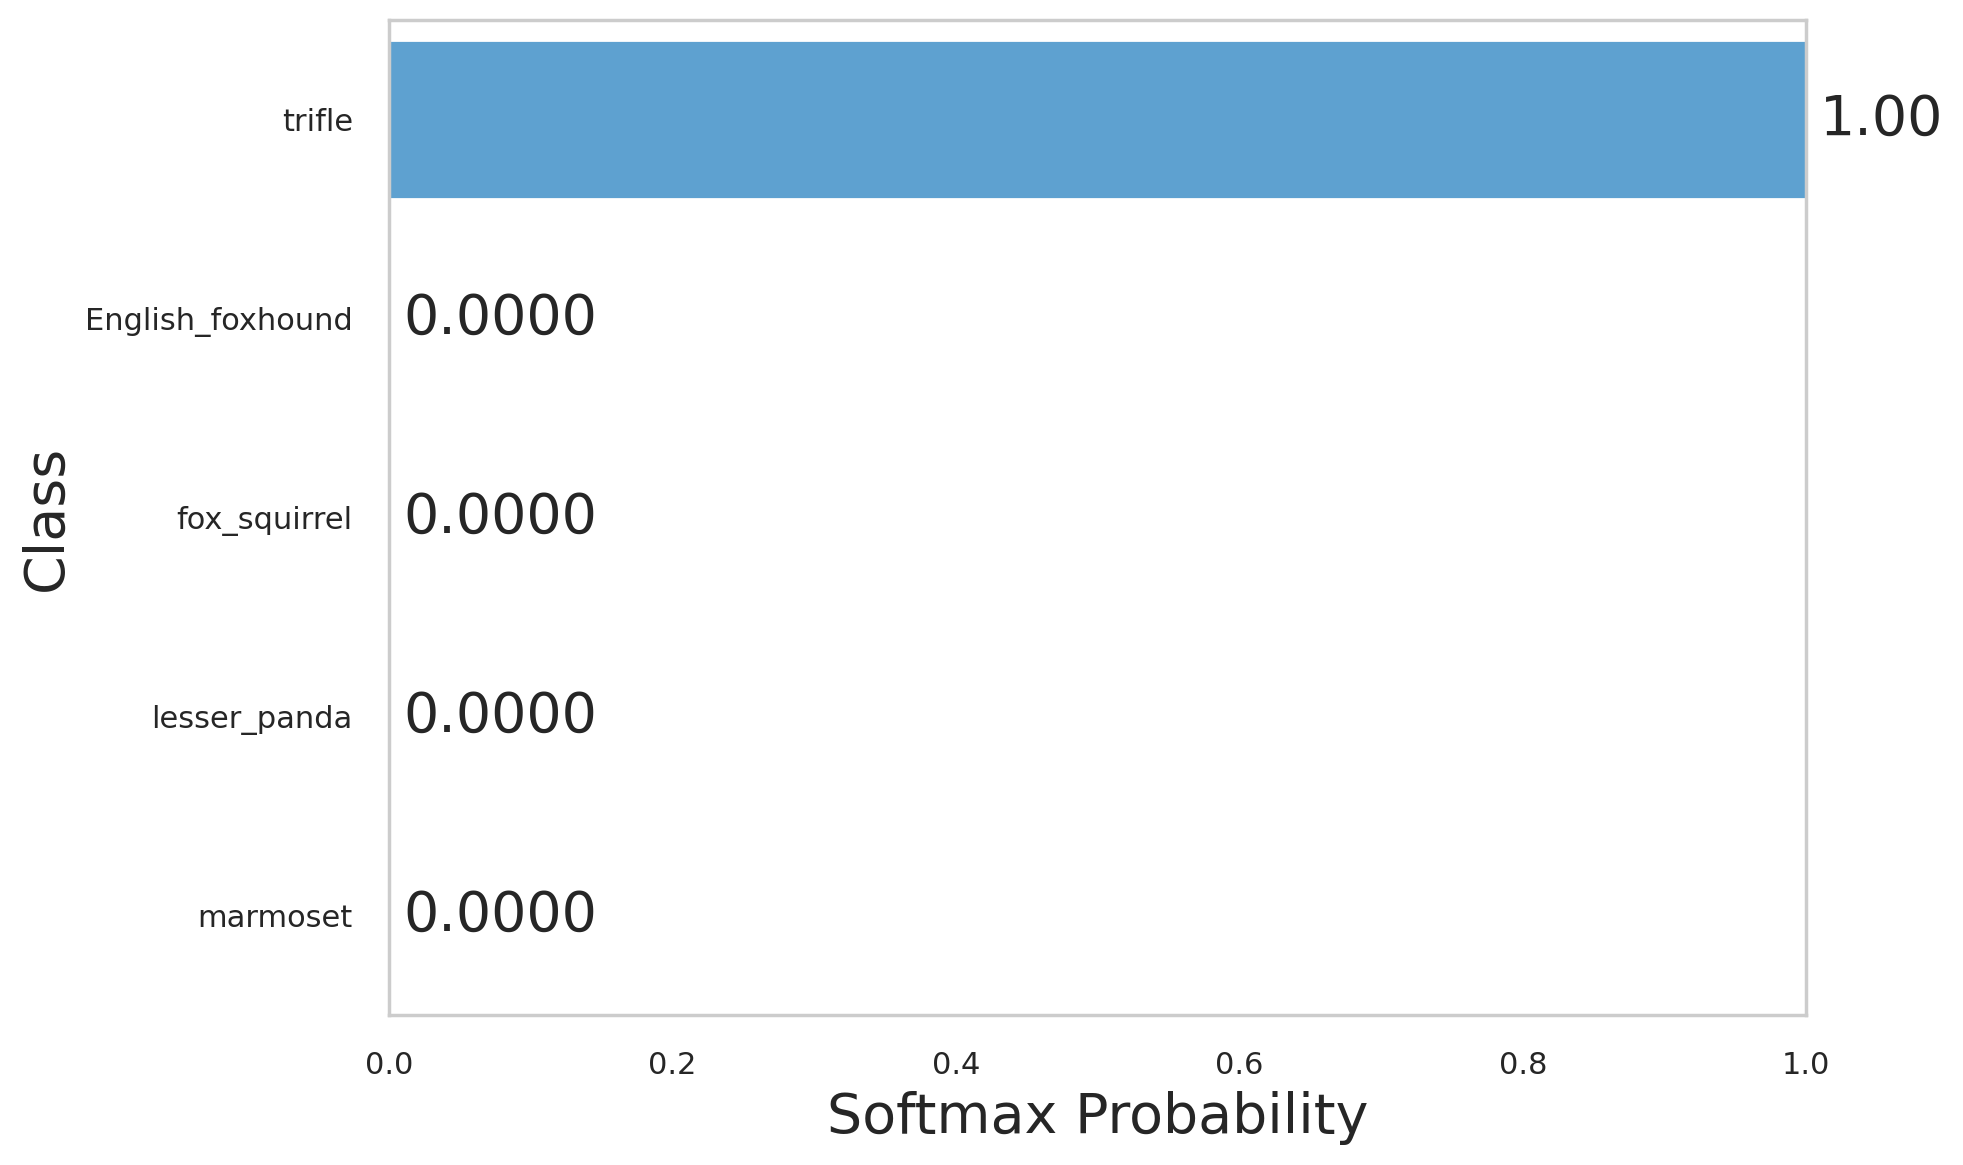

<ipython-input-27-16c8652d2dda>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


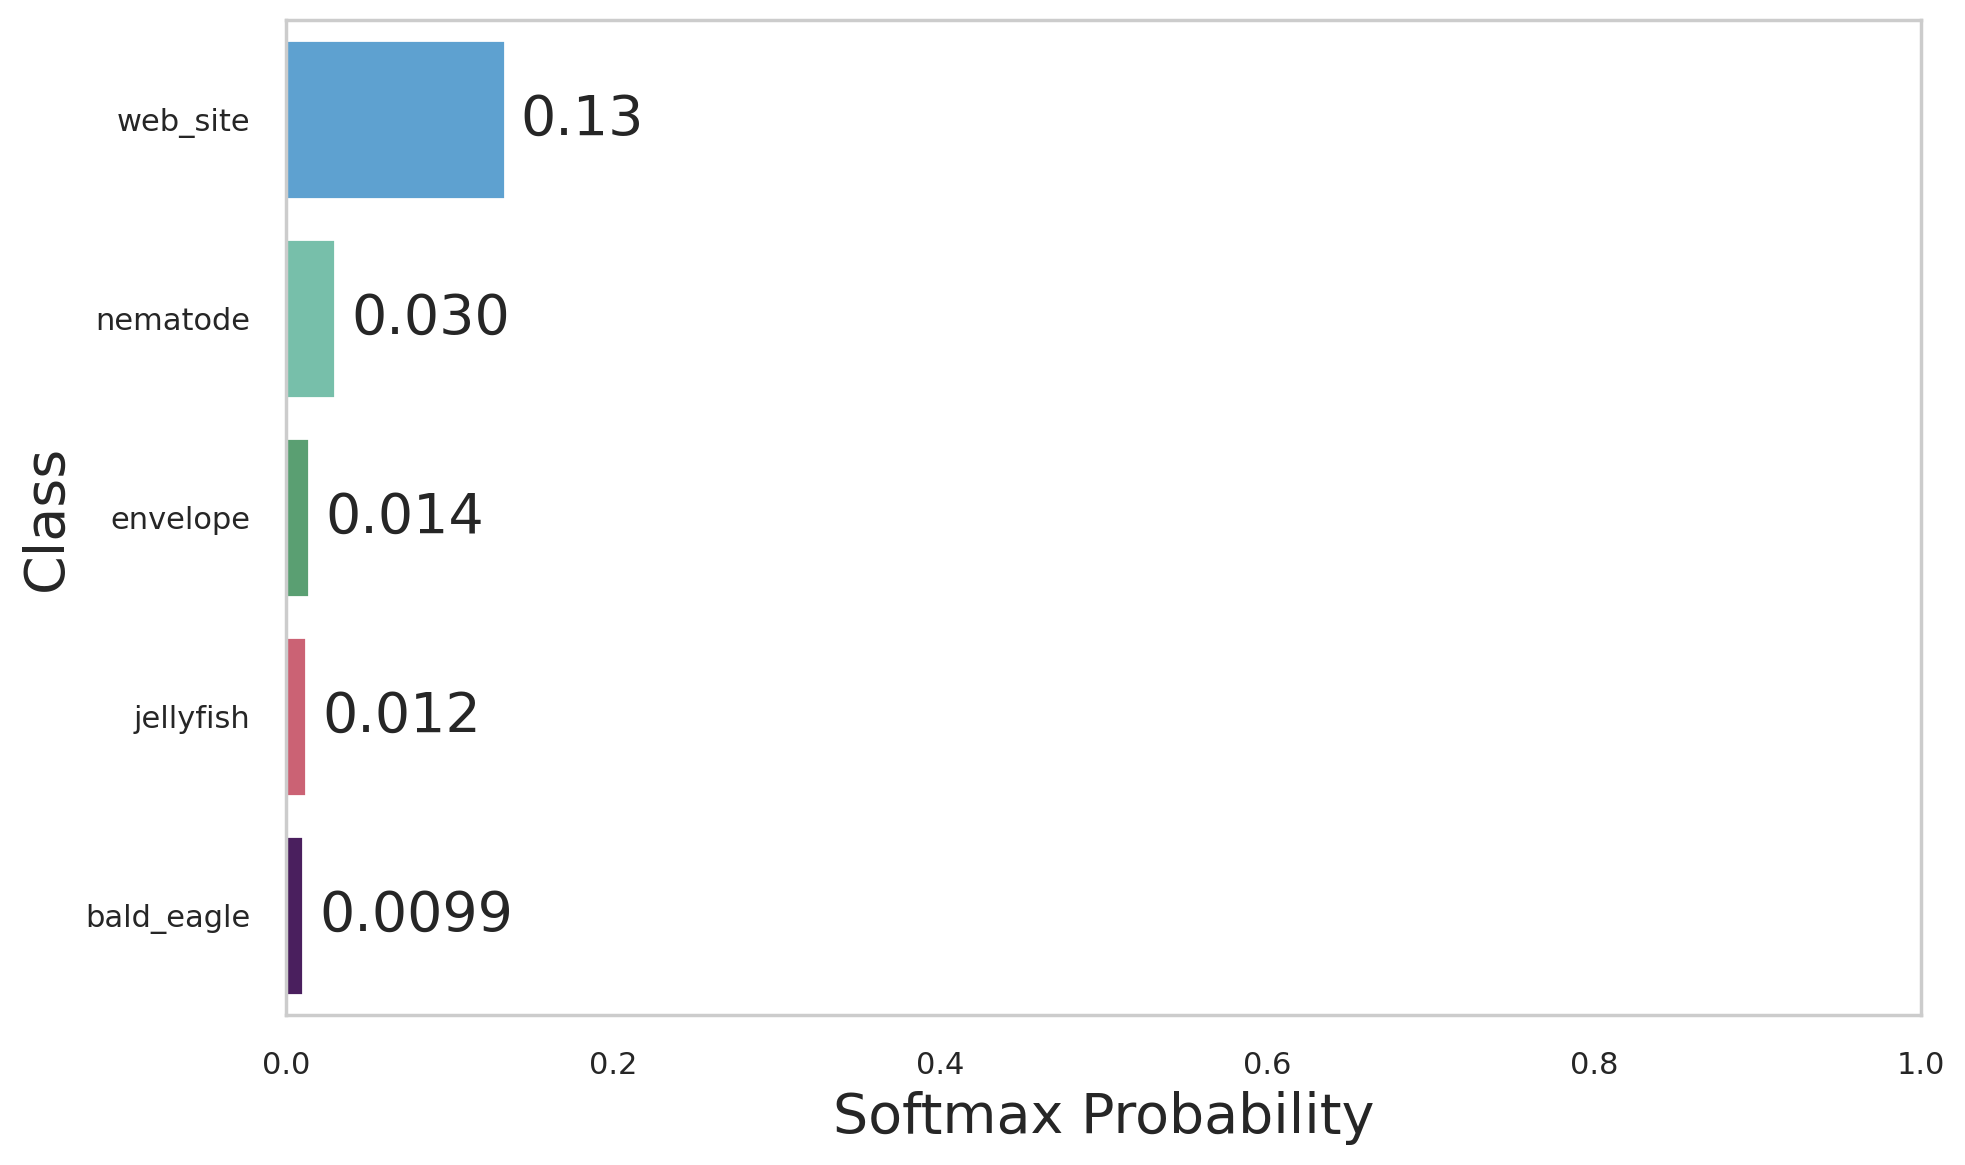

<ipython-input-27-16c8652d2dda>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


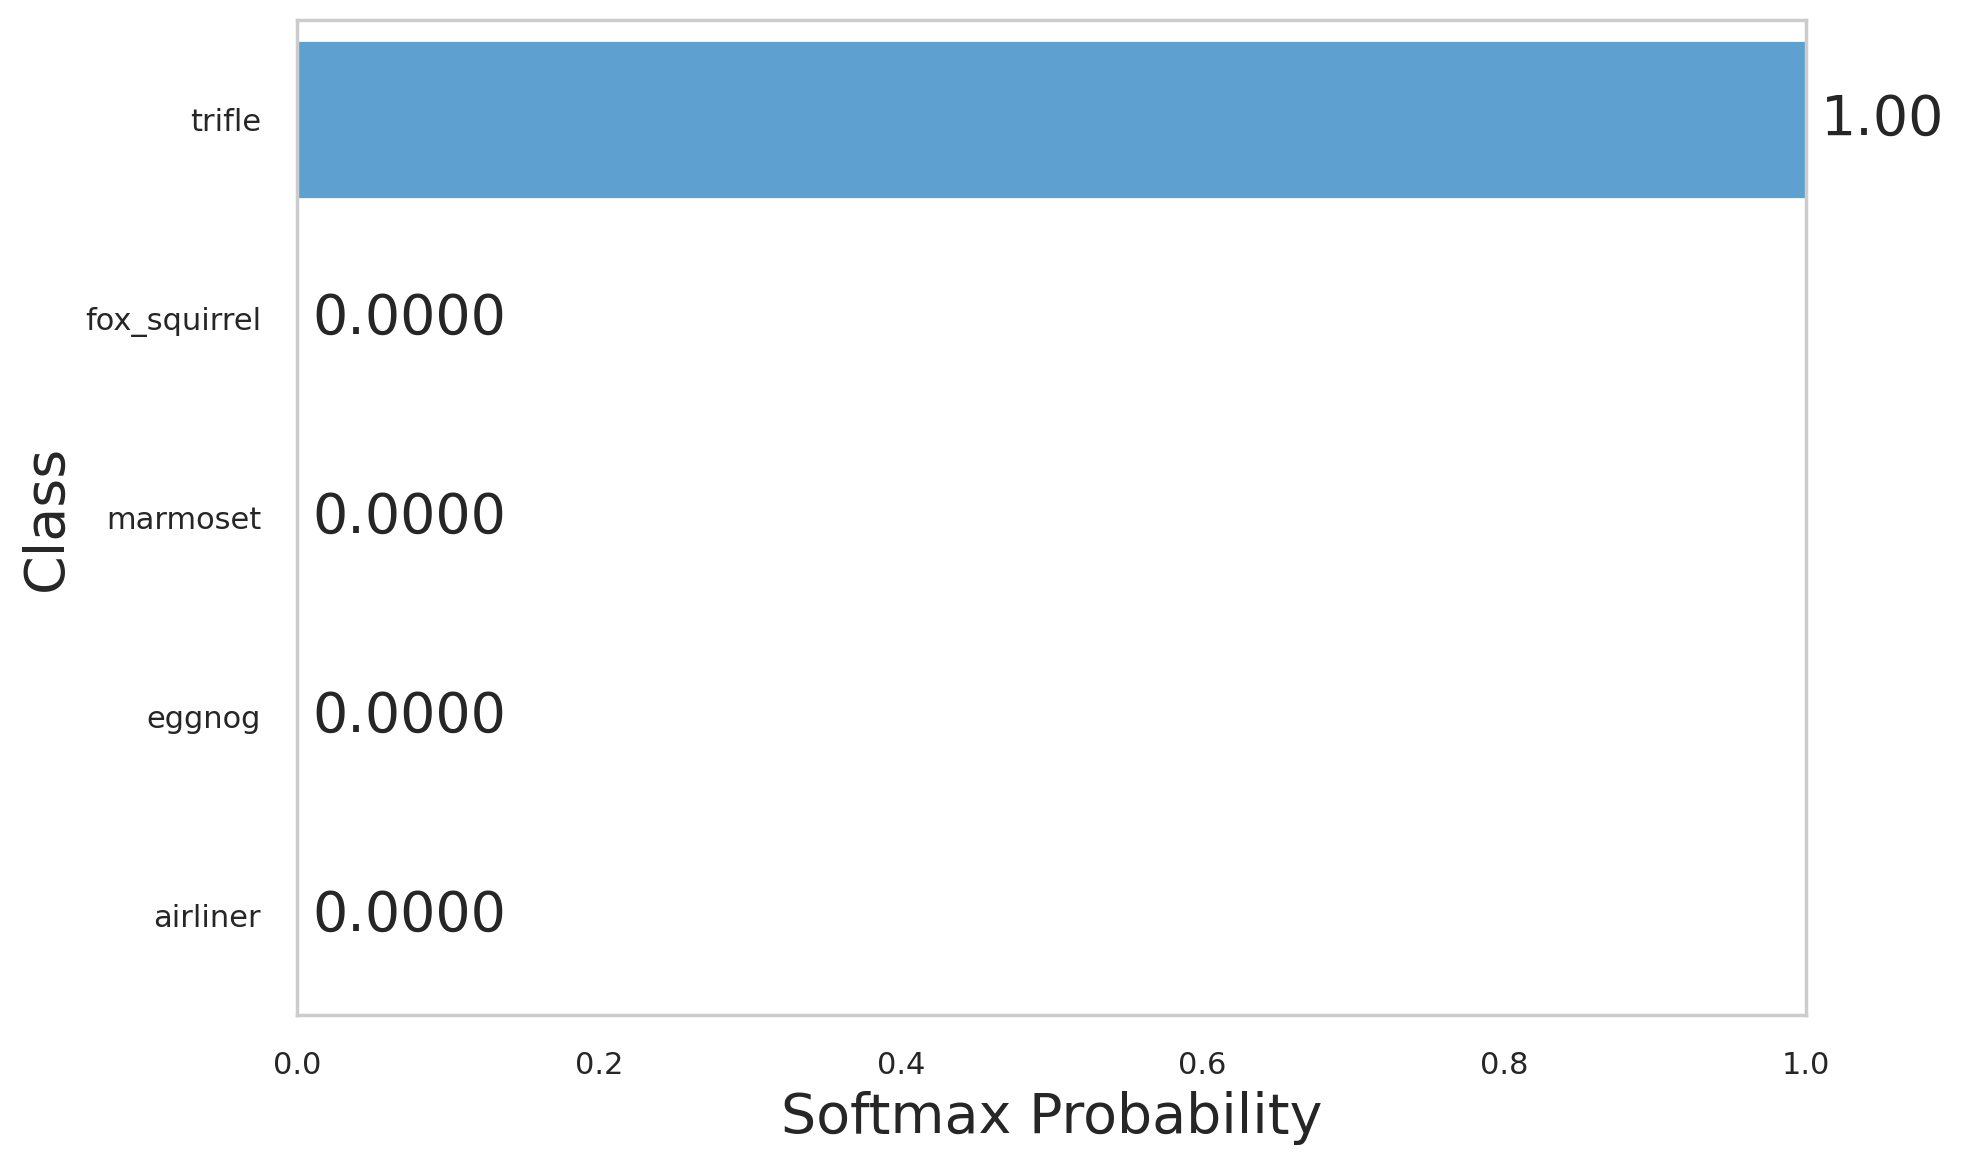

<ipython-input-27-16c8652d2dda>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


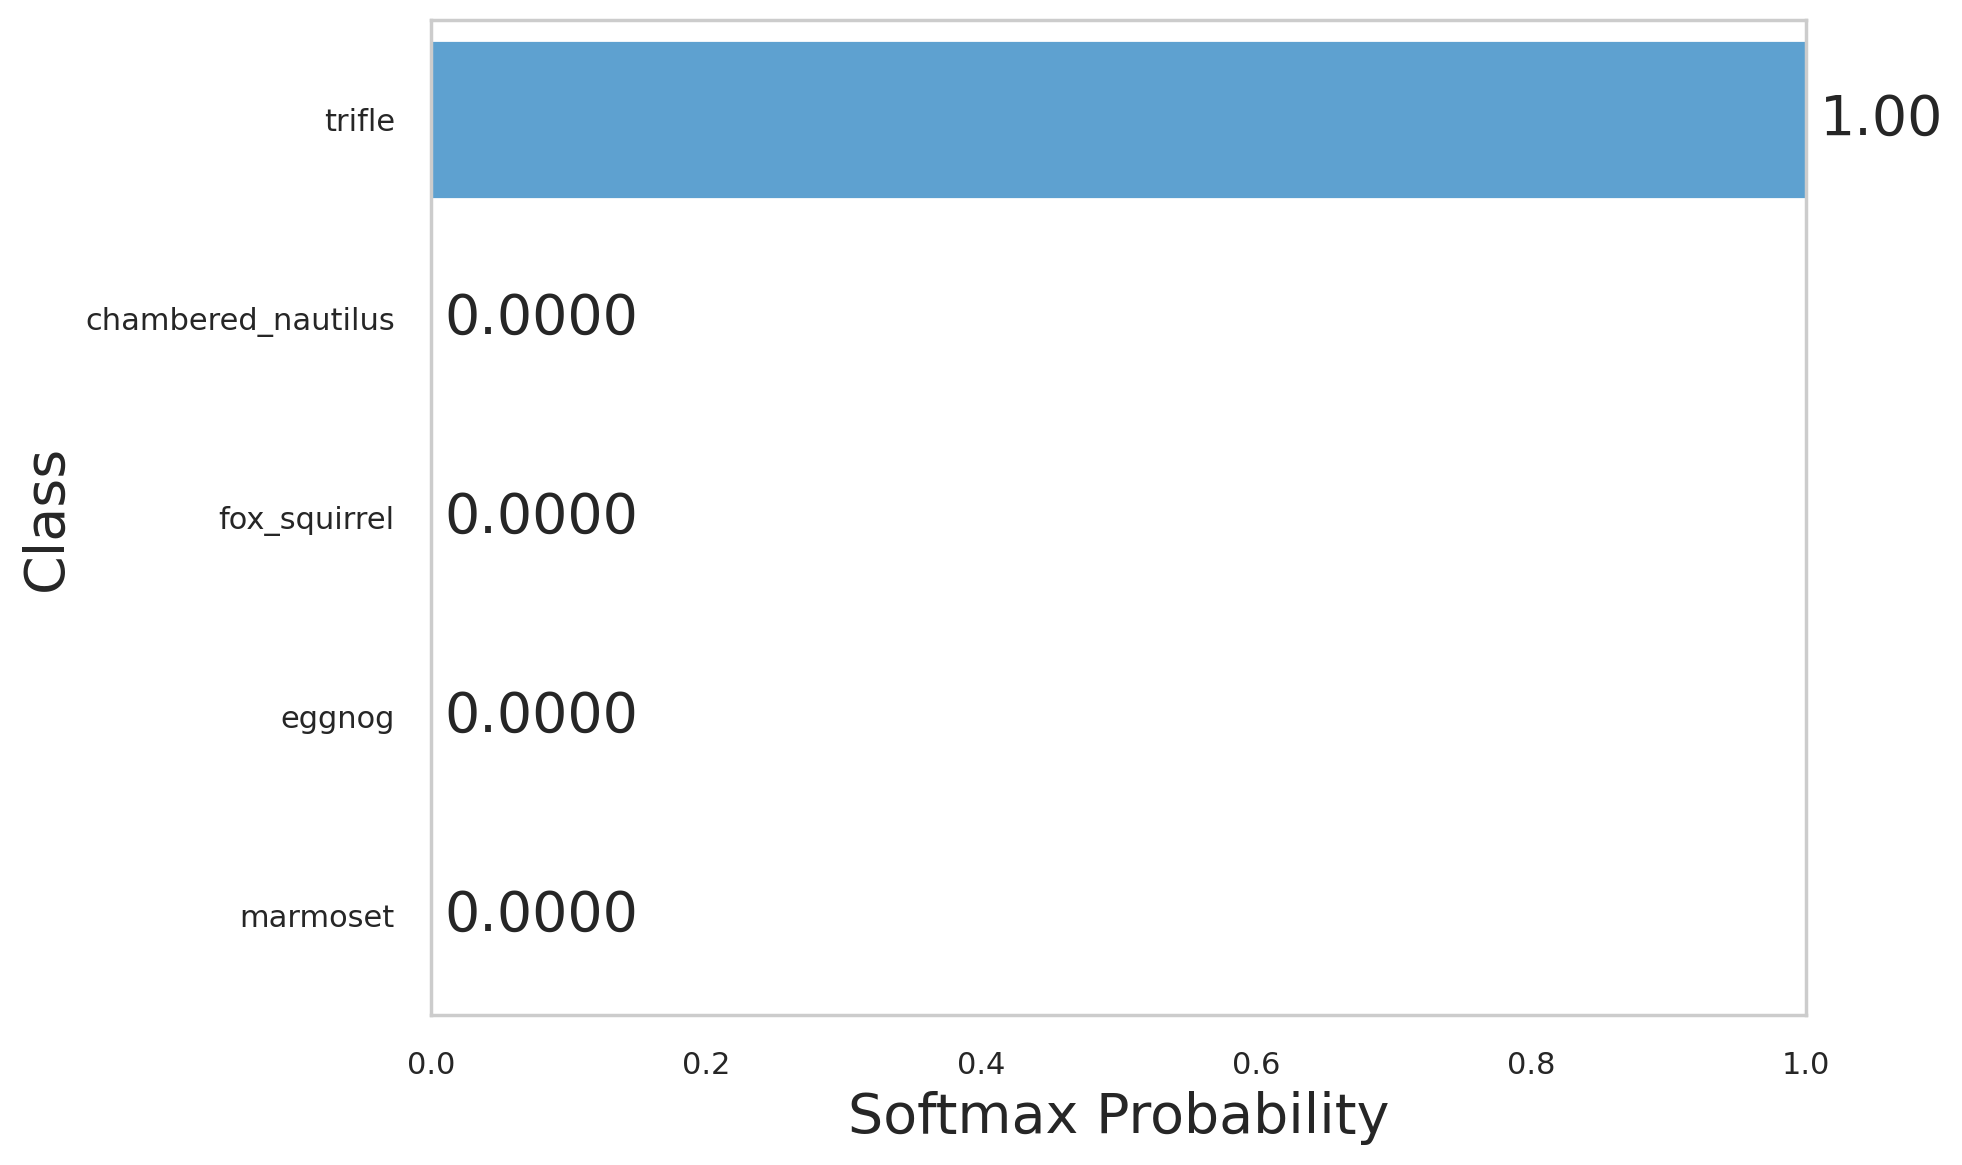

In [28]:
plot_top5_predictions(classifications_r50)

### Improvement for readability

In [37]:
def plot_top5_predictions(data: dict):
    """
    Generates bar plots for the top 5 class predictions for each baseline with corresponding softmax probabilities.
    Adjusts annotations dynamically based on value ranges to ensure readability.

    Args:
    data (dict): A dictionary with keys as tuples (baseline_name, type) where type is either 'classes' or 'softmax',
                 and values are lists representing class indices or softmax probabilities respectively.
    Raises:
    ValueError: If the data does not contain corresponding 'classes' and 'softmax' for each baseline.
    """
    sns.set(style="whitegrid")

    # Define custom colors and background color
    colors = [
        [78, 20, 105], [220, 81, 104], [55, 125, 163],
        [75, 165, 227], [79, 170, 111], [107, 203, 175]
    ]
    # Shuffle the colors to use for the bars
    random.shuffle(colors)
    # Convert RGB to normalized format for matplotlib
    colors = list(np.array(colors) / 255.0)
    background_color = list(np.array([234, 234, 242]) / 255.0)

    # Set the figure's background color to white
    plt.rcParams['figure.facecolor'] = 'white'

    # Font sizes for readability in a 3x2 grid
    title_fontsize = 22
    label_fontsize = 24
    annotation_fontsize = 20
    ytick_fontsize = 20

    # Iterate through the baselines and gather data for plotting
    for key in data.keys():
        if key[1] == 'classes':
            baseline_name = key[0]
            classes_key = (baseline_name, 'classes')
            softmax_key = (baseline_name, 'softmax')

            # Ensure both classes and softmax data are present
            if softmax_key not in data:
                raise ValueError(f"Missing 'softmax' data for {baseline_name}")

            class_labels = data[classes_key]
            softmax_probs = data[softmax_key]

            # Prepare the DataFrame for plotting
            df = pd.DataFrame({
                'Class': class_labels,
                'Probability': softmax_probs
            })

            # Plotting
            plt.figure(figsize=(10, 6))
            bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])
            bar_plot.set_title(f'Top 5 Predictions for {baseline_name}', fontsize=title_fontsize)
            bar_plot.set_xlabel('Softmax Probability', fontsize=label_fontsize)
            bar_plot.set_ylabel('Class', fontsize=label_fontsize)
            bar_plot.set_xlim(0.0, 1.0)

            # Improve plot aesthetics with dynamic text annotations
            for p in bar_plot.patches:
                width = p.get_width()
                # Adjust number of decimal places based on the range of values
                if width > 0.1:
                    annotation = f'{width:.2f}'
                elif width > 0.01:
                    annotation = f'{width:.3f}'
                else:
                    annotation = f'{width:.4f}'
                bar_plot.text(width + 0.01, p.get_y() + p.get_height() / 2,
                              annotation, ha='left', va='center', fontsize=annotation_fontsize)

            # Set larger x-ticks font size
            plt.yticks(fontsize=ytick_fontsize)

            # Remove minor ticks and grid
            bar_plot.xaxis.set_minor_locator(plt.NullLocator())
            bar_plot.yaxis.set_minor_locator(plt.NullLocator())
            bar_plot.grid(False)  # Remove grid

            plt.tight_layout()
            plt.show()

<ipython-input-37-8b670652c975>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


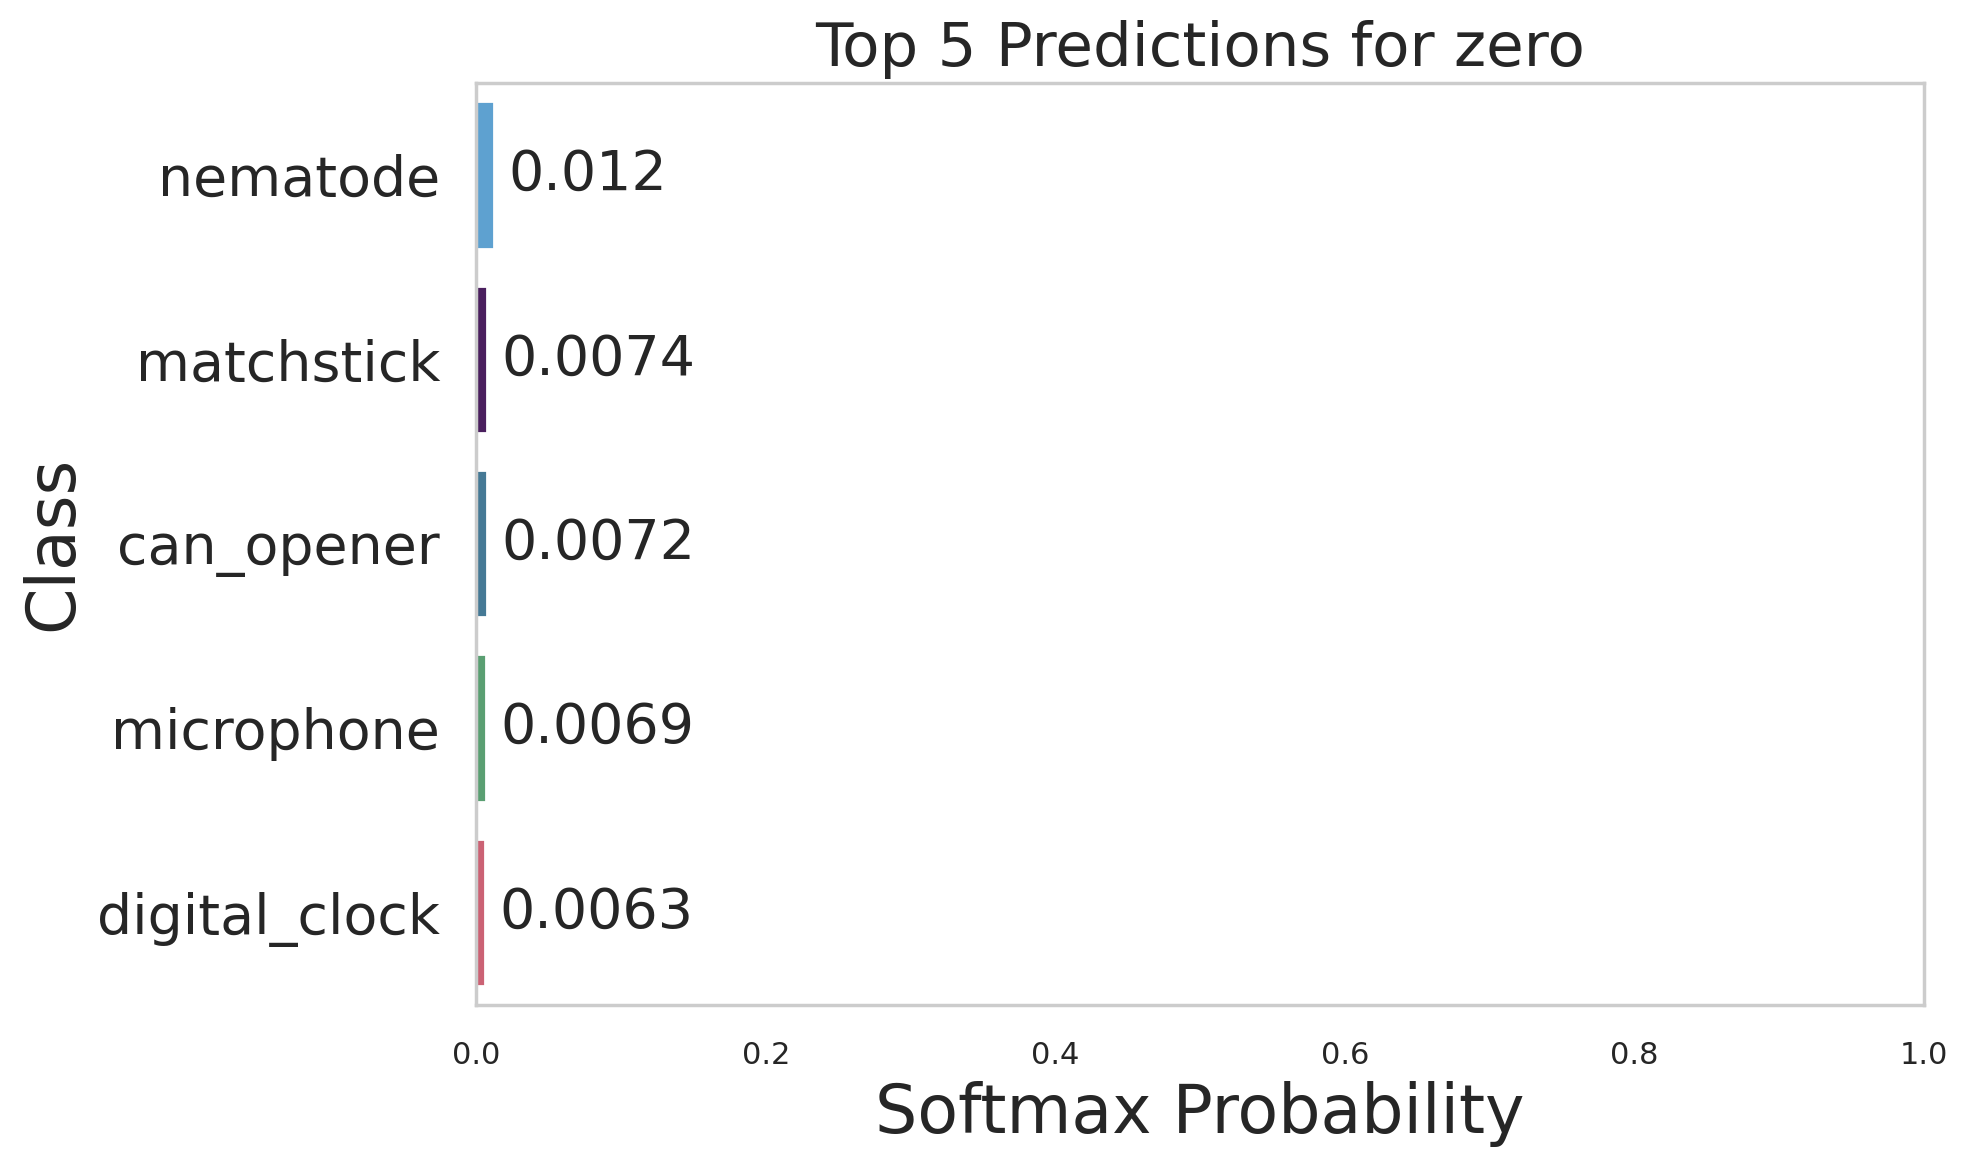

<ipython-input-37-8b670652c975>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


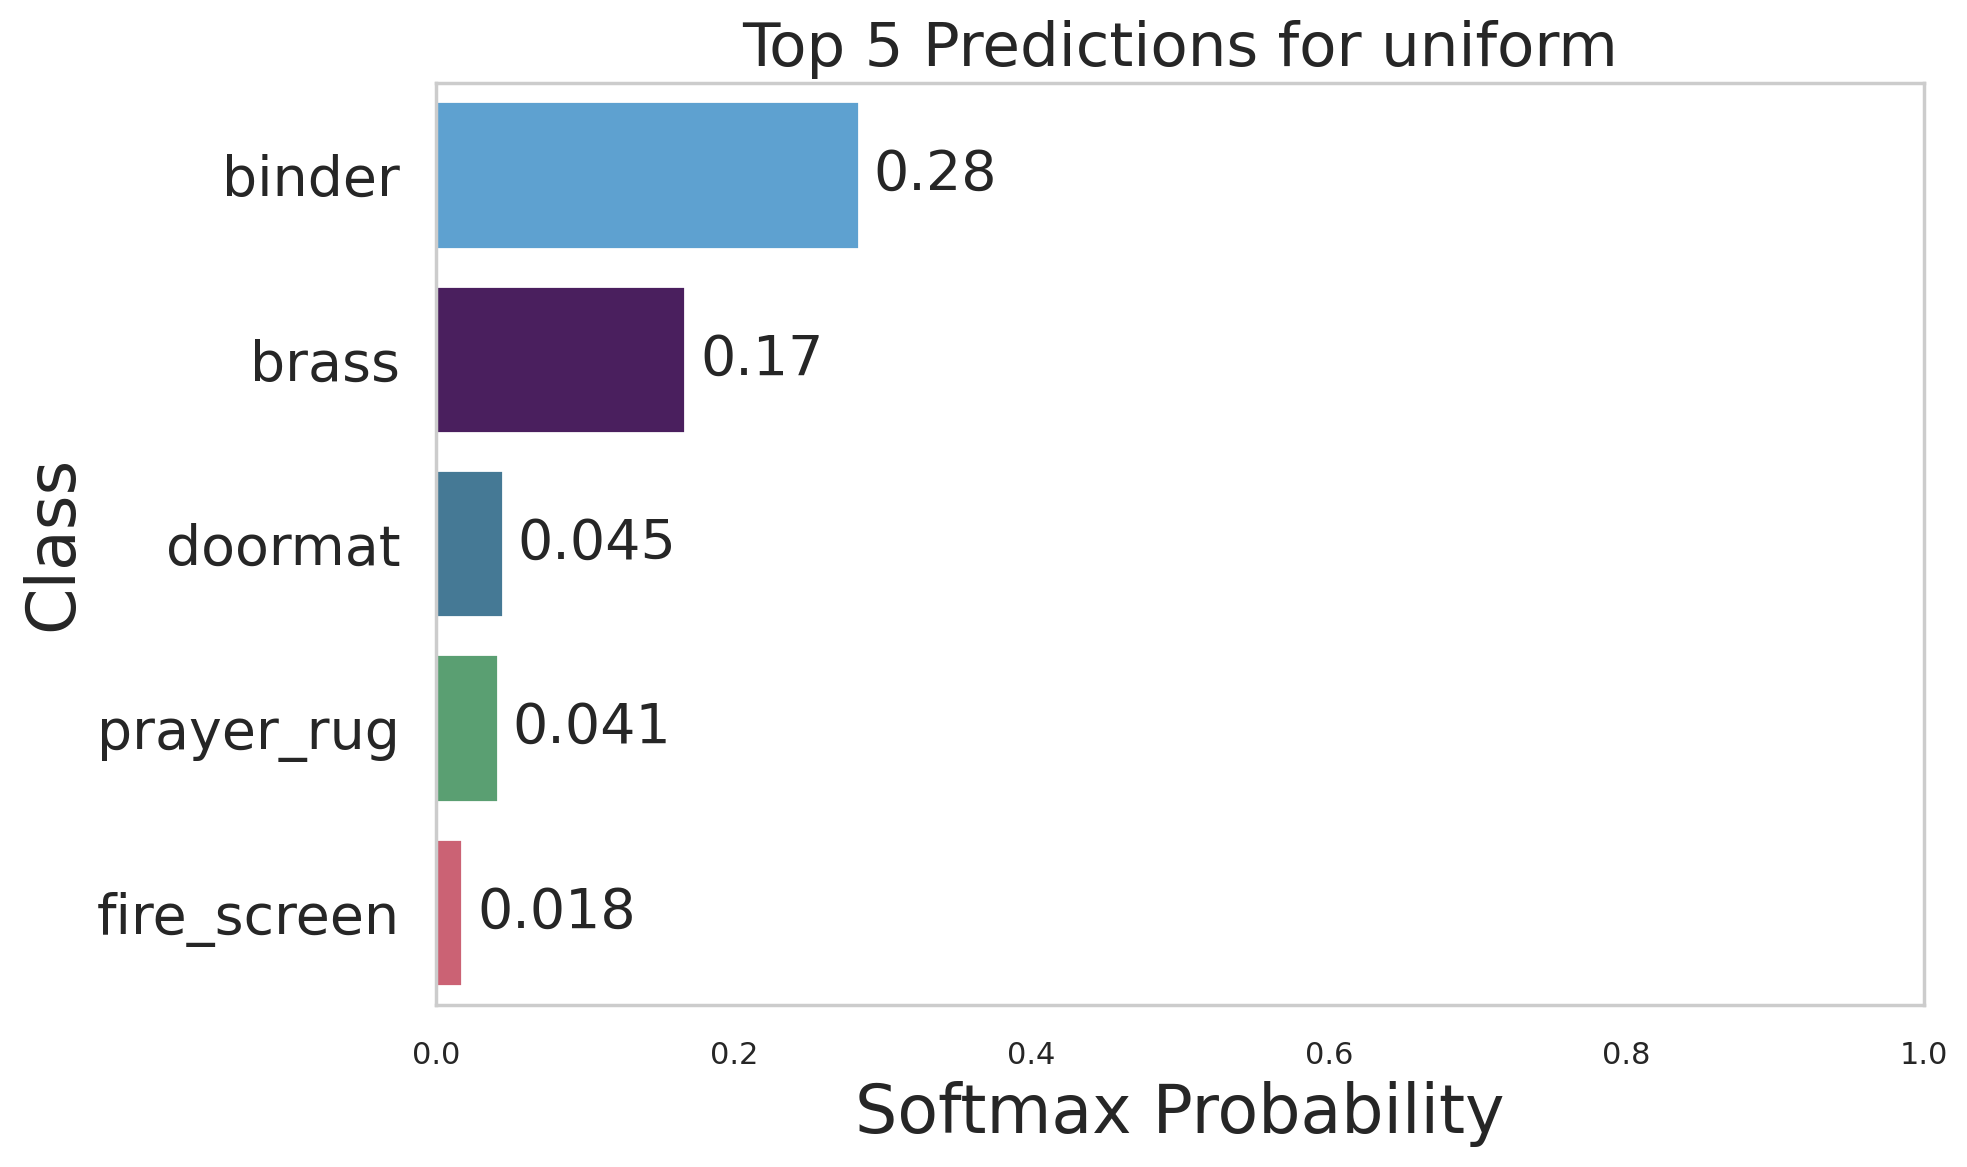

<ipython-input-37-8b670652c975>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


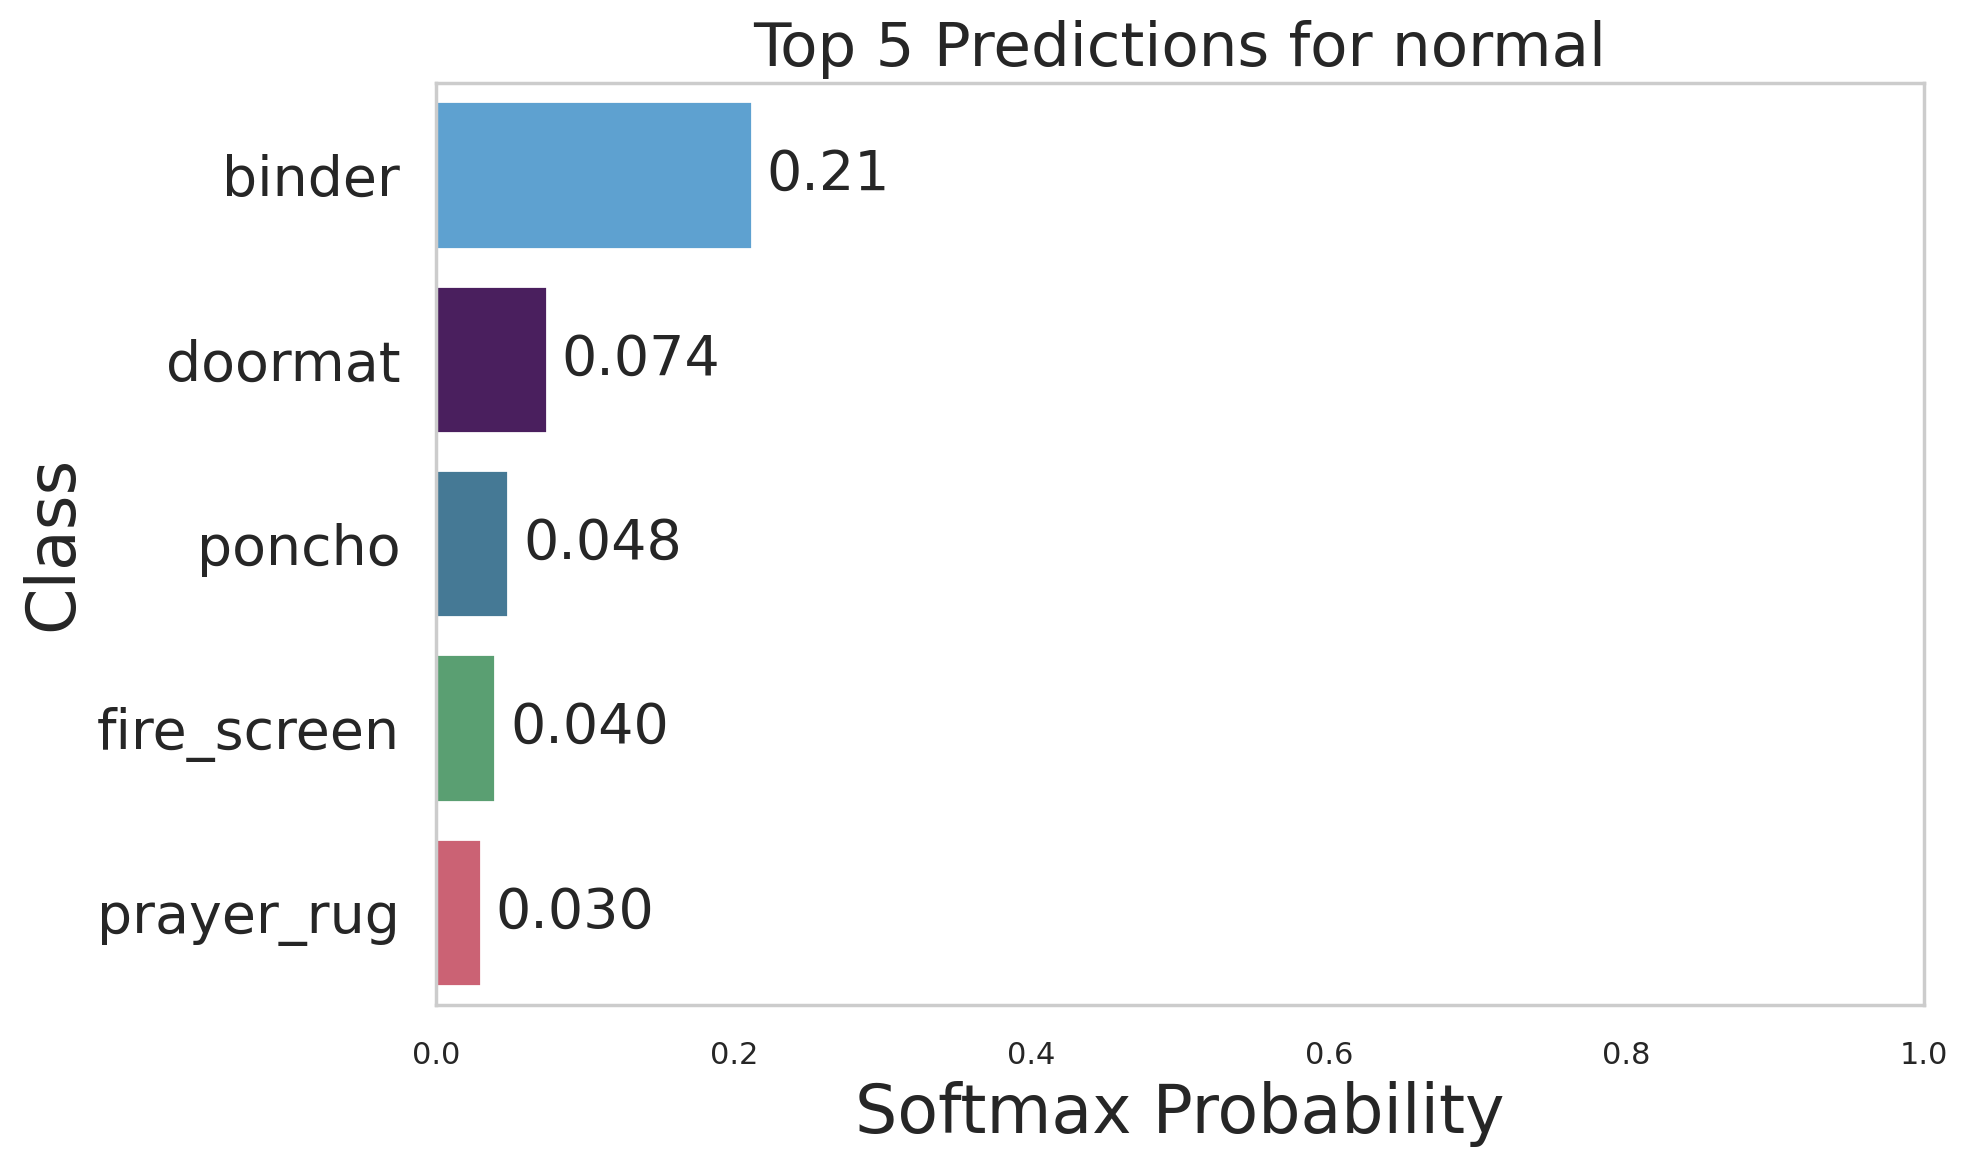

<ipython-input-37-8b670652c975>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


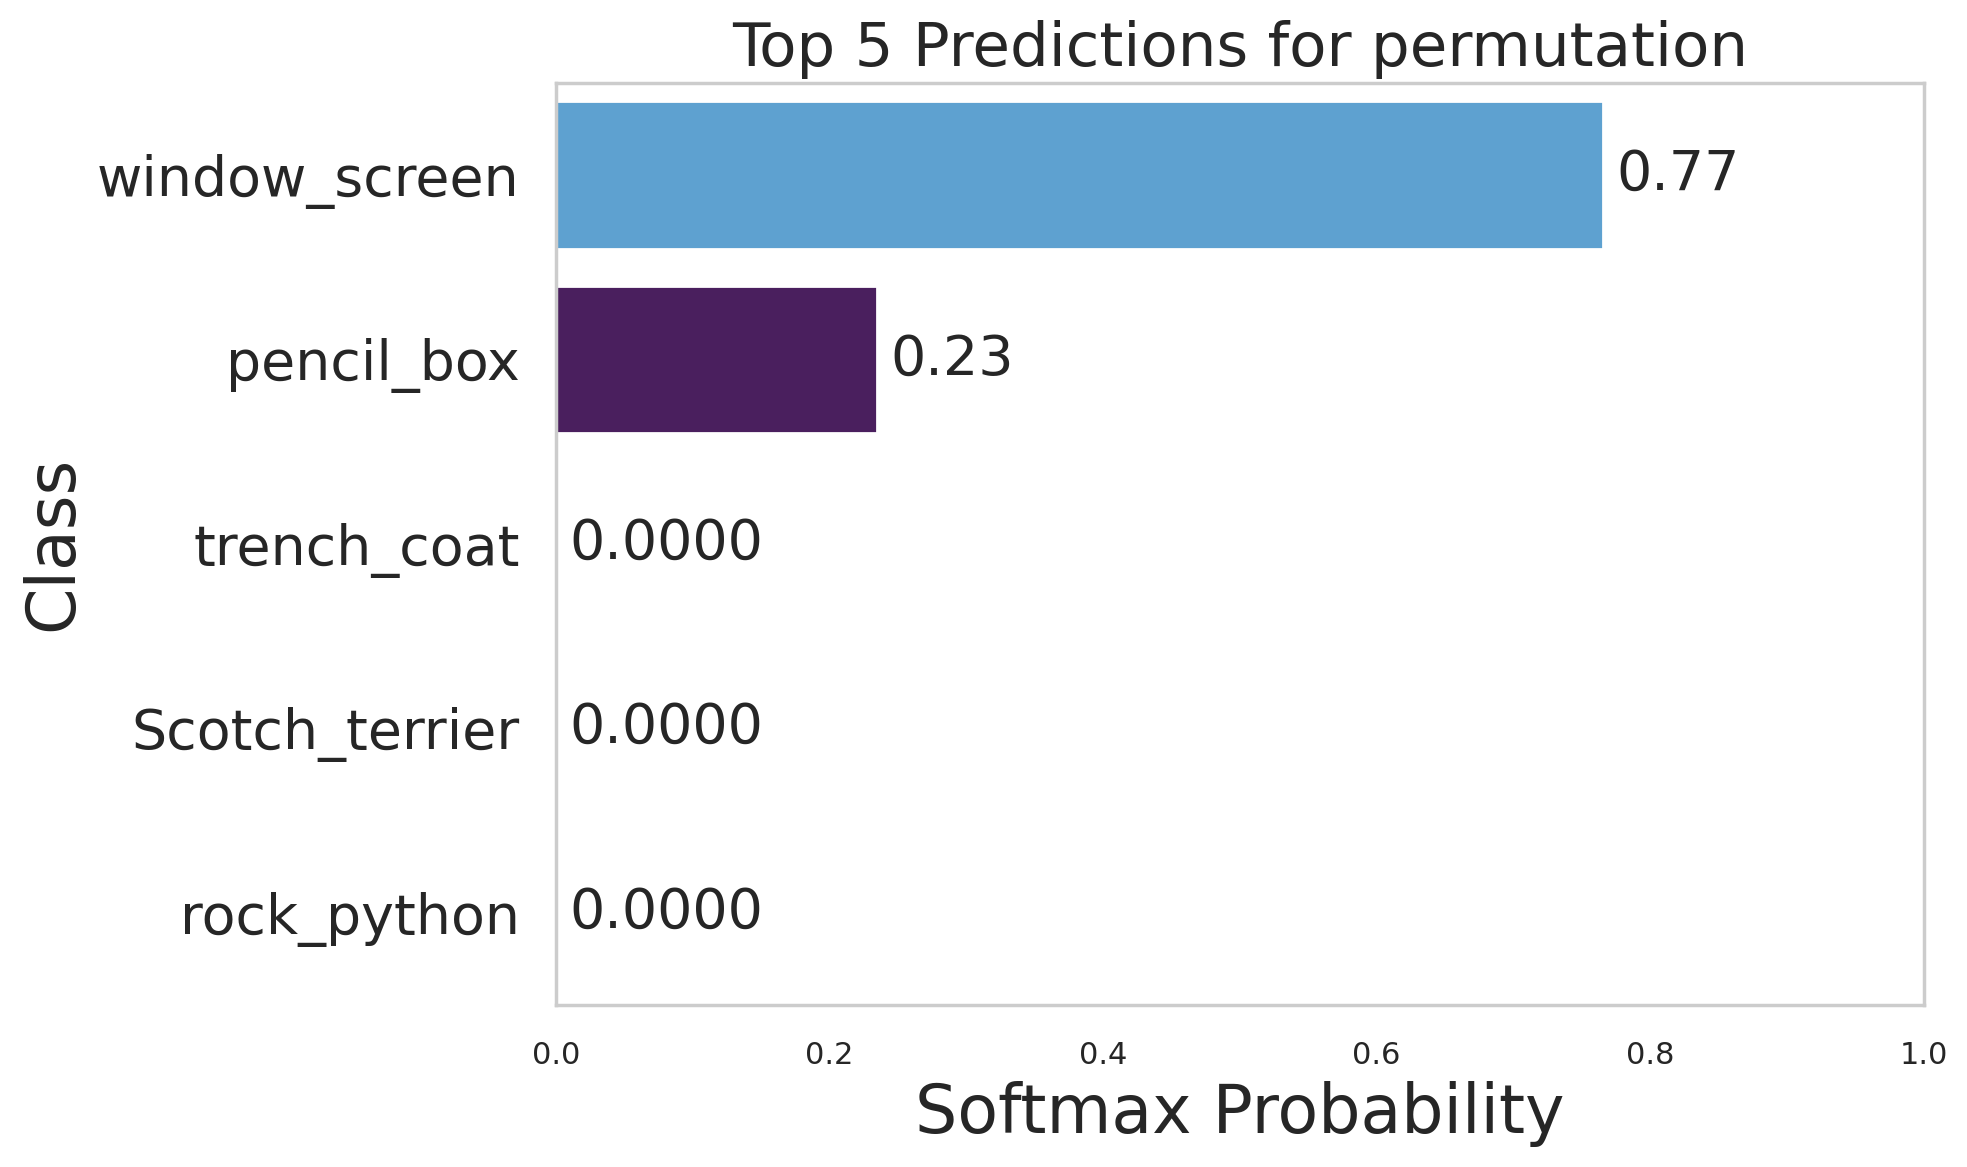

<ipython-input-37-8b670652c975>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


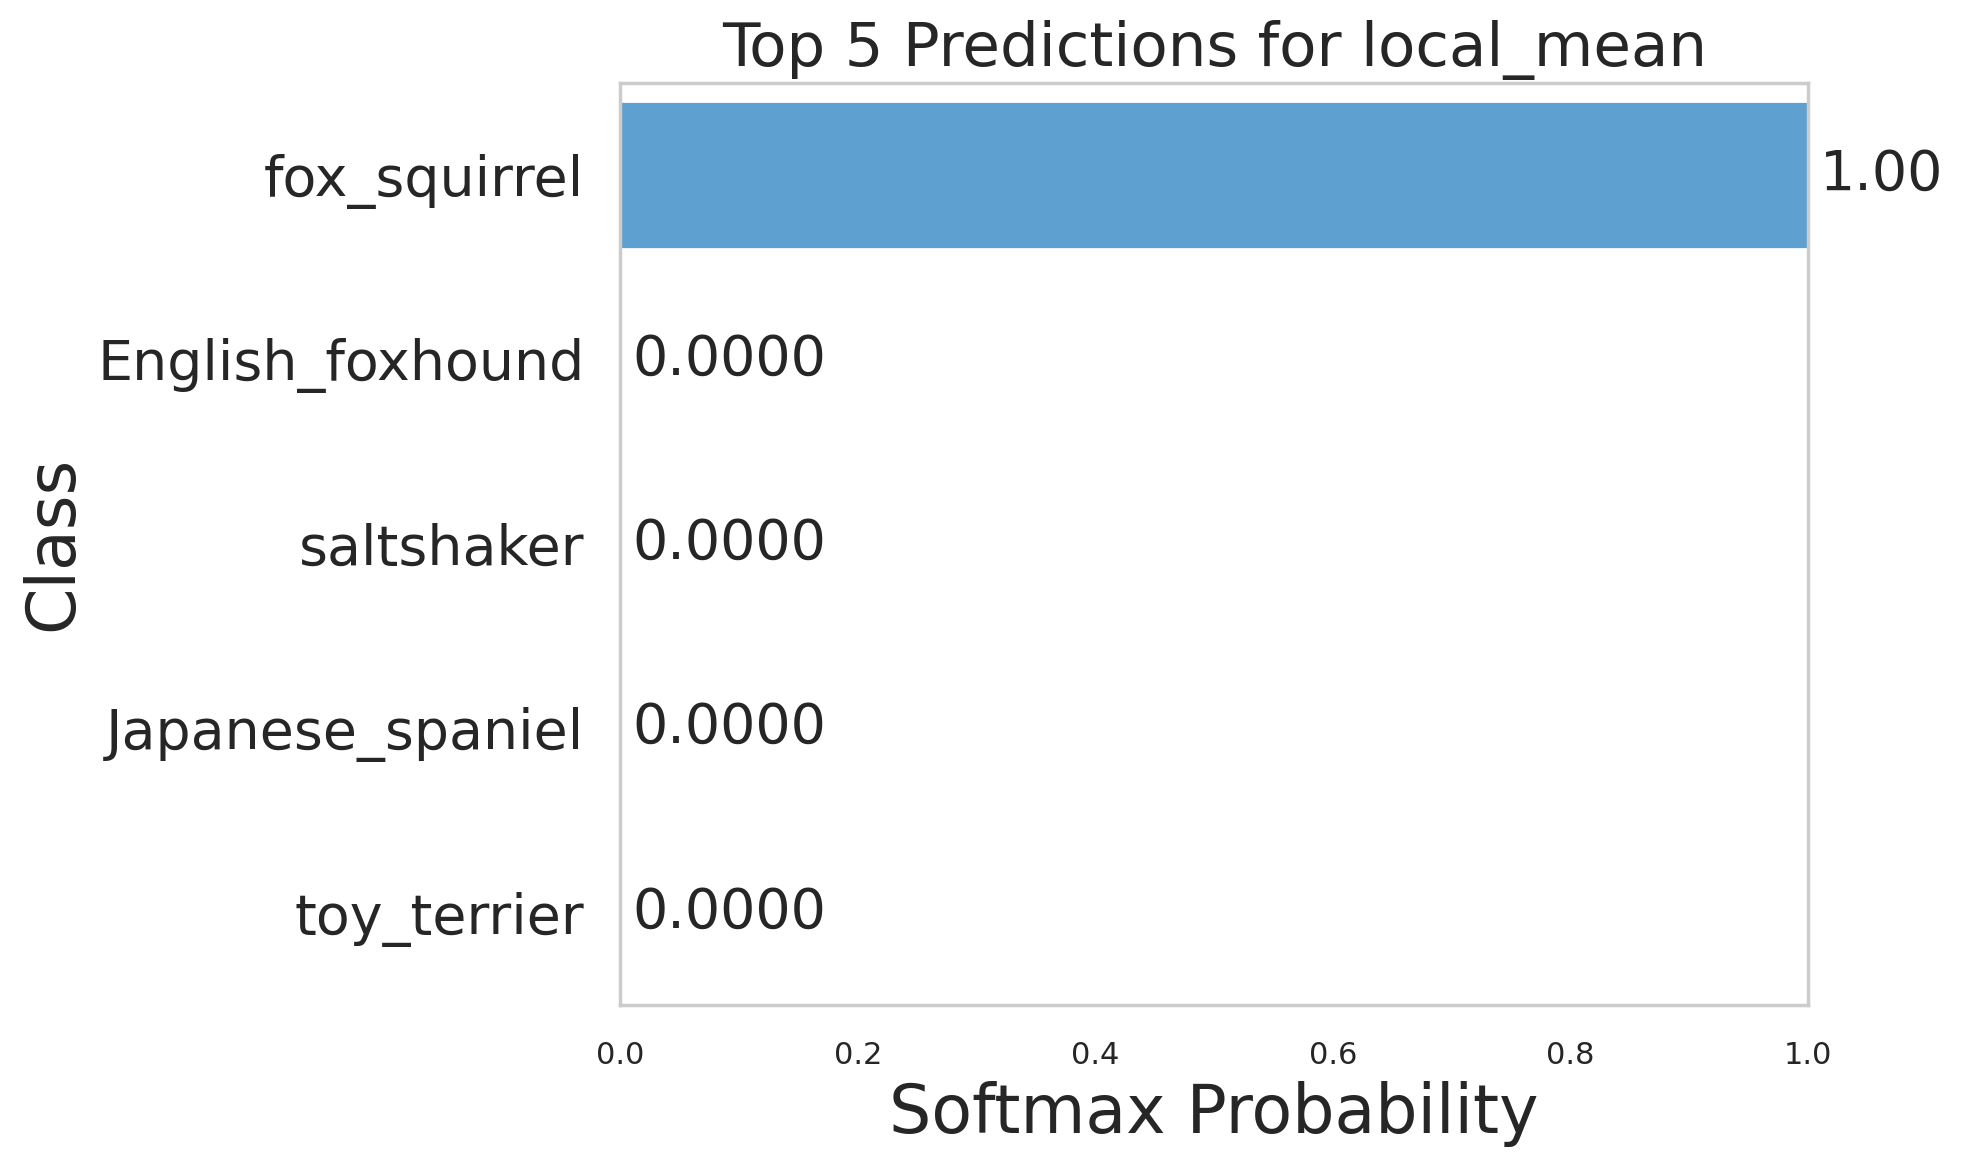

<ipython-input-37-8b670652c975>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


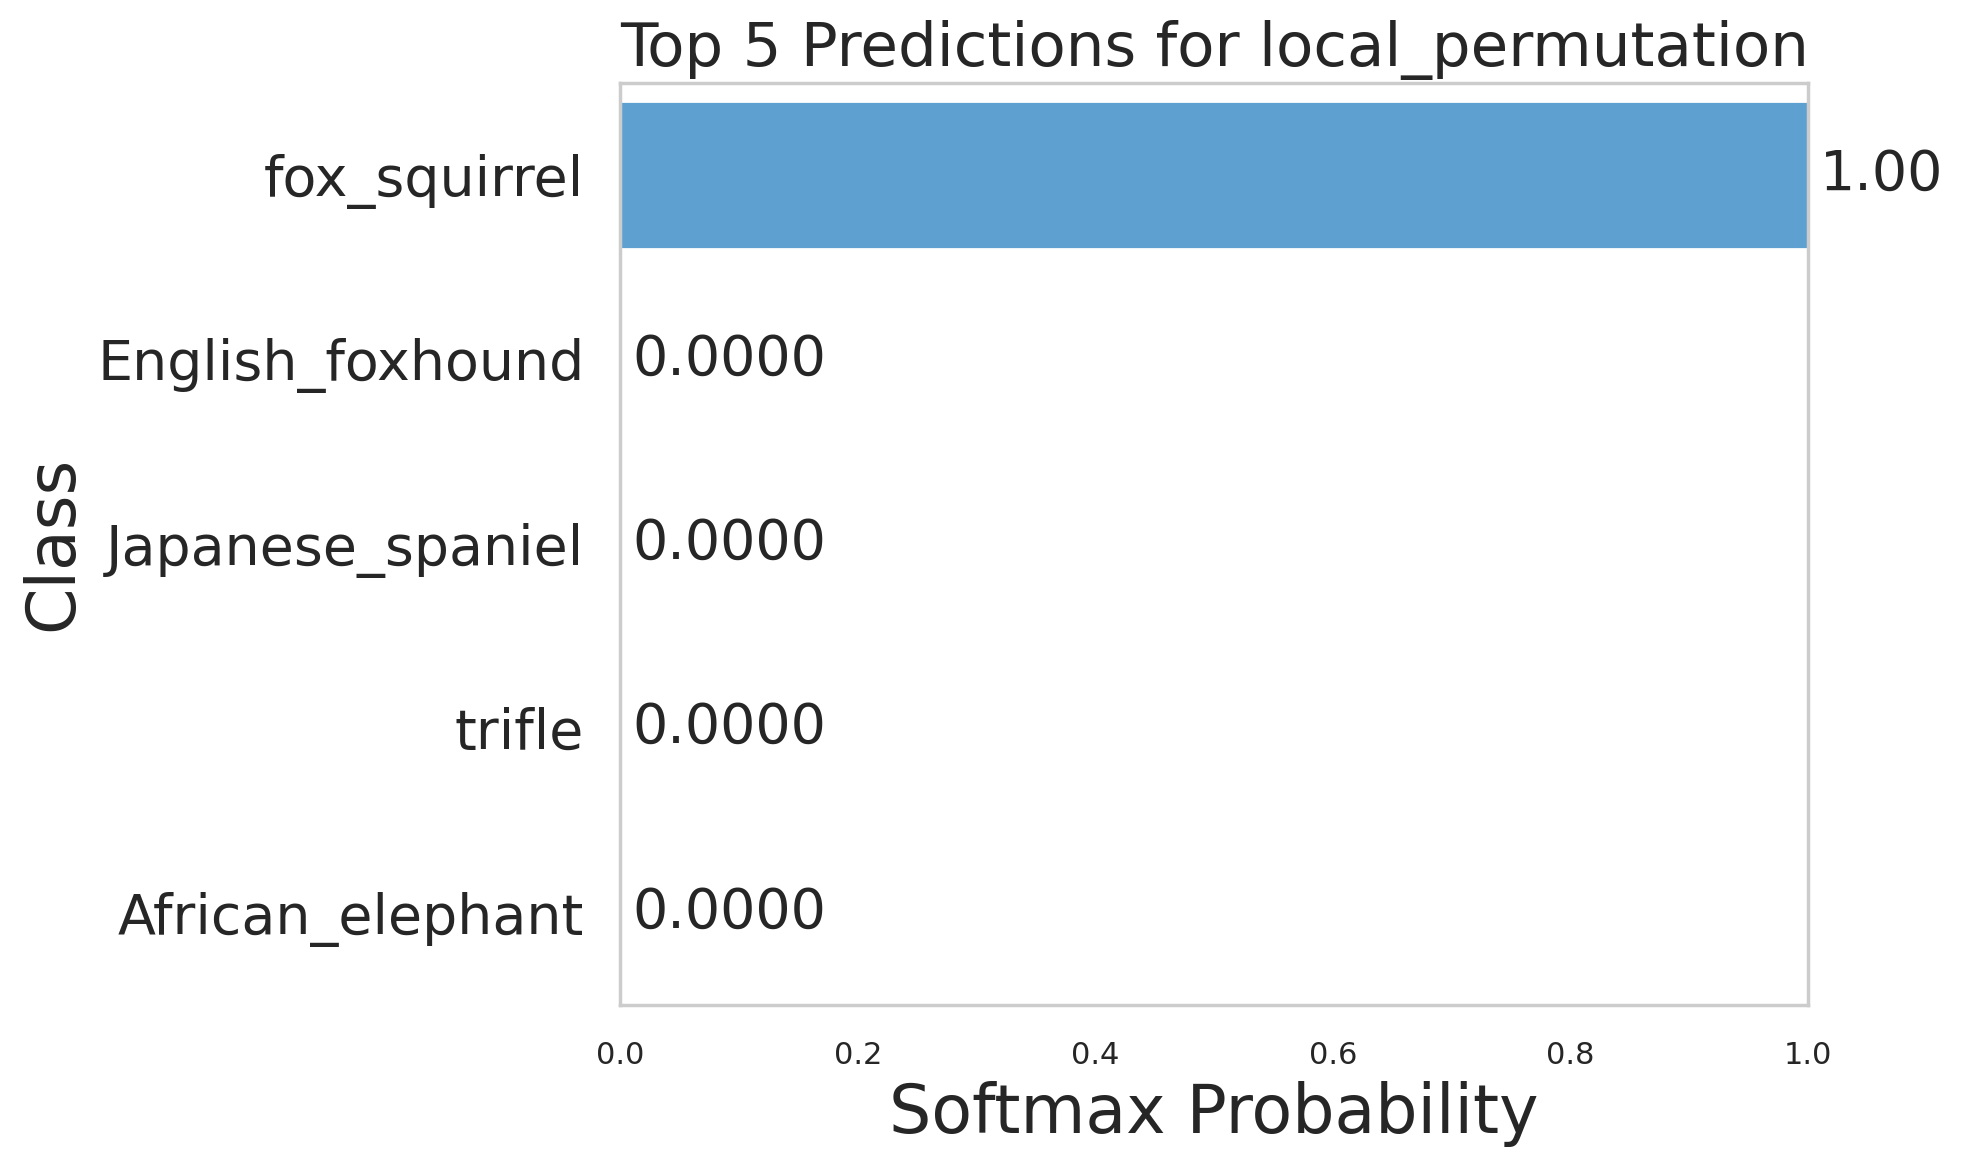

<ipython-input-37-8b670652c975>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


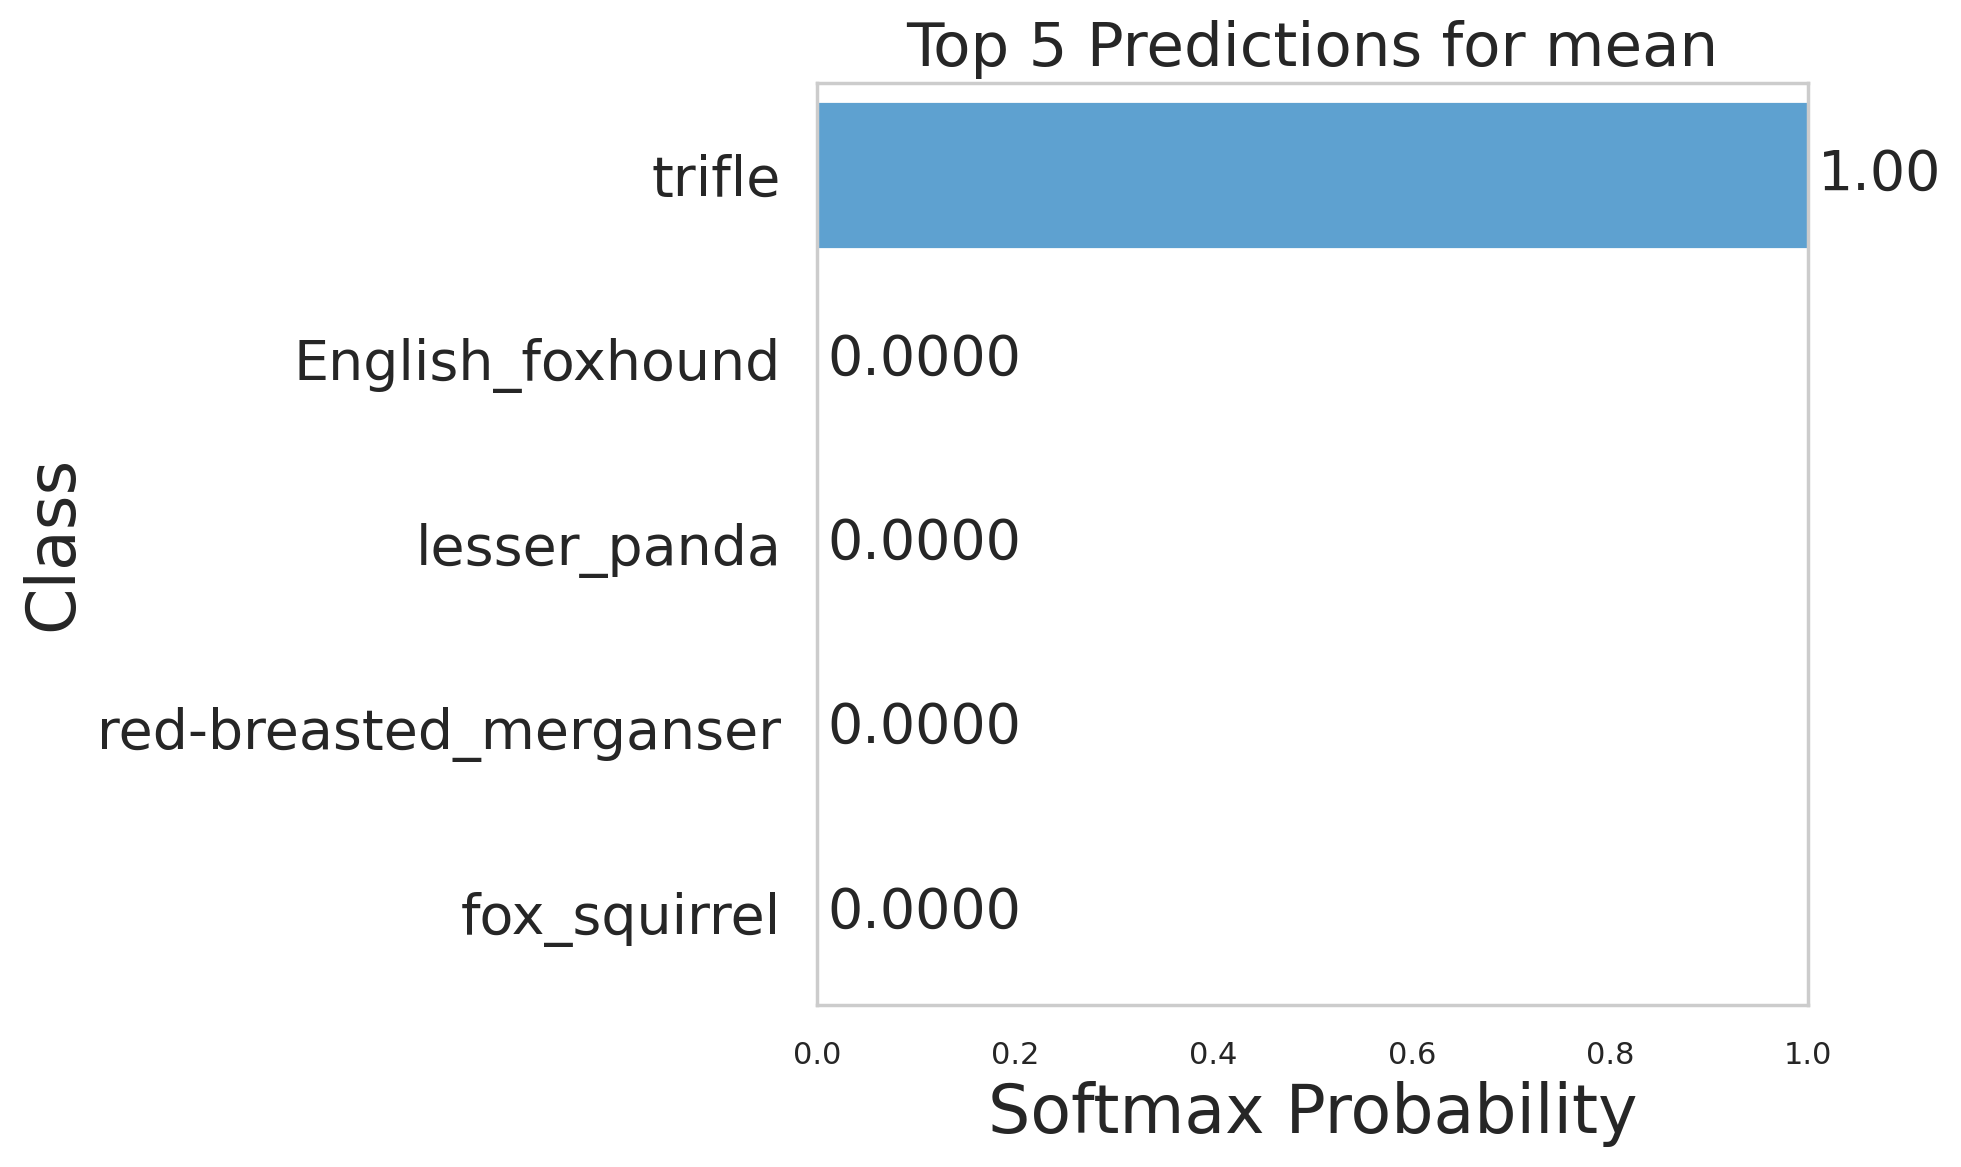

<ipython-input-37-8b670652c975>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


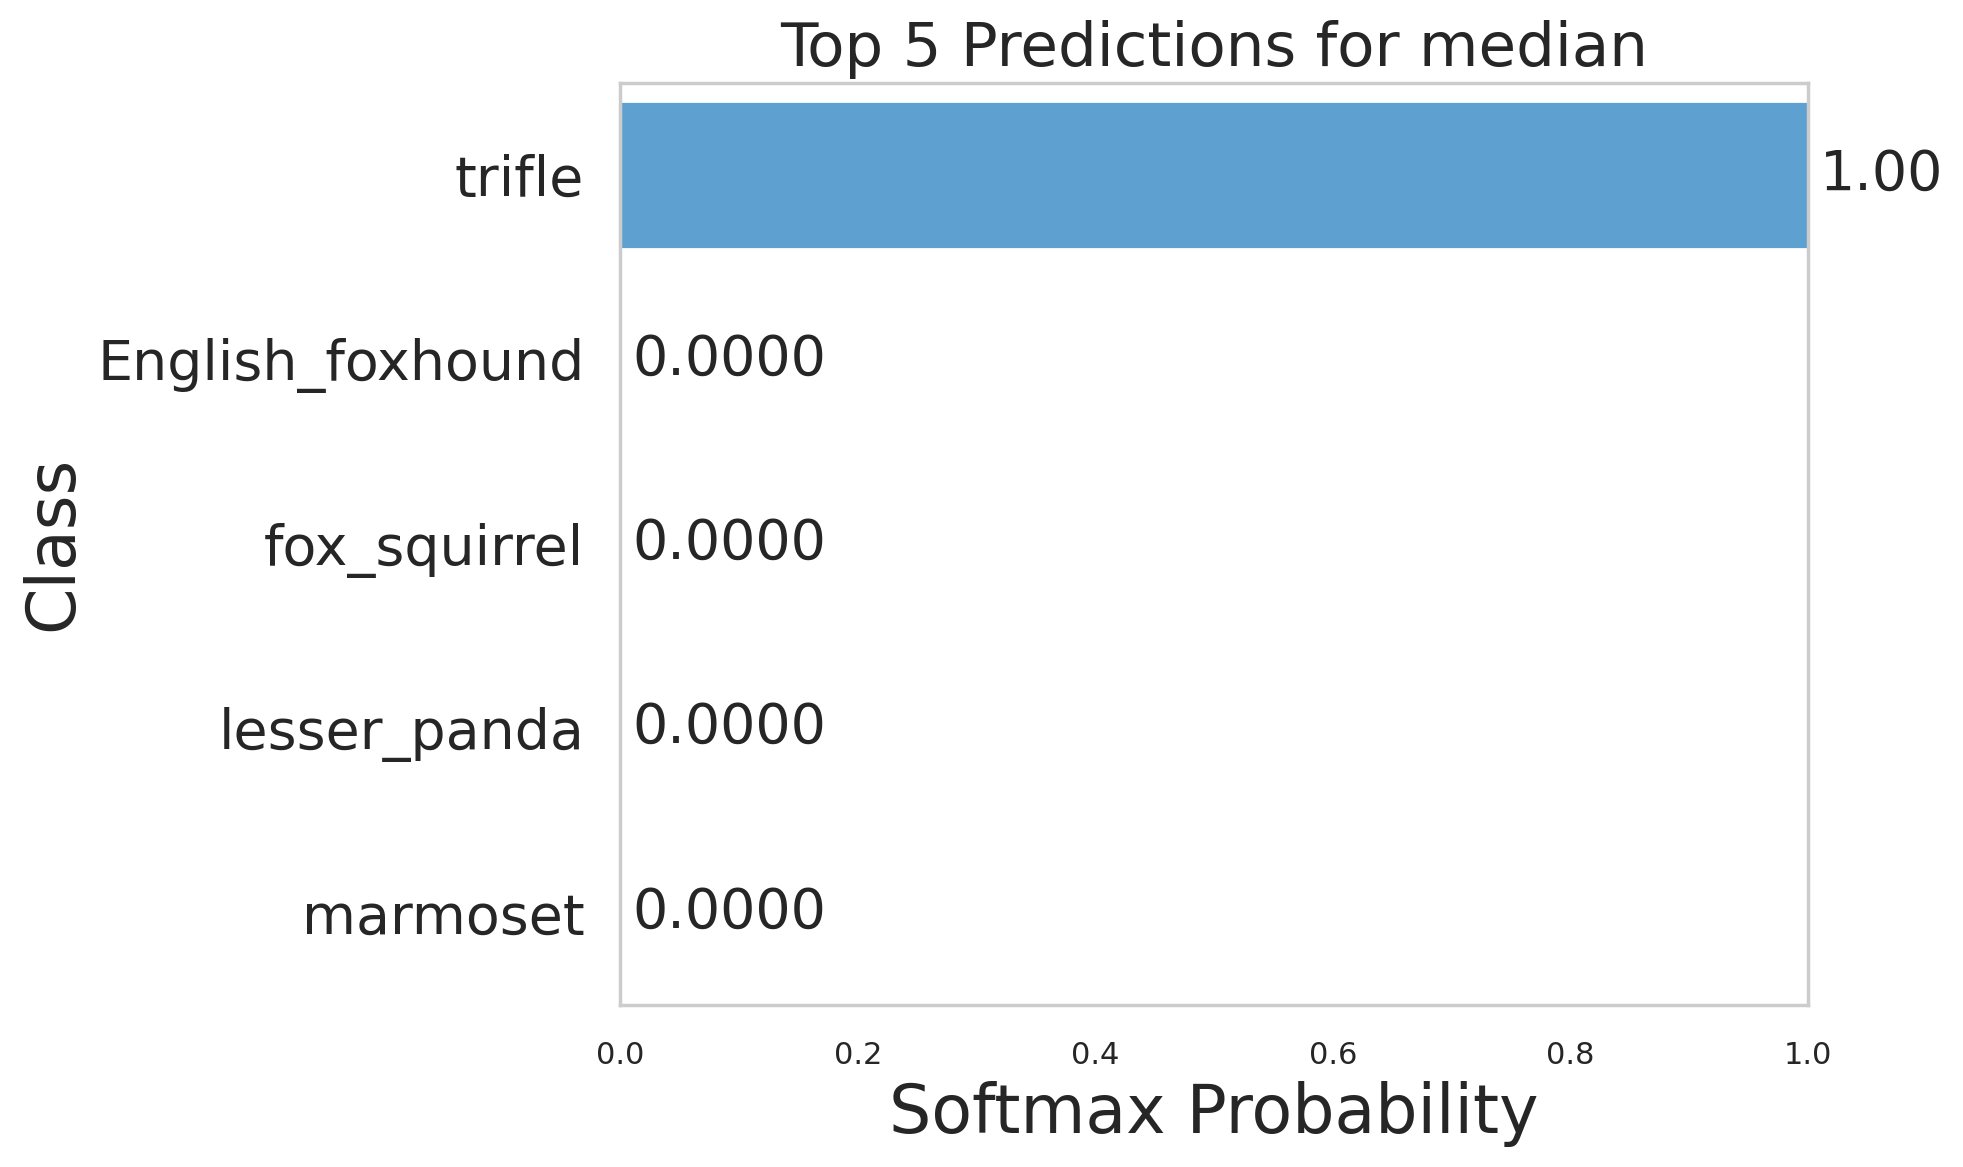

<ipython-input-37-8b670652c975>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


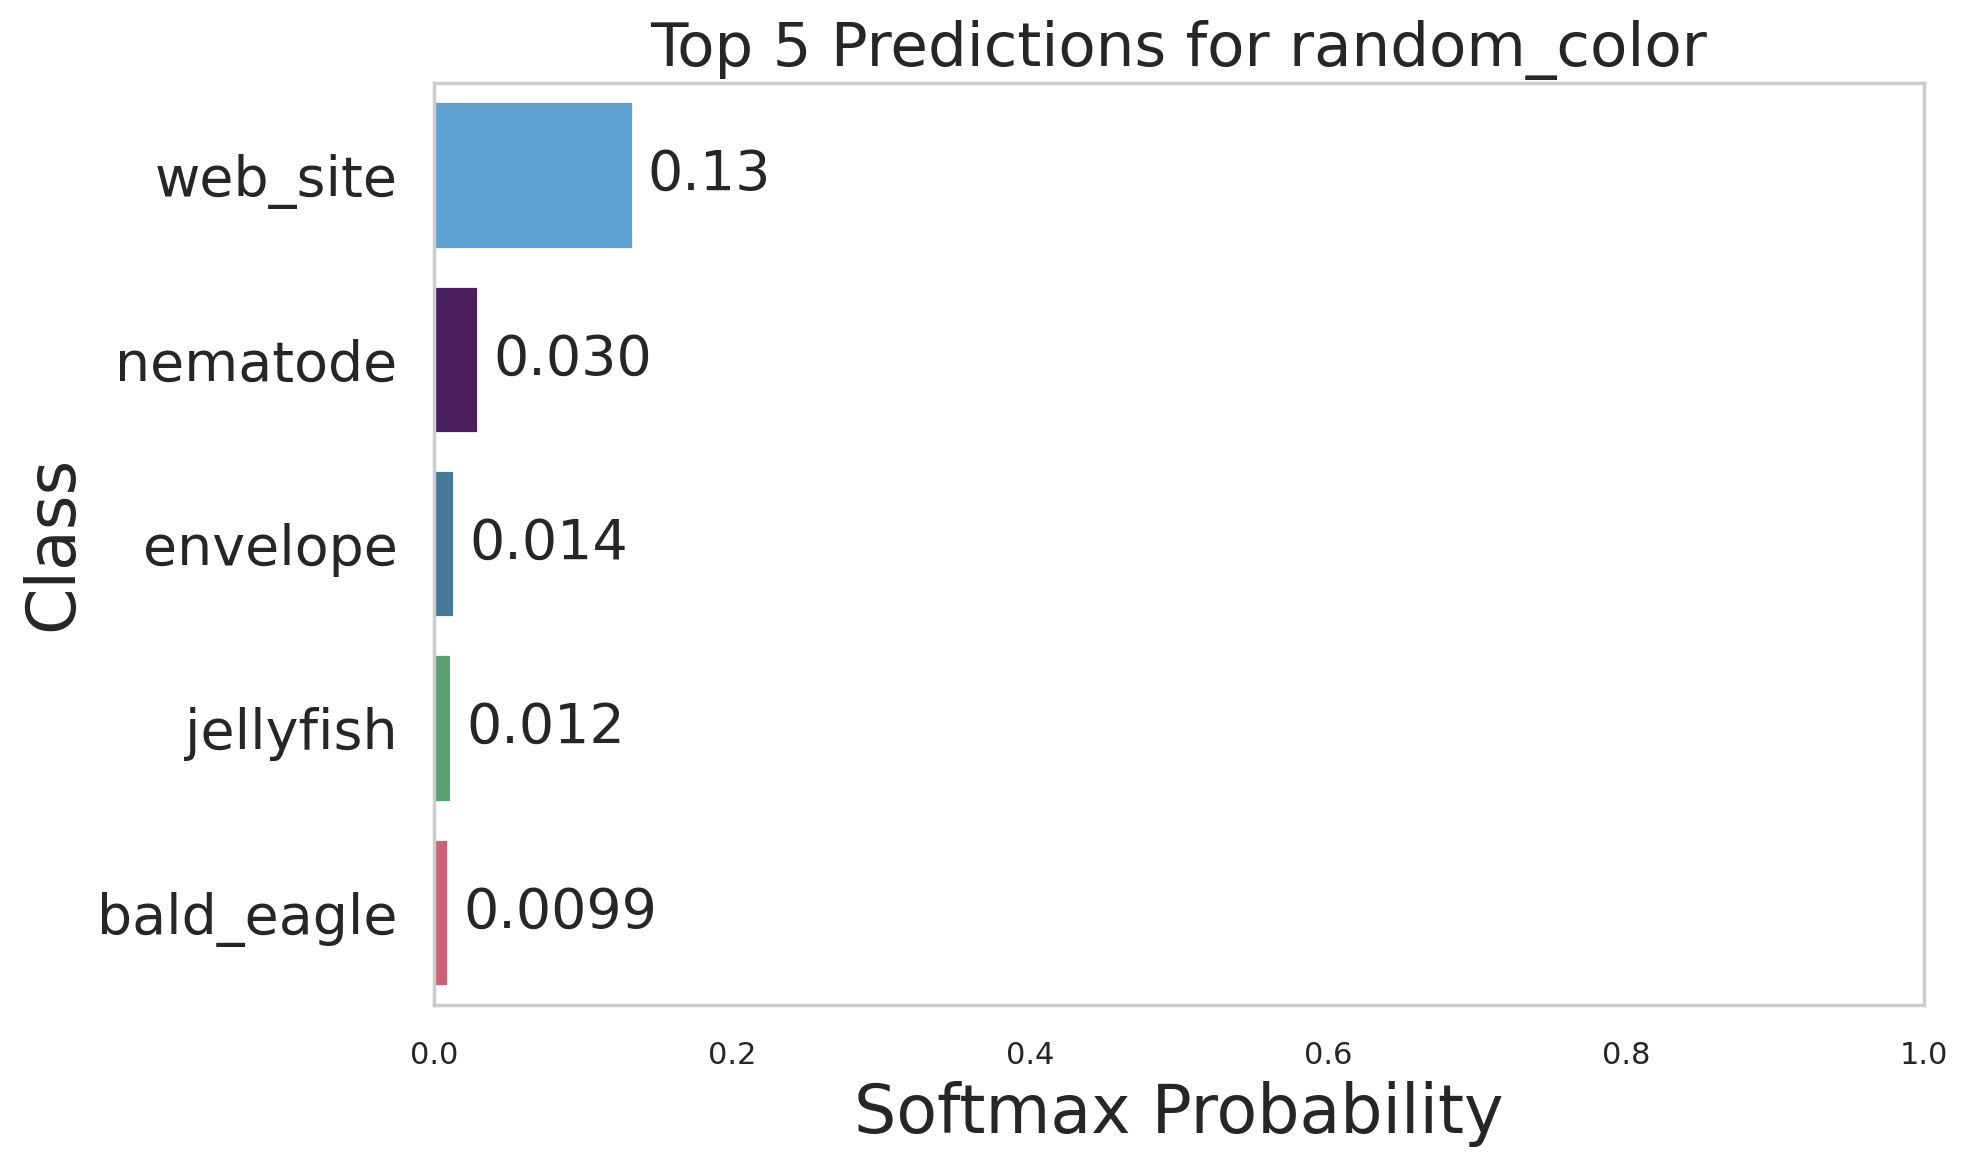

<ipython-input-37-8b670652c975>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


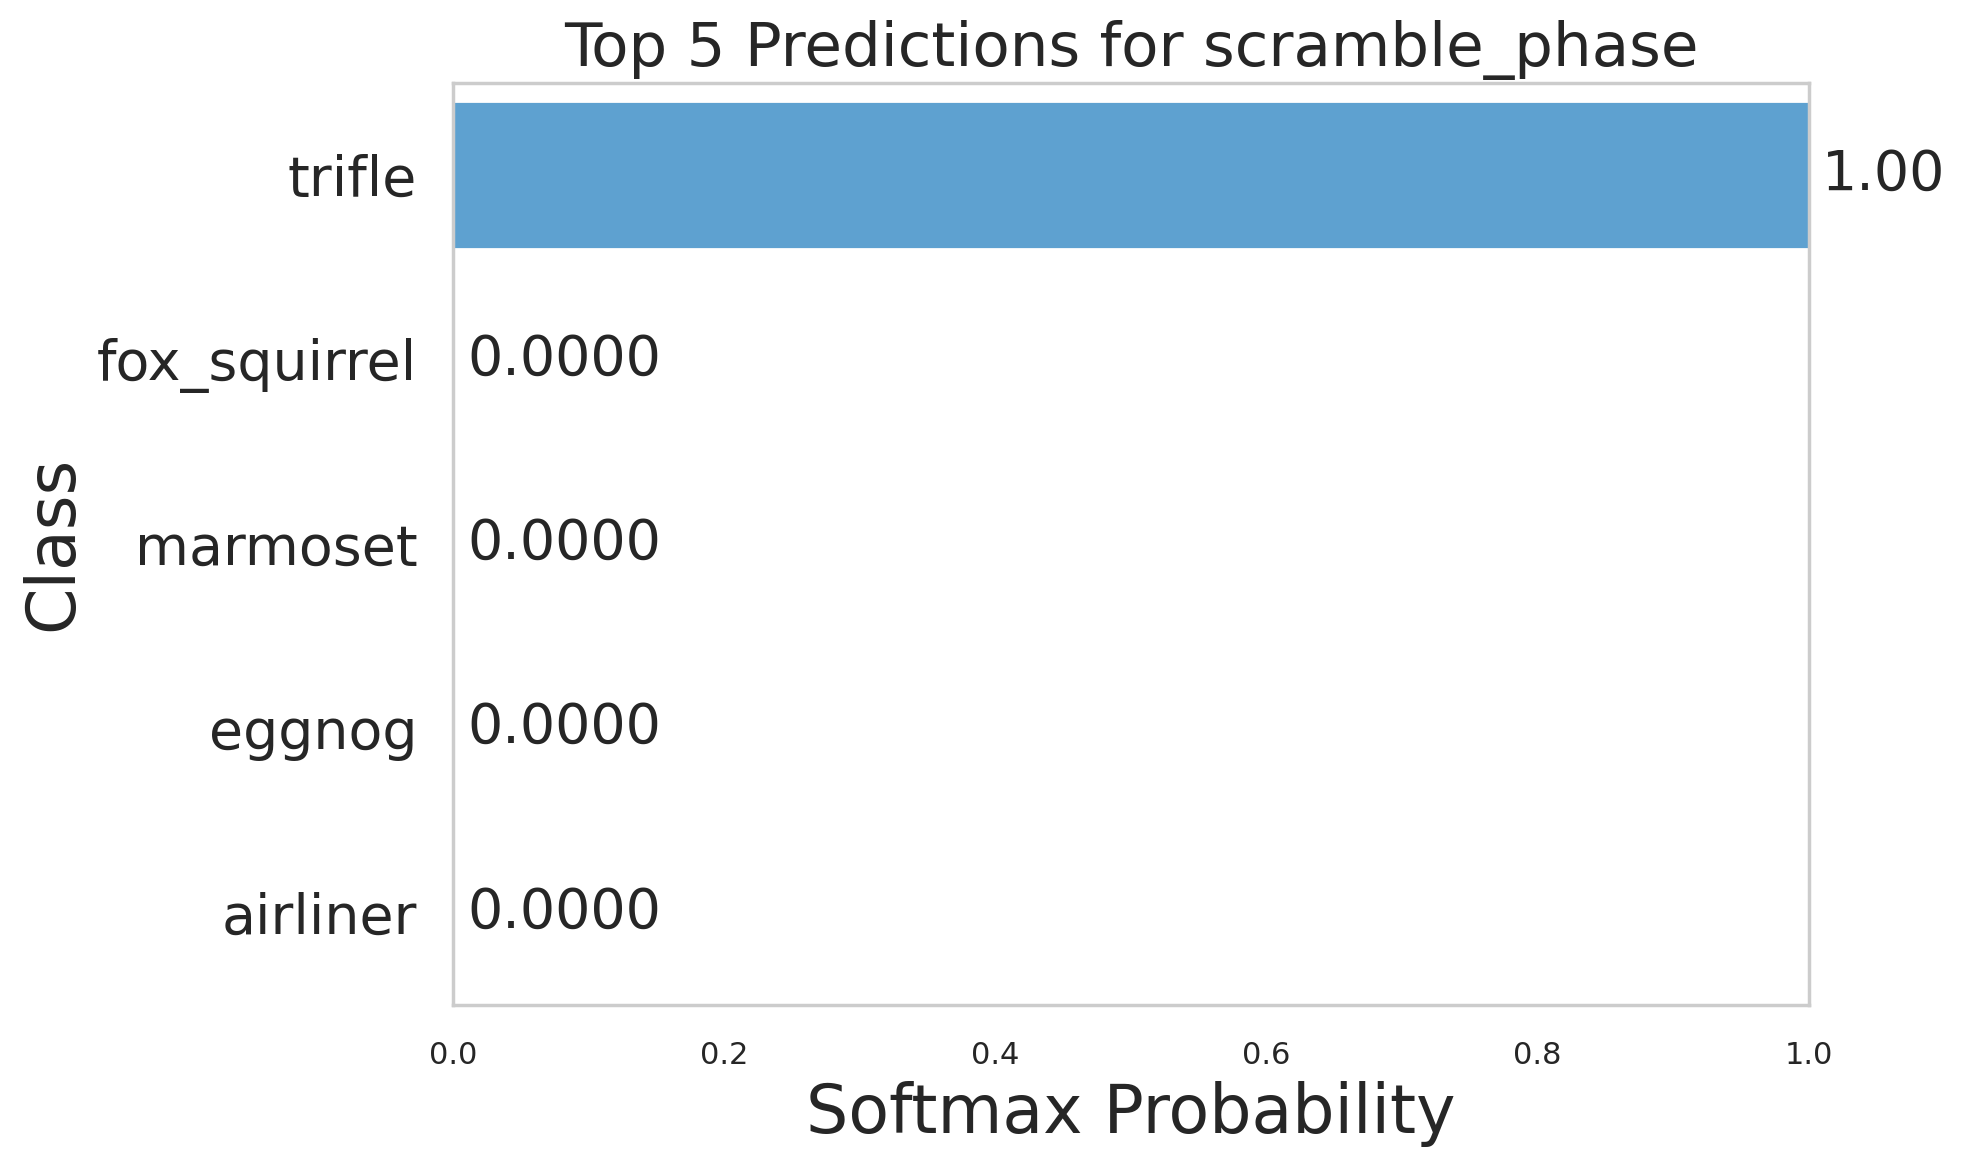

<ipython-input-37-8b670652c975>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


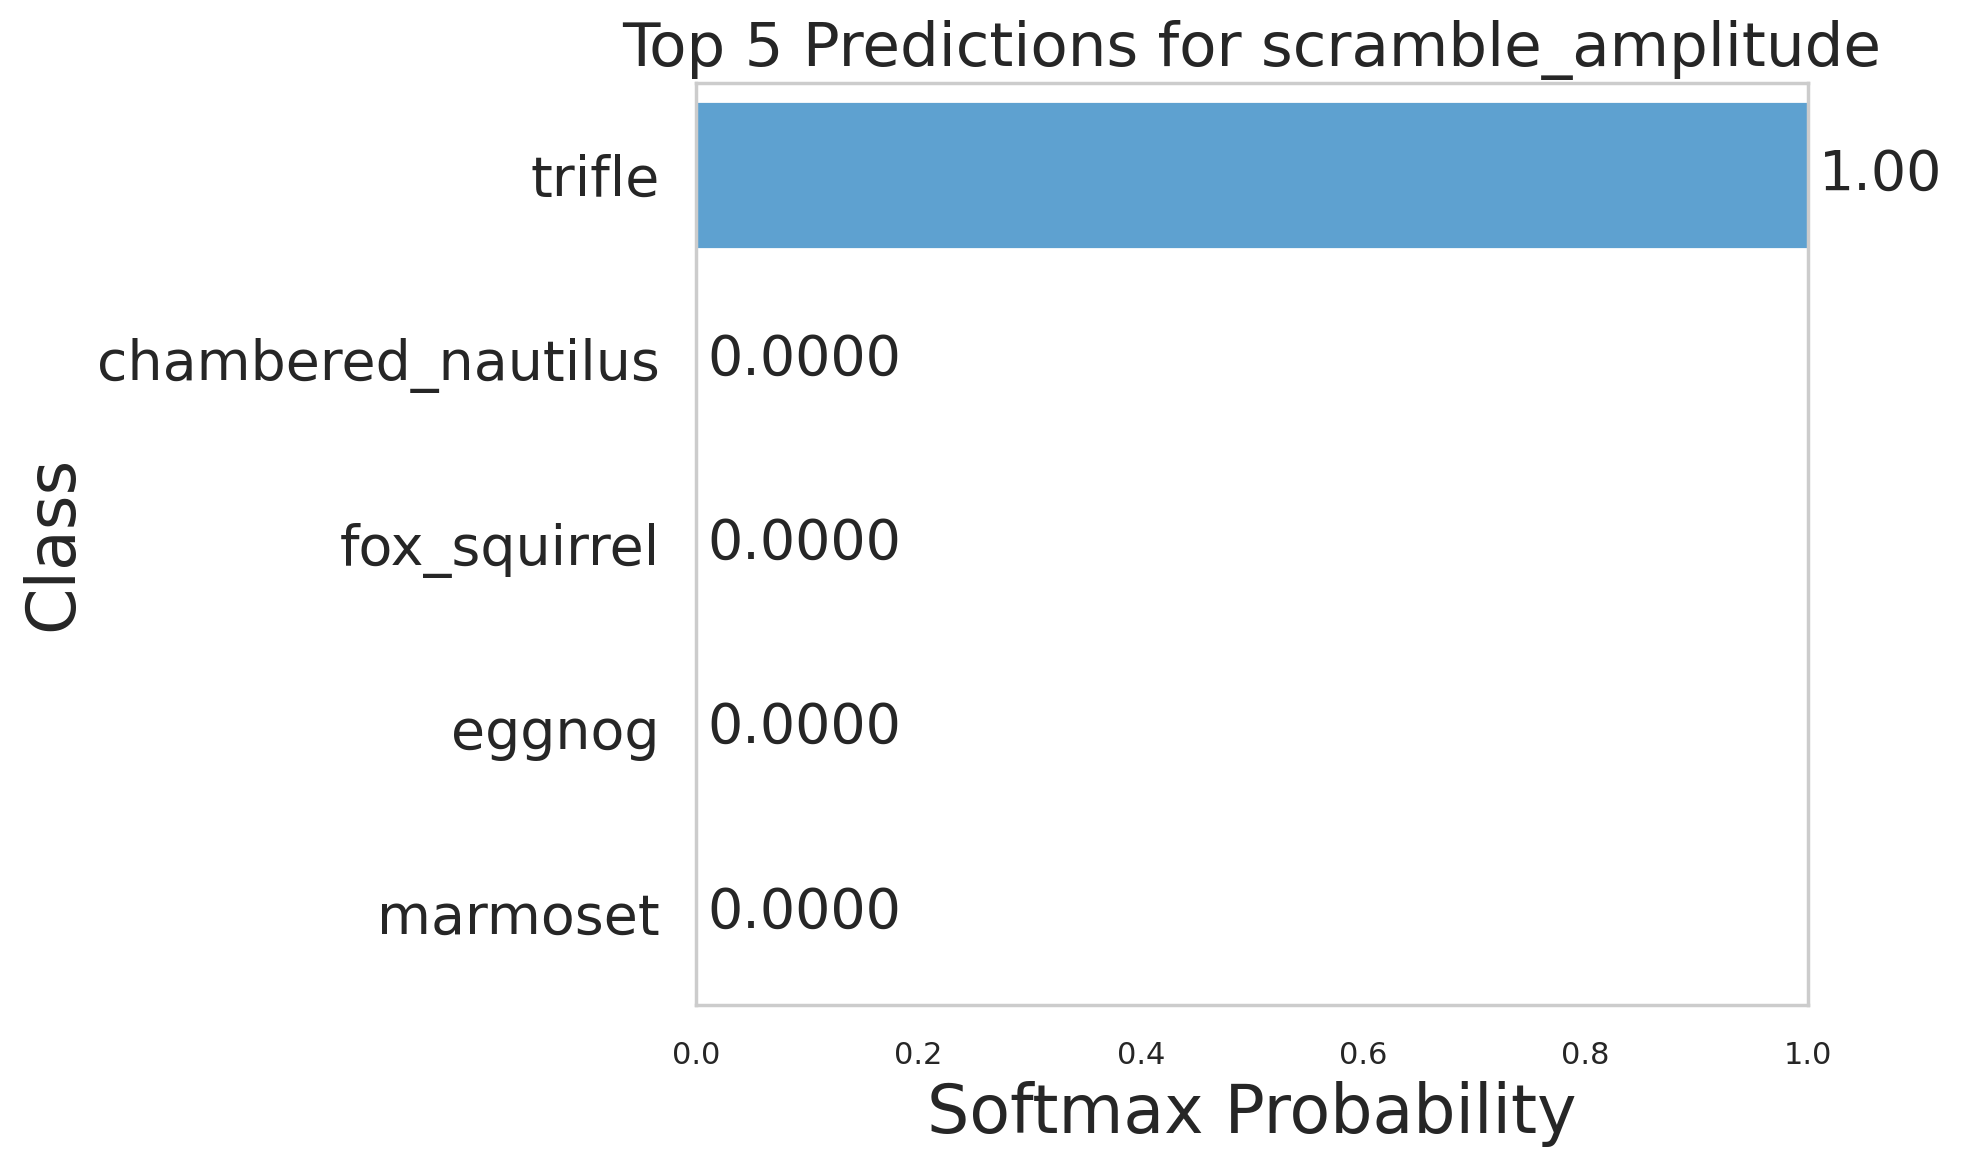

In [39]:
plot_top5_predictions(classifications_r50)

## Do the same for ViT

In [ ]:
# Now show it for the baseline fv
logits_fv = model_vit(tf.expand_dims(baseline_fv_vit, axis=0))
top_k_classes = tf.argsort(logits_fv, axis=-1, direction="DESCENDING")[0,:5]
top_k_softmax_values = tf.gather(tf.nn.softmax(logits_fv[0]), top_k_classes)
decoded_logits = decode_predictions(logits_fv.numpy(), top=5)
classifications_vit[("Ours", "classes")] = list(map(lambda z: z[1], decoded_logits[0]))
classifications_vit[("Ours", "softmax")] = top_k_softmax_values

<ipython-input-44-c2e1e337f8d3>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


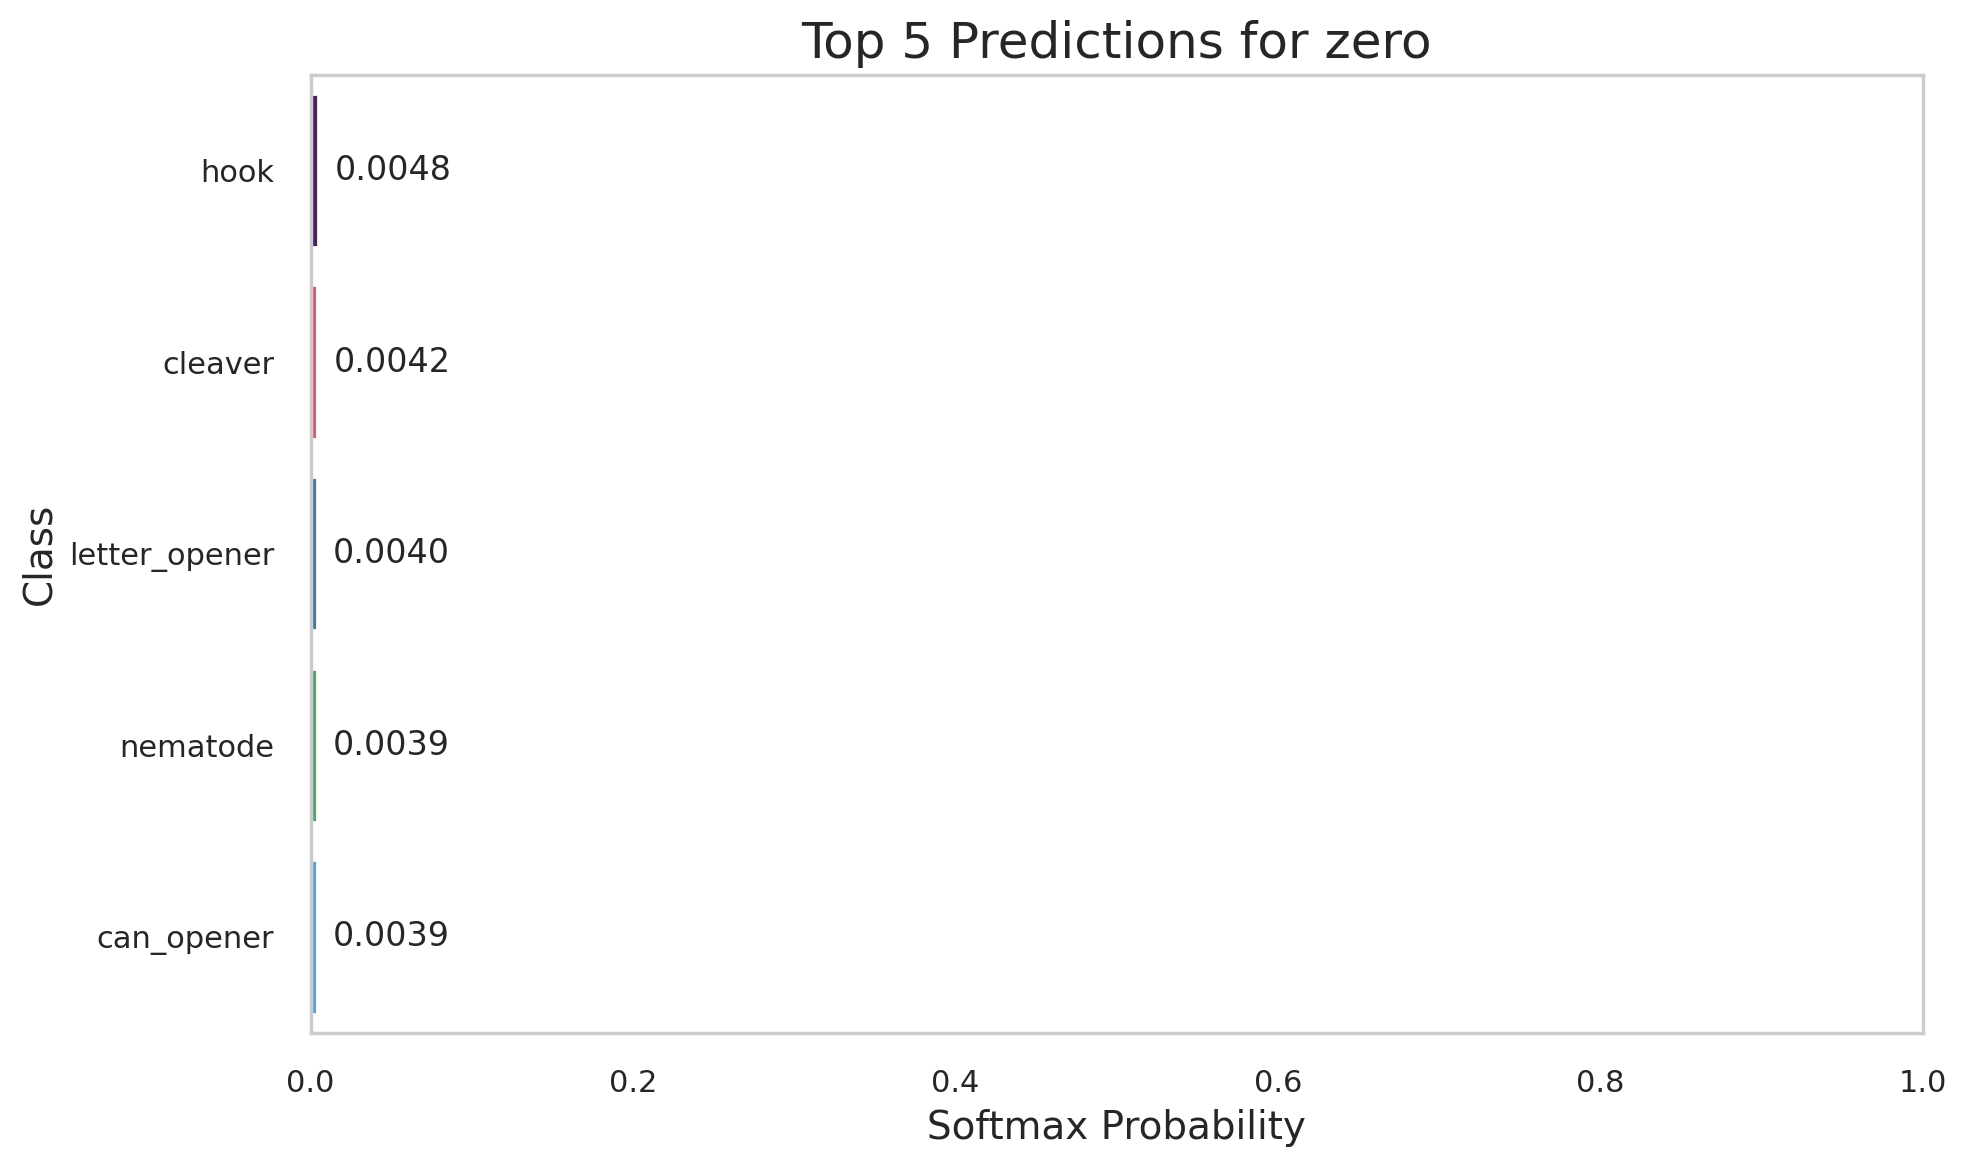

<ipython-input-44-c2e1e337f8d3>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


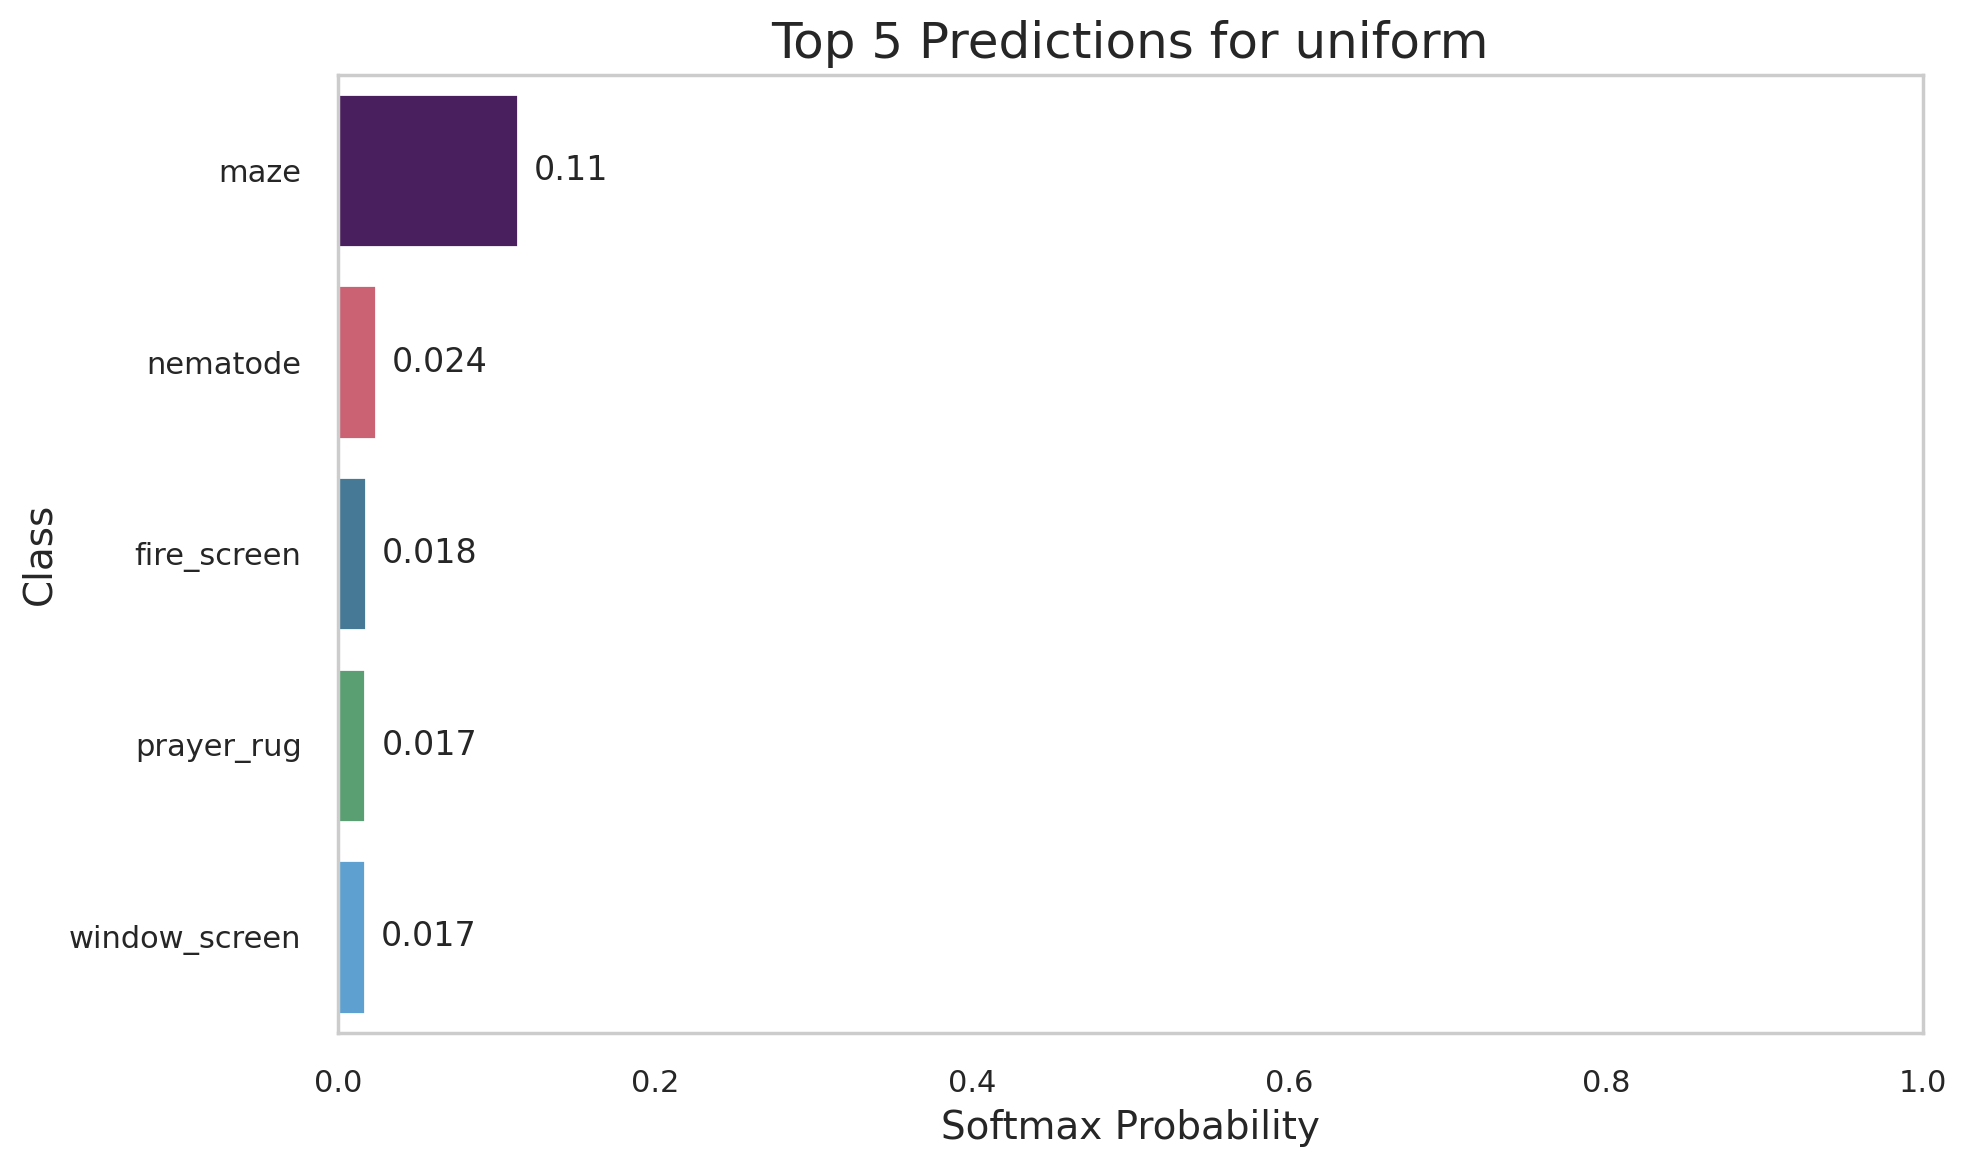

<ipython-input-44-c2e1e337f8d3>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


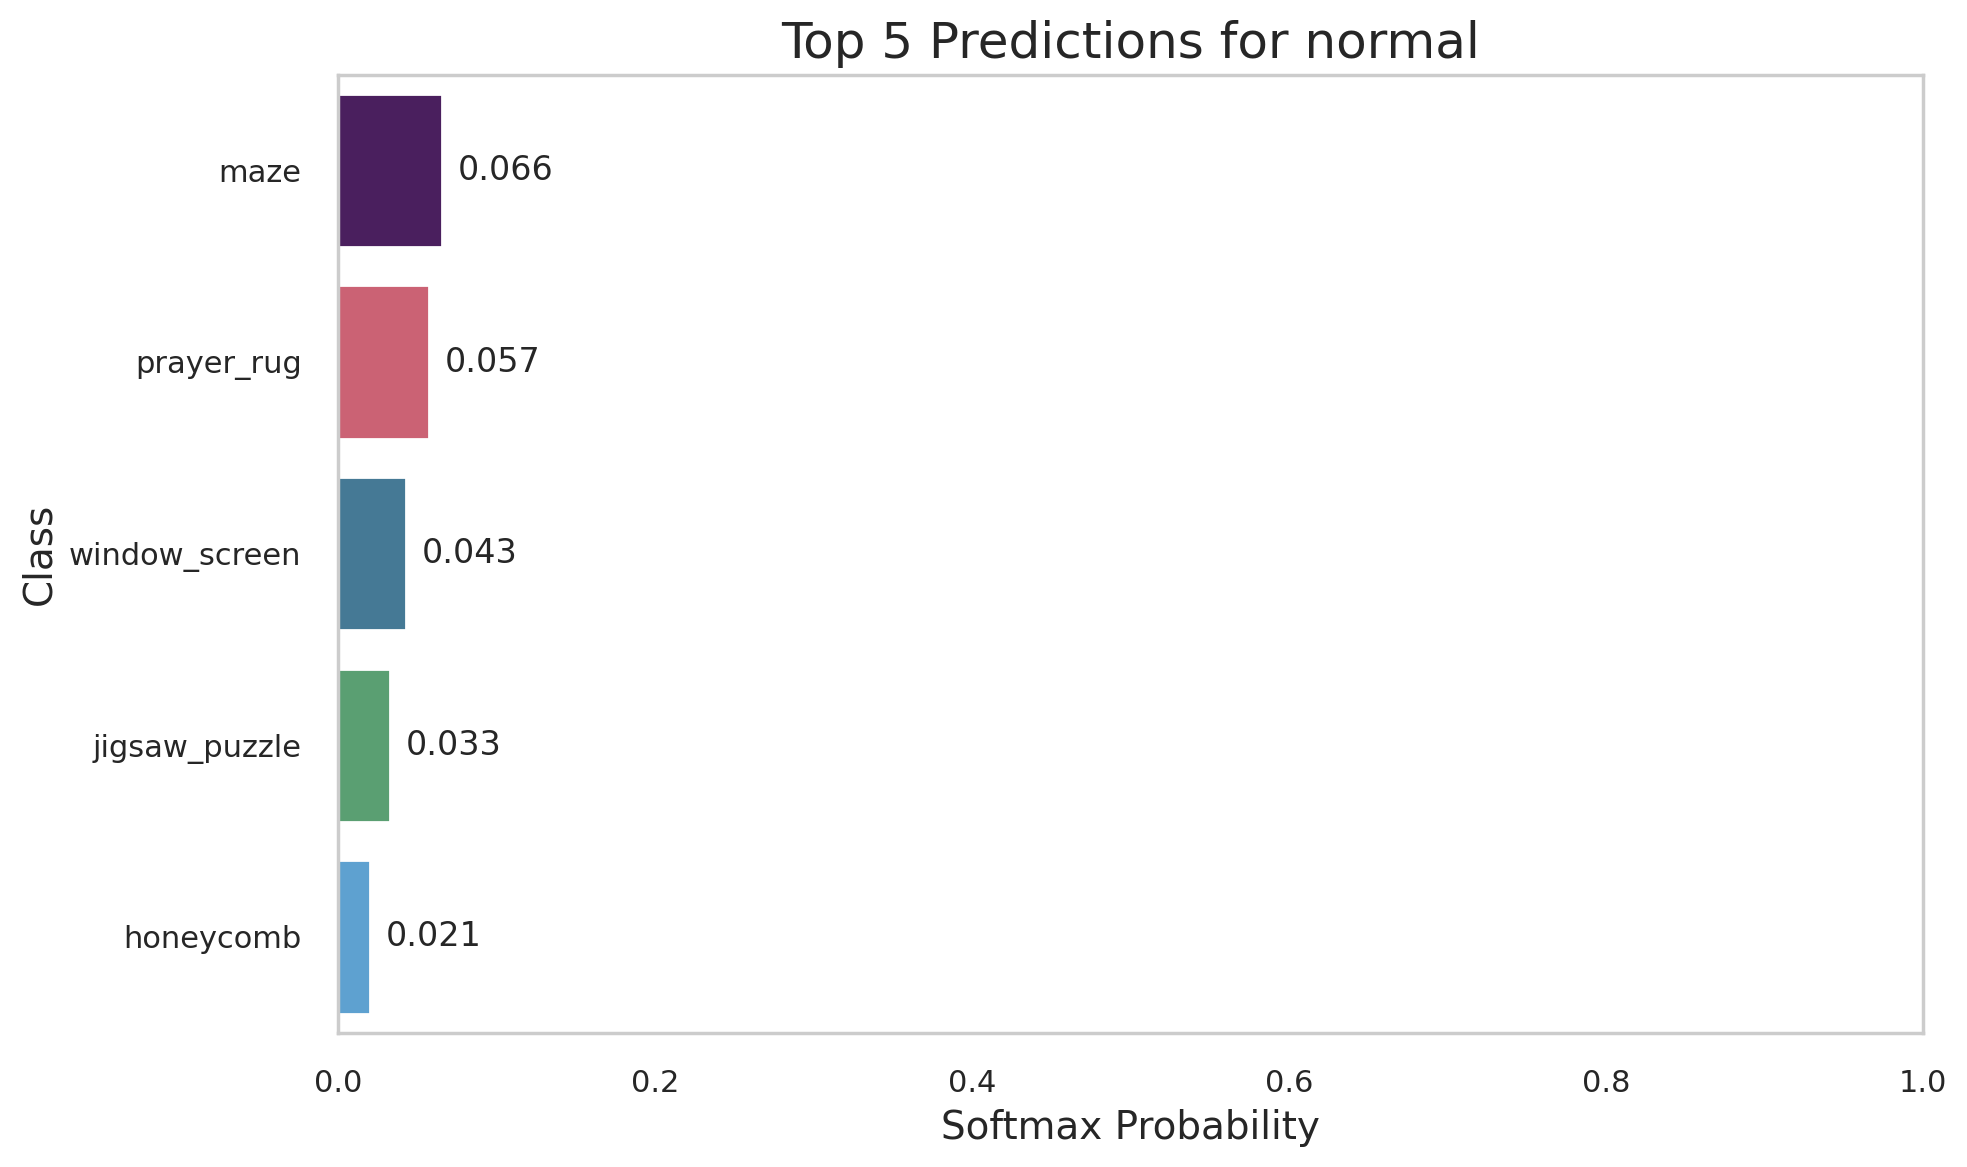

<ipython-input-44-c2e1e337f8d3>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


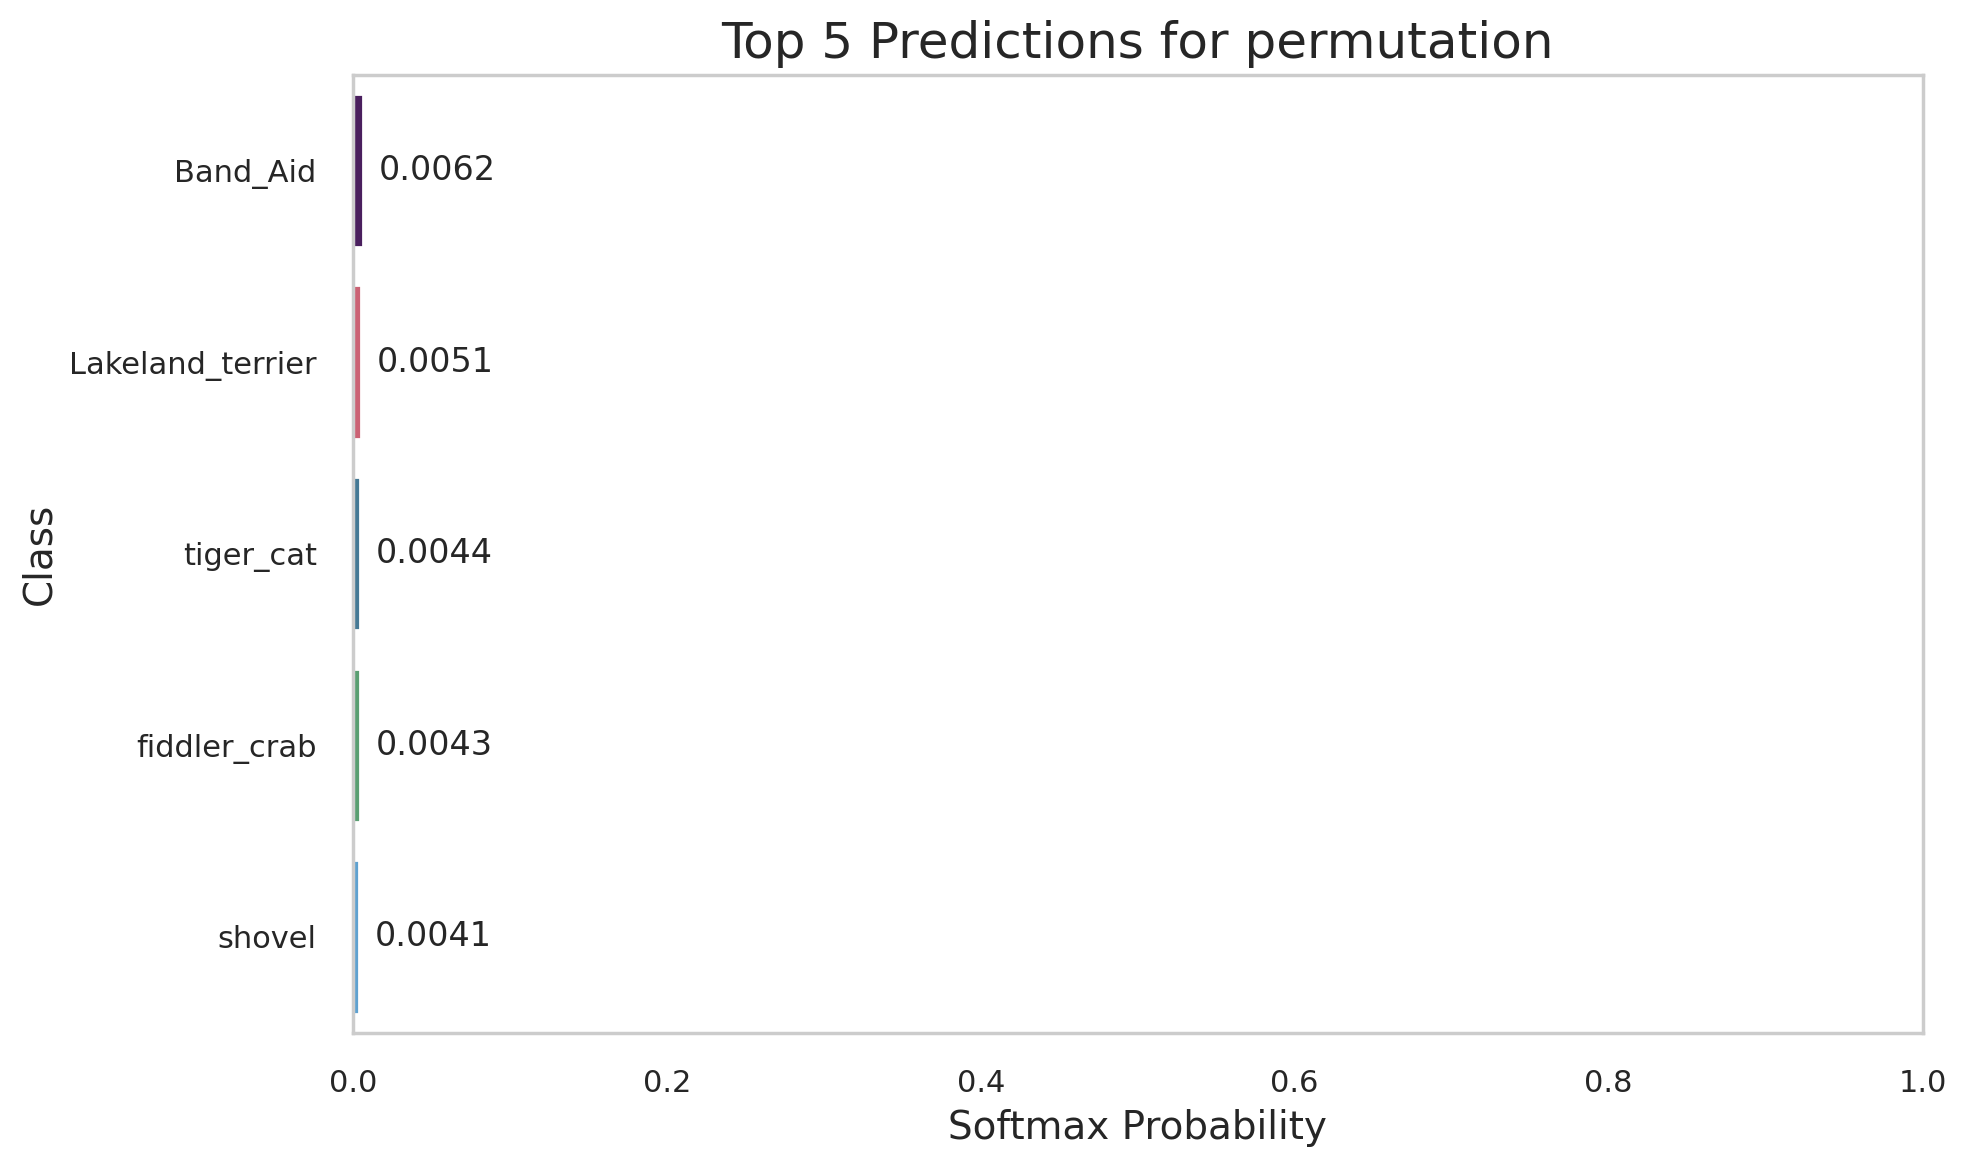

<ipython-input-44-c2e1e337f8d3>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


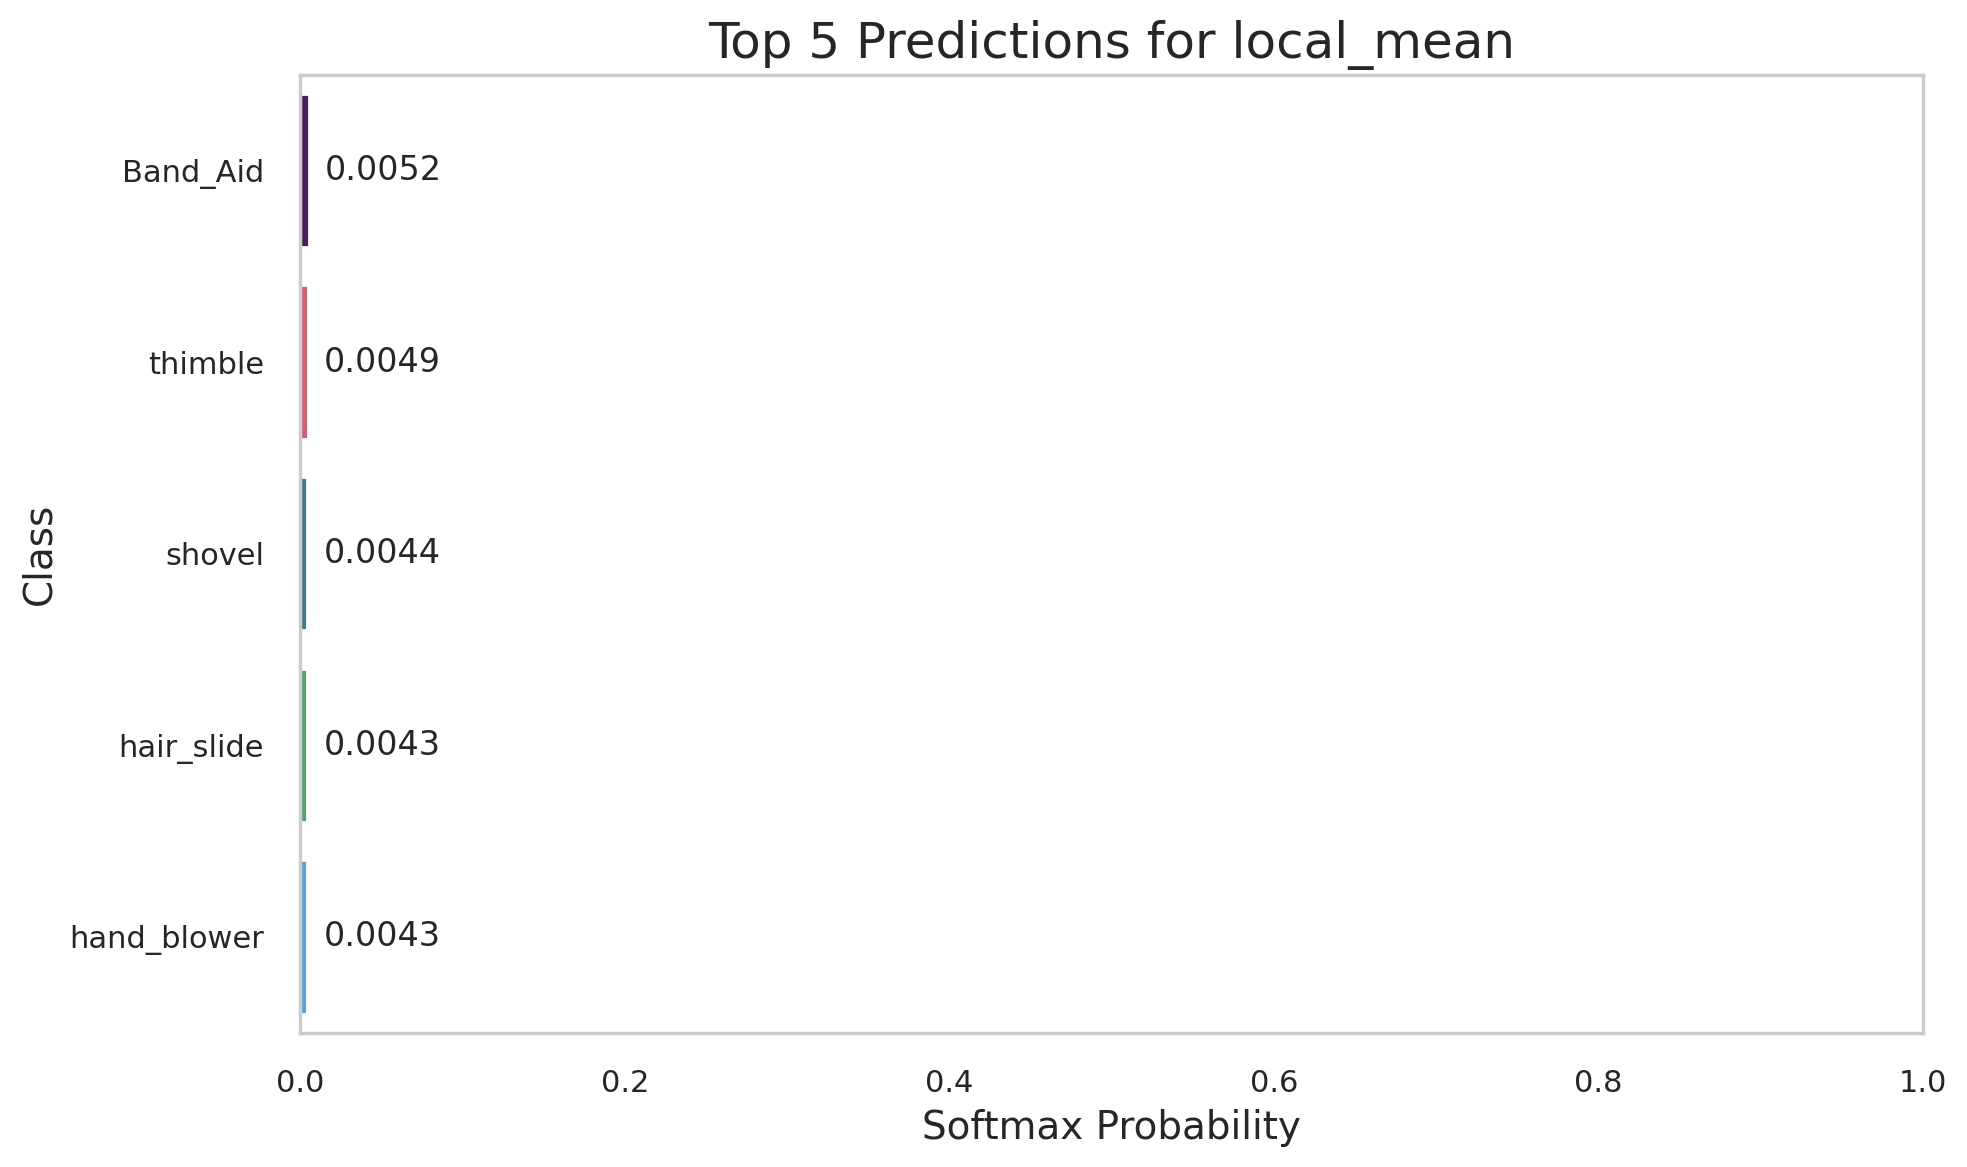

<ipython-input-44-c2e1e337f8d3>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


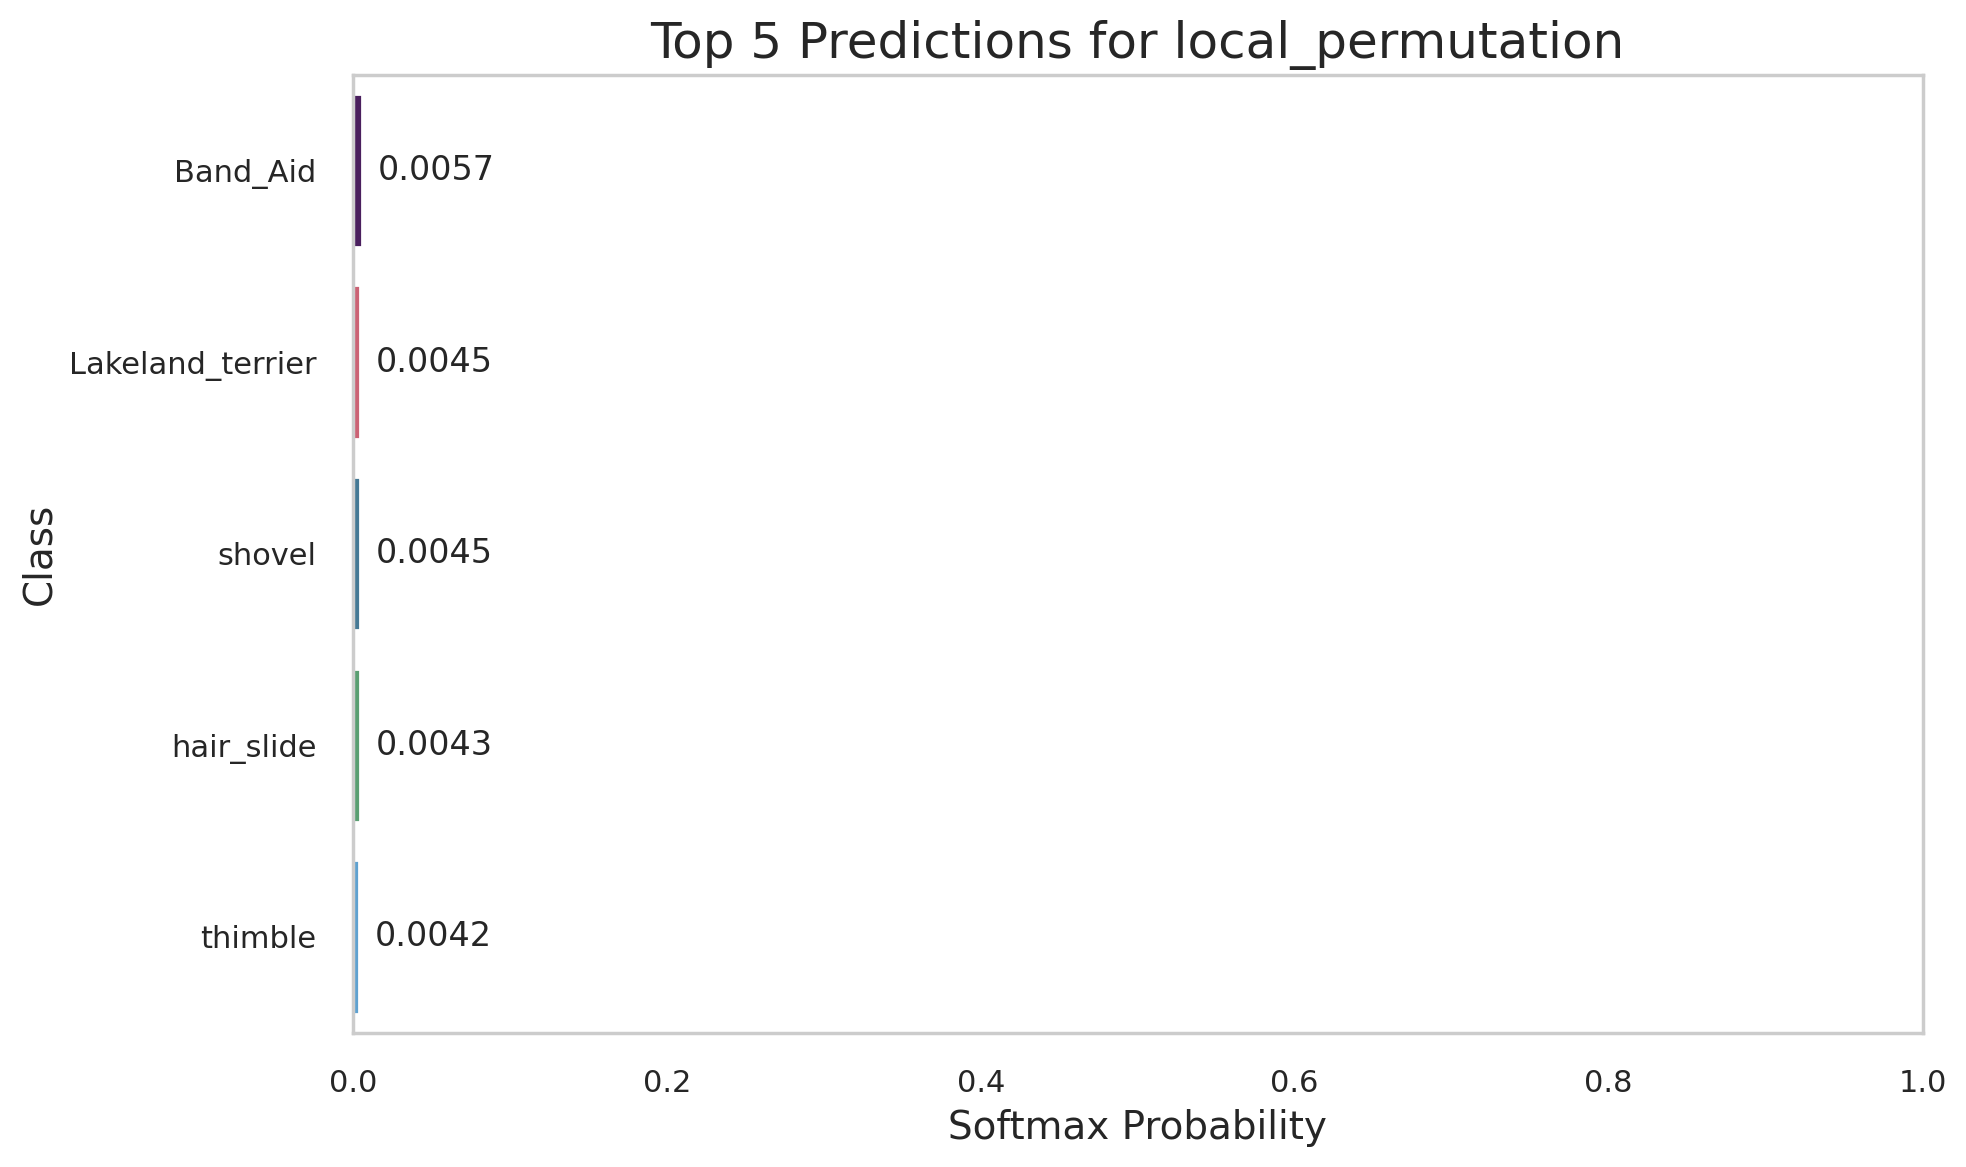

<ipython-input-44-c2e1e337f8d3>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


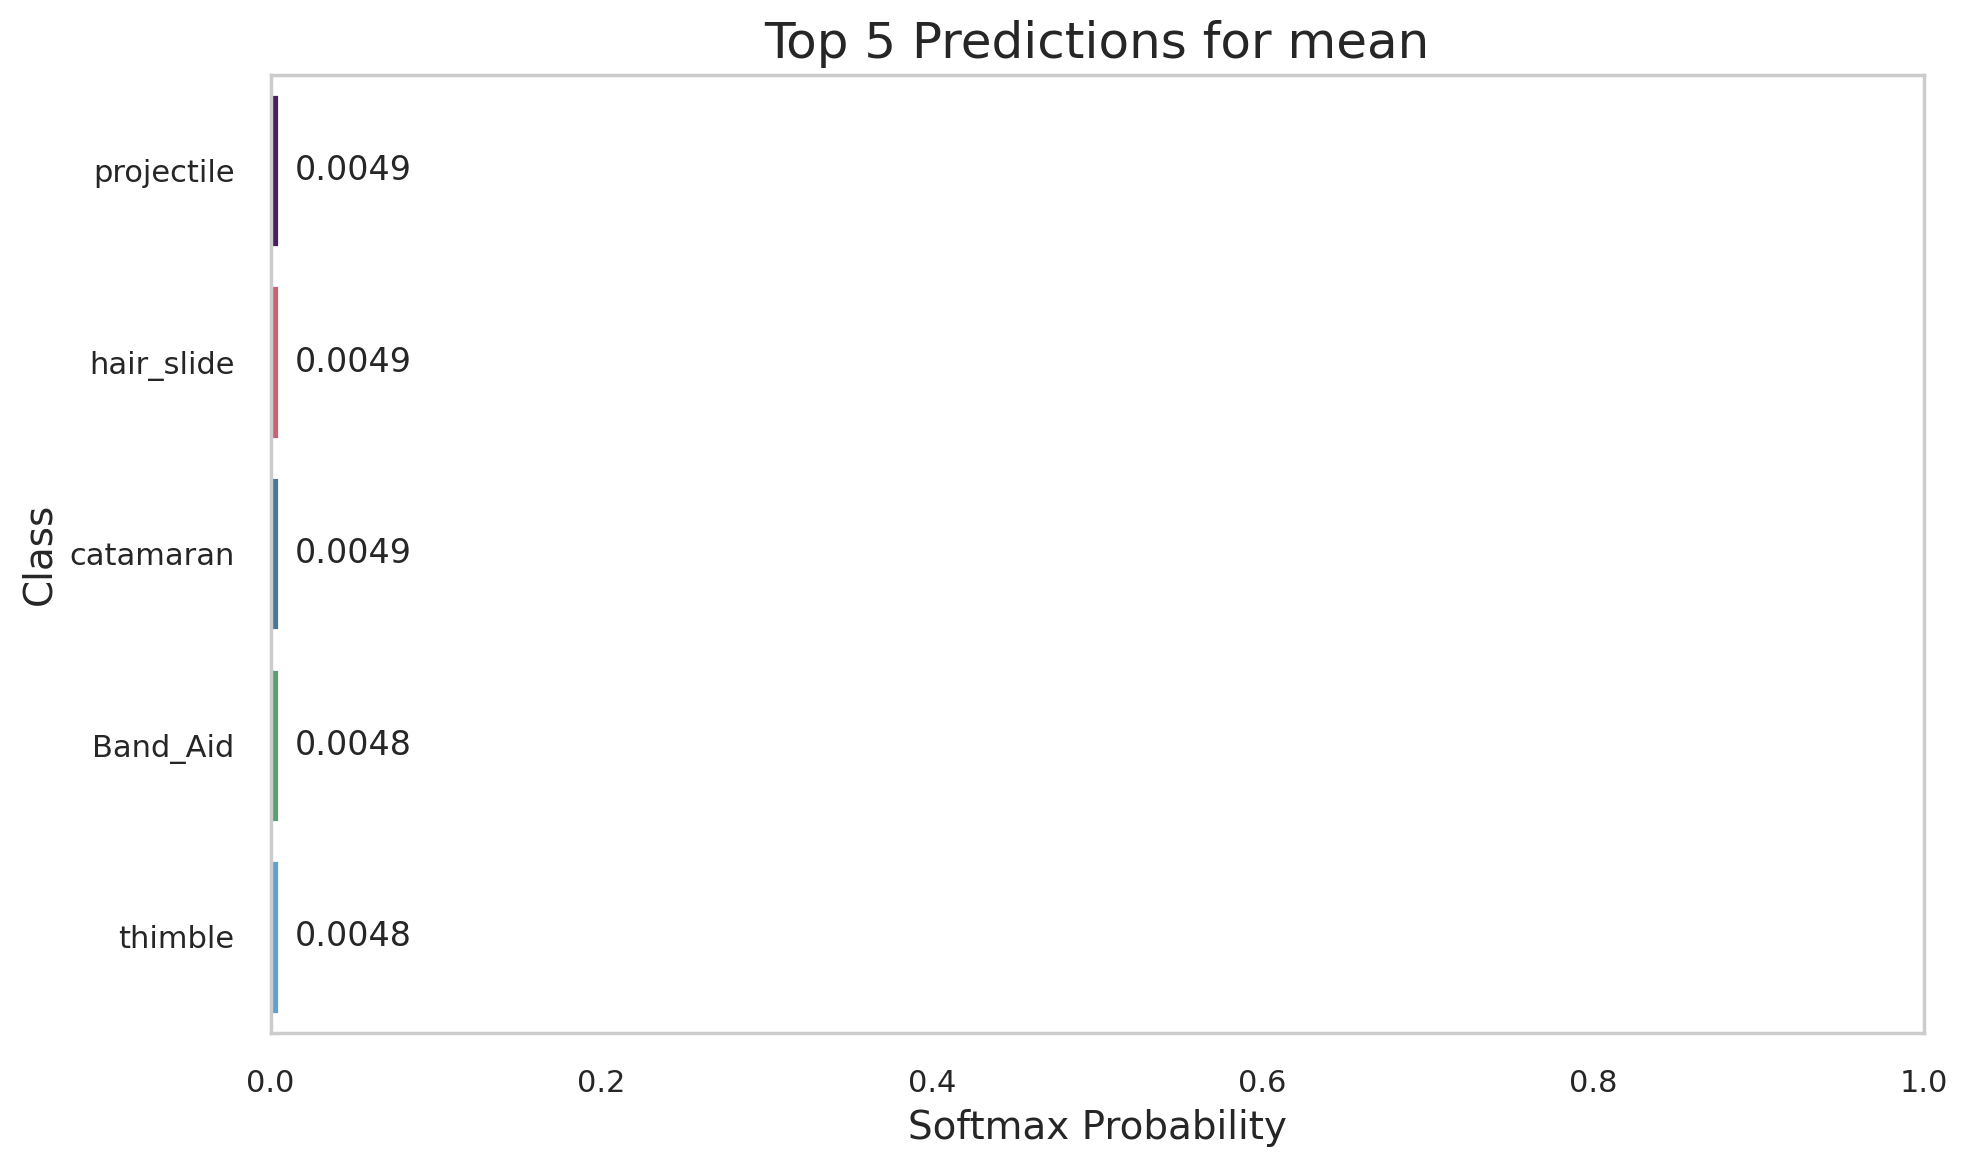

<ipython-input-44-c2e1e337f8d3>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


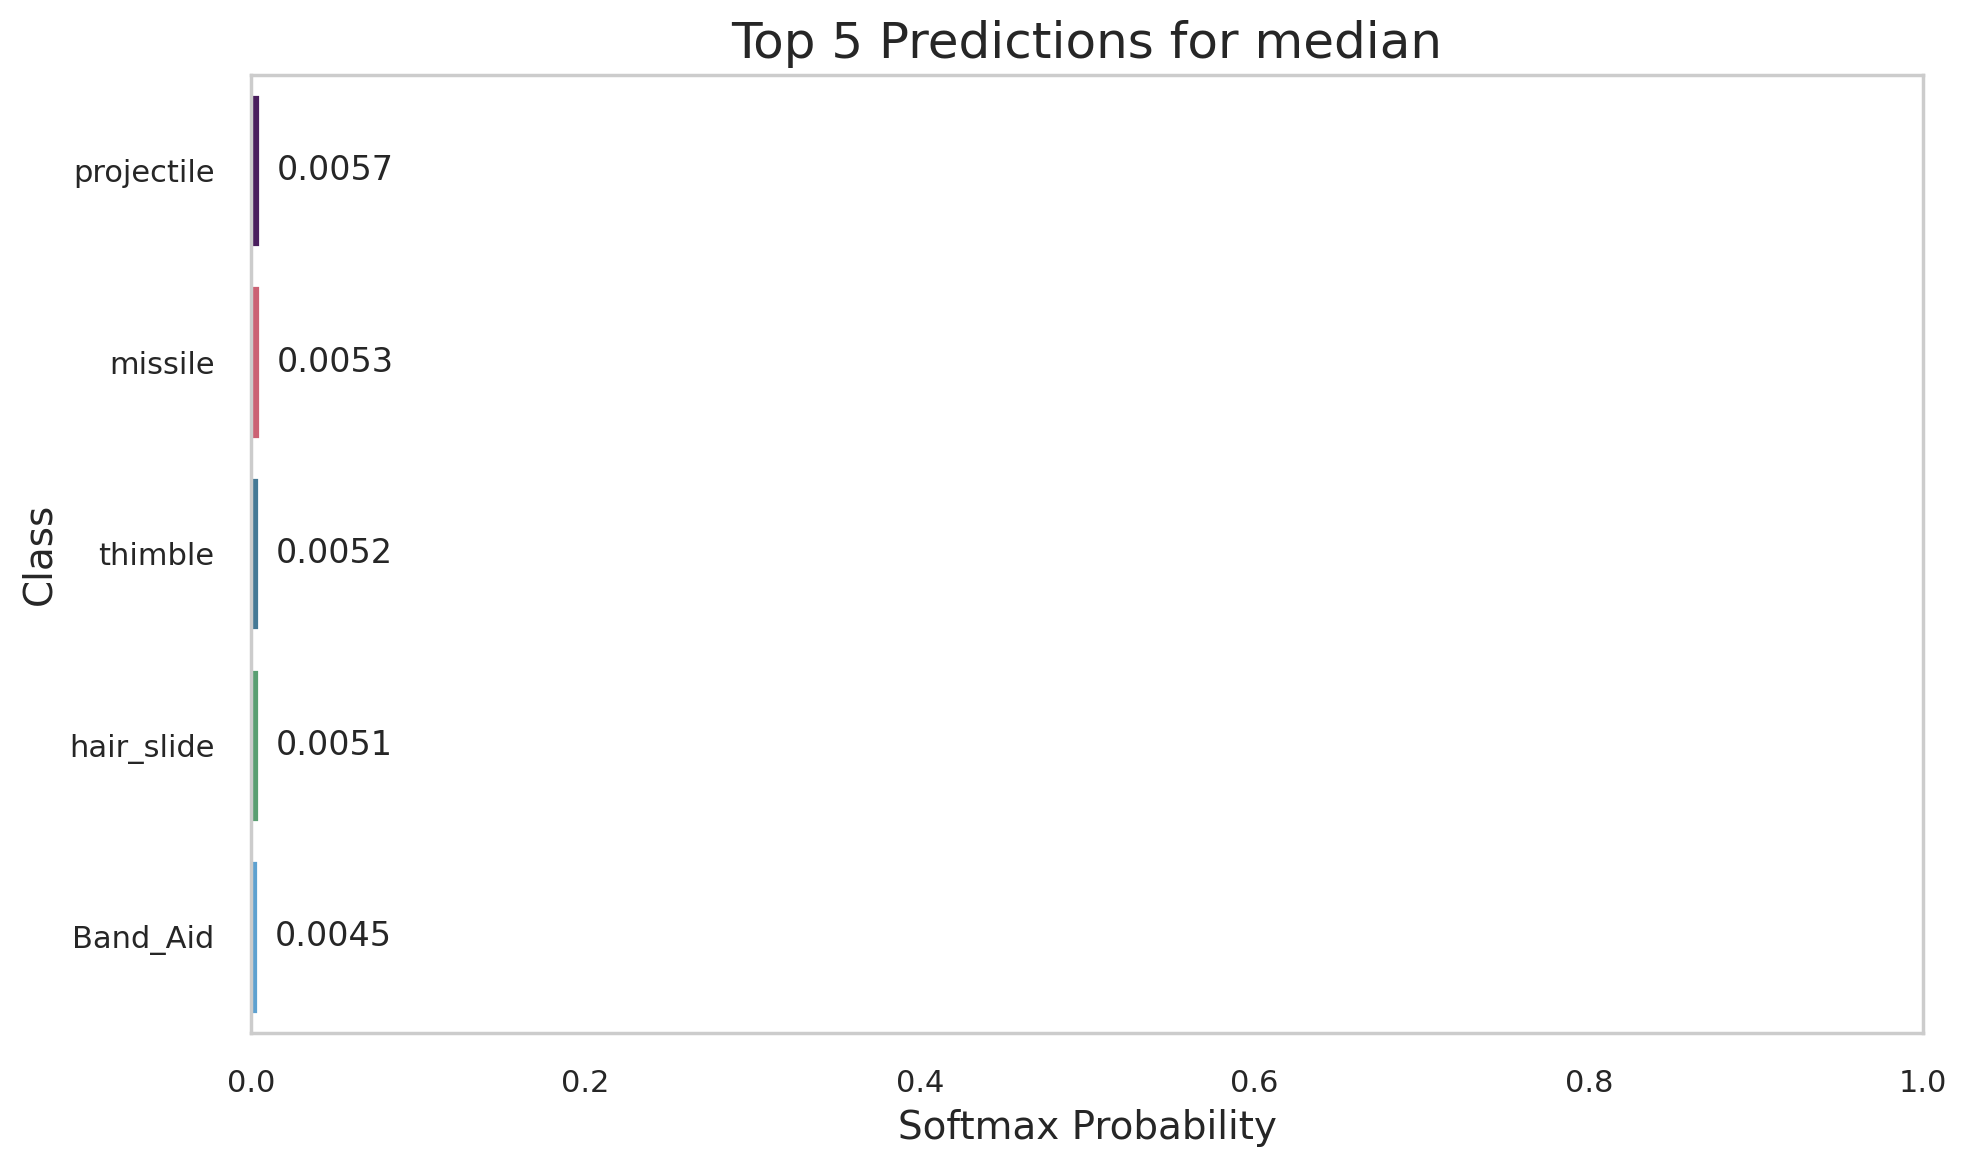

<ipython-input-44-c2e1e337f8d3>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


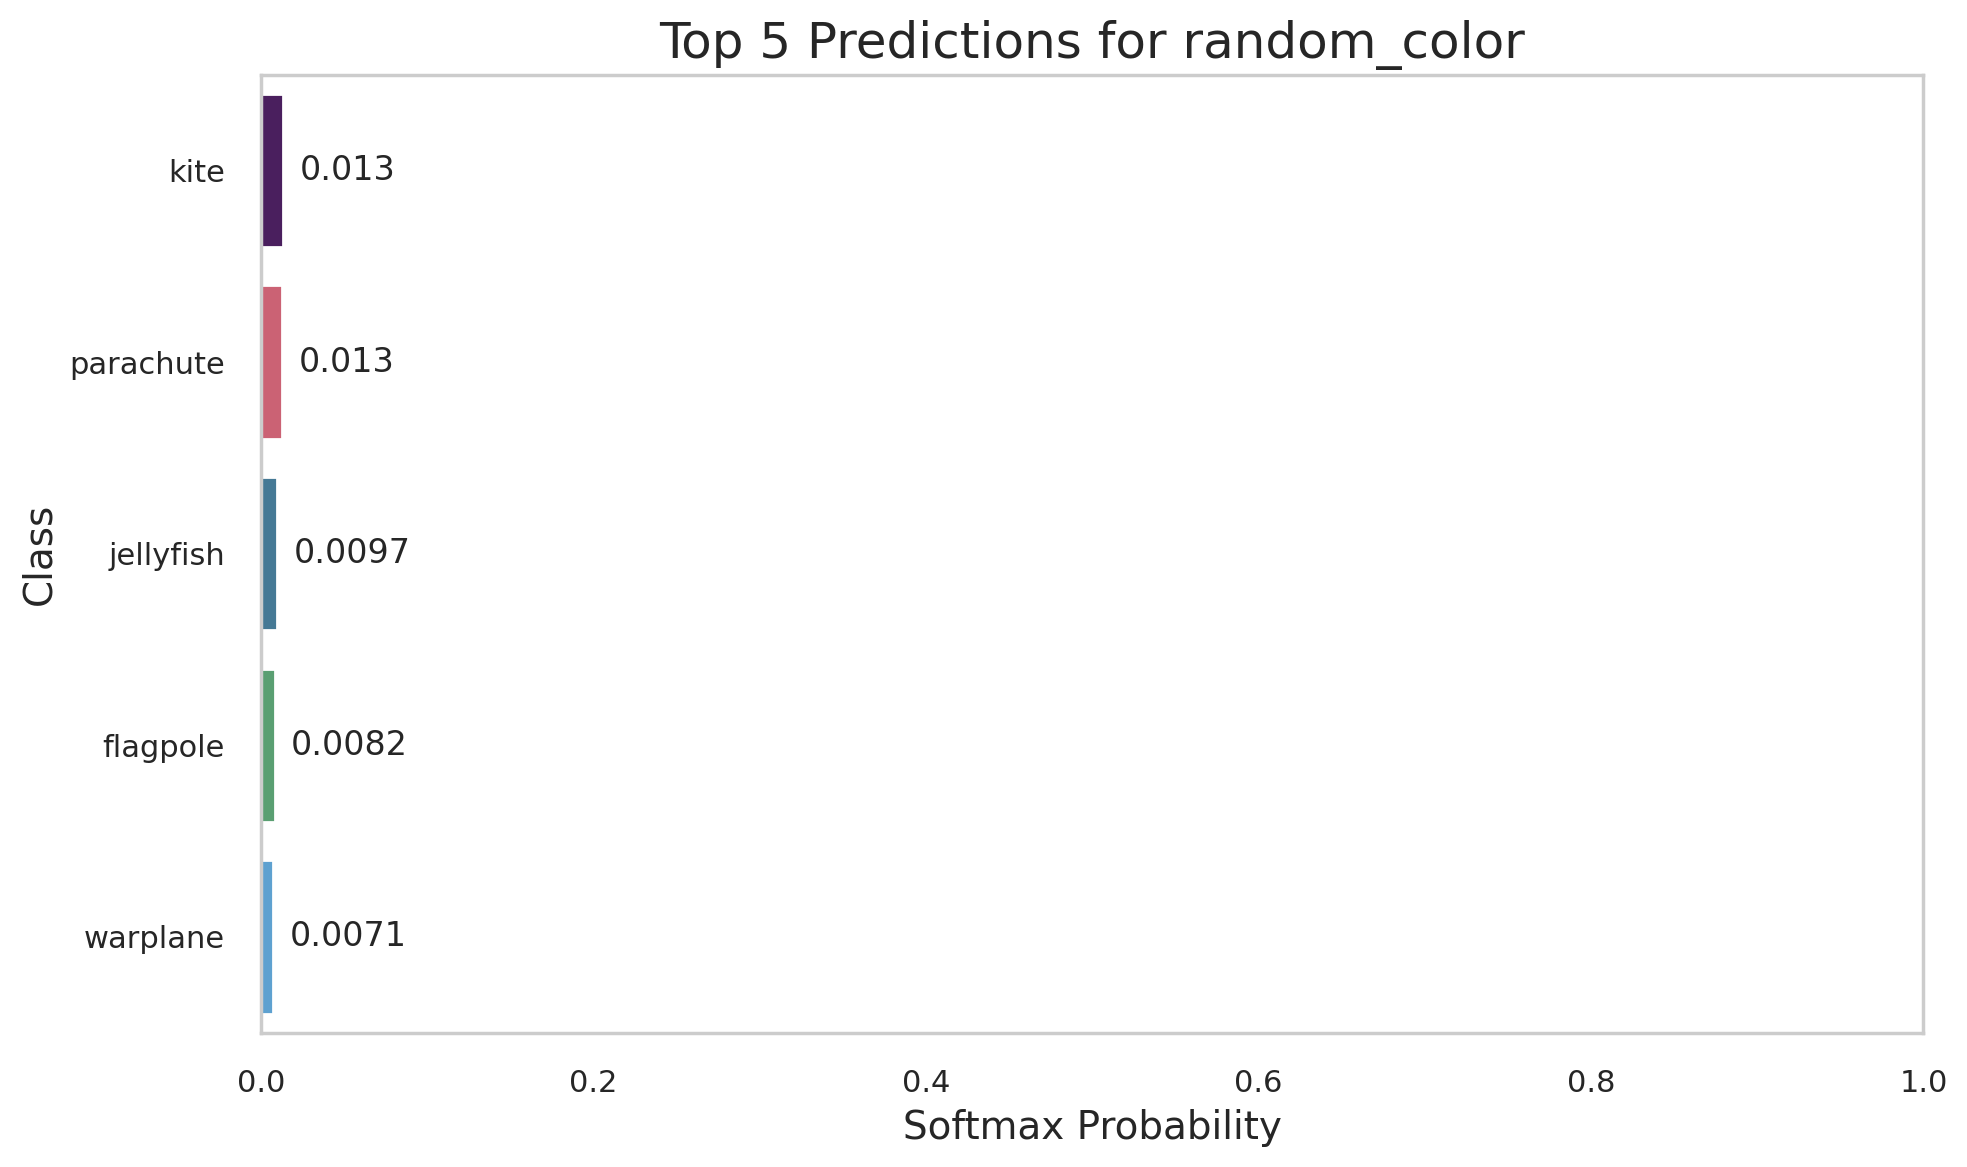

<ipython-input-44-c2e1e337f8d3>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


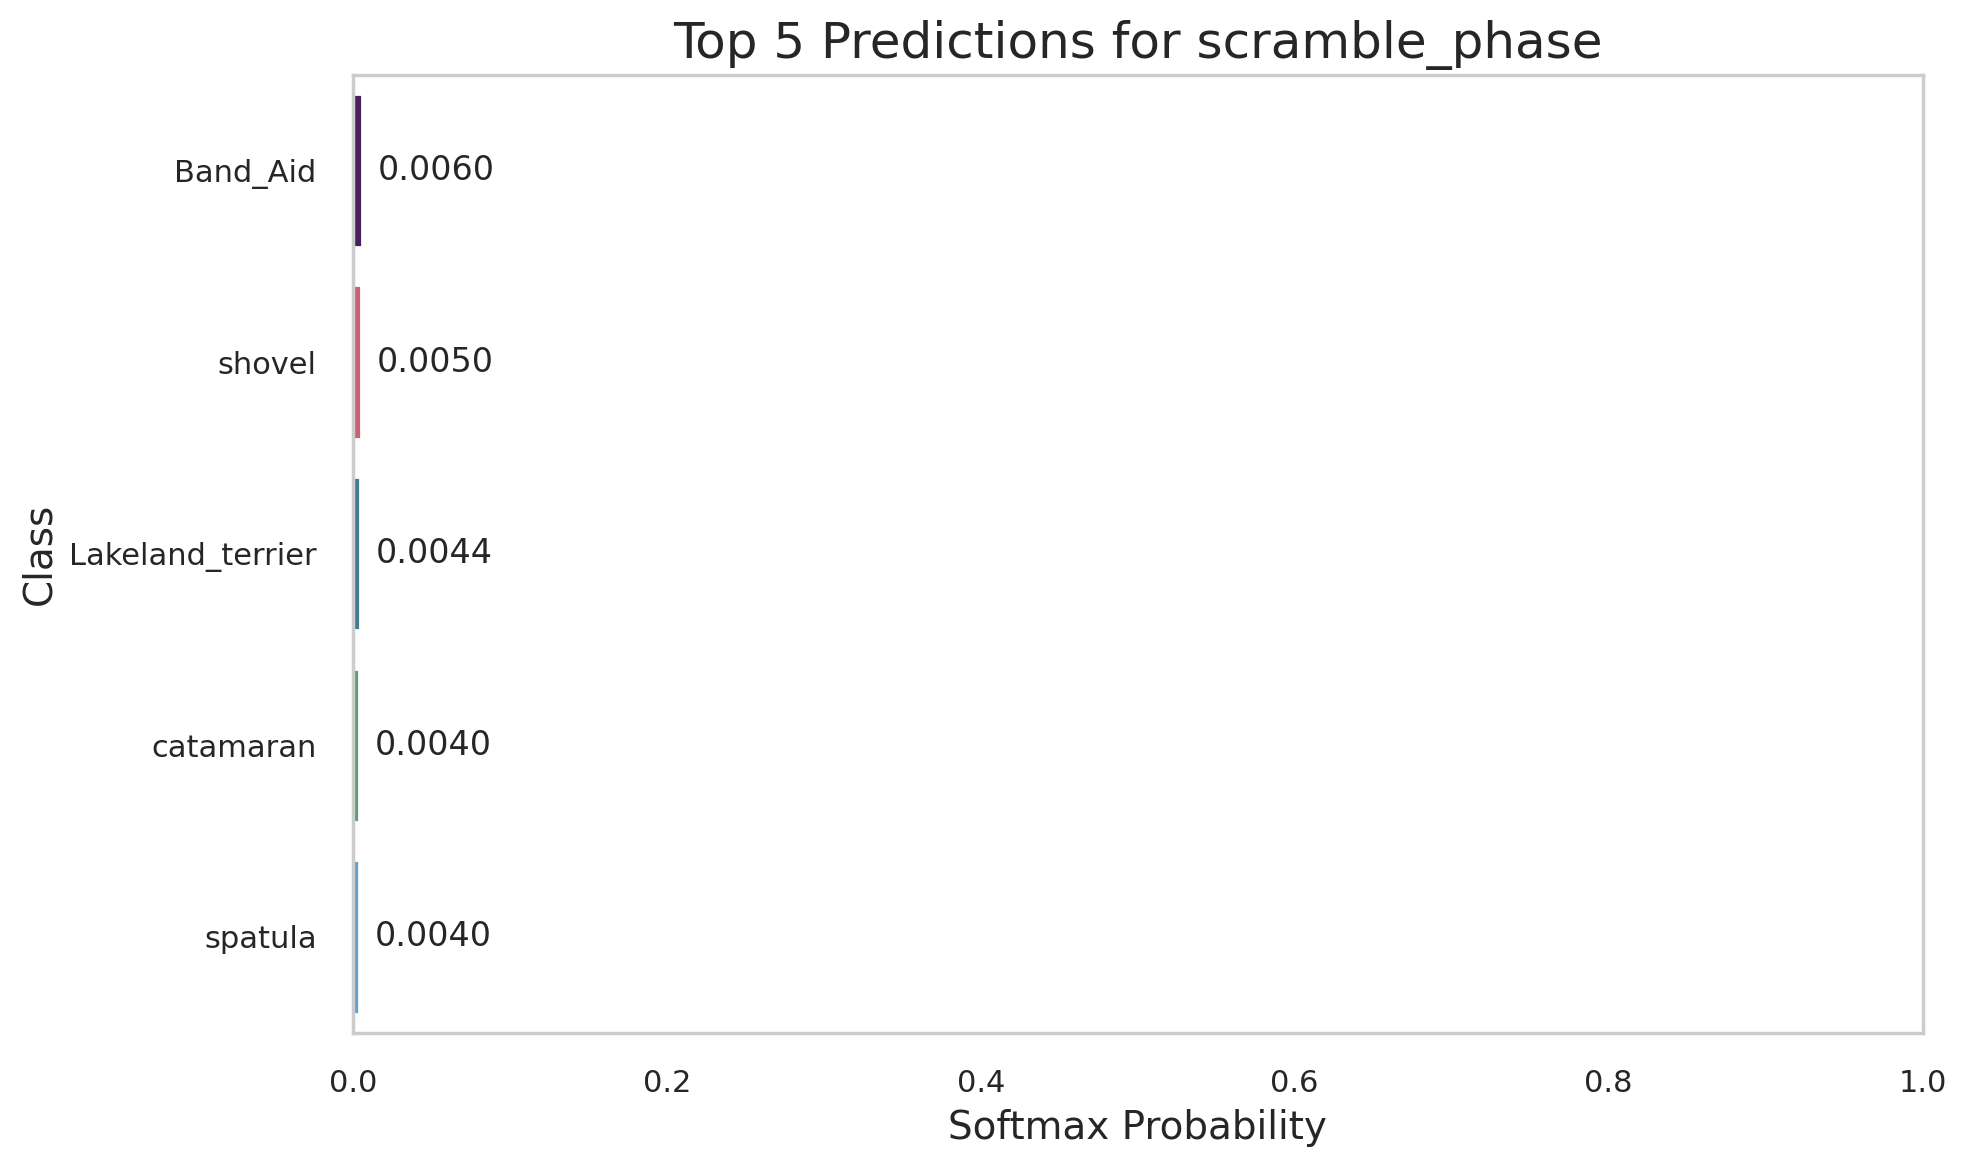

<ipython-input-44-c2e1e337f8d3>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Probability', y='Class', data=df, palette=colors[:len(class_labels)])


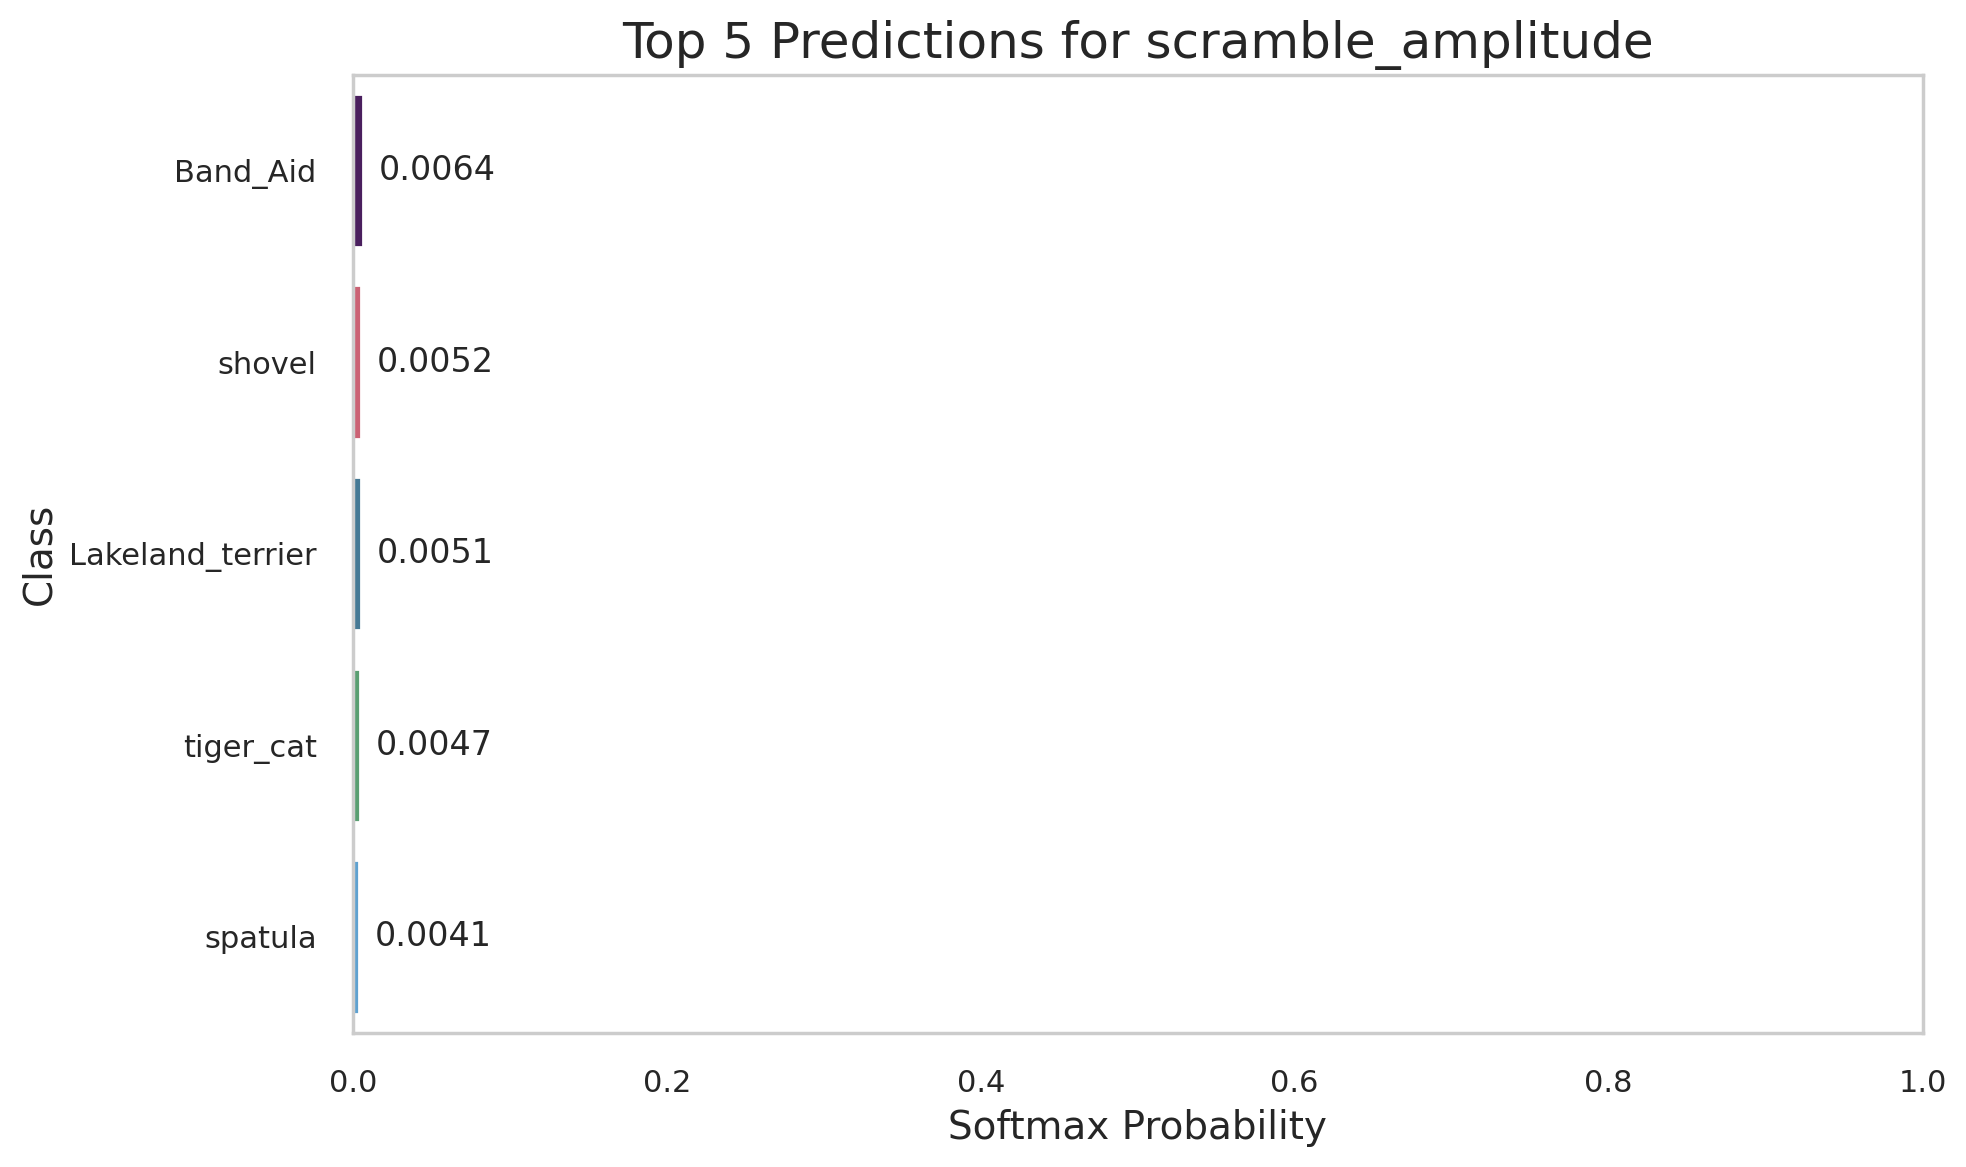

In [ ]:
plot_top5_predictions(classifications_vit)